In [1]:
!nvidia-smi

Sat Sep 14 07:04:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX                On | 00000000:AF:00.0 Off |                  N/A |
| 41%   39C    P8               14W / 280W|    183MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


# Data preprocessing

In [1]:
!pip install pywavelets

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import EfficientNetB3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pywt

2024-10-28 16:39:25.717920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 16:39:25.735295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 16:39:25.755449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 16:39:25.761368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 16:39:25.775743: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import torch
import torch.nn.functional as F

# 패딩을 통해 (1025, 5)을 (1026, 32)로 확장
def pad_input(input_tensor):
    # 시간 축에 13개의 패딩을 양쪽으로 추가하여 5 -> 32로 확장
    # 주파수 축에는 1개의 패딩을 추가하여 1025 -> 1026으로 확장
    padded_tensor = F.pad(input_tensor, (13, 14, 0, 1), mode='constant', value=0)
    return padded_tensor

In [4]:
import random


# 데이터 로드 및 CQT 변환 함수
def load_audio_files_cqt(directory):
    files = os.listdir(directory)
    # files = random.sample([f for f in files if f.endswith('.wav')], 100)
    audios = []
    labels = []
    target_duration = 0.03  # 0.05초
    count_12 = 1
    count_8 = 1

    for file in files:
        if file.endswith('.wav'):
            path = os.path.join(directory, file)
            label = int(file[:4])  # 파일 이름의 첫 네글자를 숫자로 변환

            if label == 12:
                if count_12 > 2000:
                    continue
                else:
                    count_12 += 1
            if label == 8:
                if count_8 > 2000:
                    continue
                else:
                    count_8 += 1
                
            audio, sr = librosa.load(path, sr=22050)

            # 오디오 길이가 0.05초 미만인 경우 무음 패딩 추가
            if len(audio) / sr < target_duration:
                target_length = int(target_duration * sr)
                padding = target_length - len(audio)
                audio = np.pad(audio, (0, padding), mode='constant')
                
            # 오디오 길이가 0.05초를 초과하는 경우 잘라내기
            elif len(audio) / sr > target_duration:
                audio = audio[:int(target_duration * sr)]

            # 윈도우 함수 적용 (예: Hamming 윈도우)
            window = np.hamming(len(audio))  # 오디오 길이만큼 Hamming 윈도우 생성
            audio = audio * window  # 윈도우 적용


            # CWT 스펙트로그램 생성
            scales = np.arange(1, 128) # 주파수축을 설정하는 거임!
            cwt_matrix, _ = pywt.cwt(audio, scales, 'morl') # morl ->  사인파와 가우시안이 결합되어 있어 주파수 영역에서의 변화를 세밀하게 잡아낼 수 있습니다.
            cwt_magnitude = np.abs(cwt_matrix)
            
            # CWT 크기를 (1, 84, 65)로 패딩 또는 트리밍
            cwt_tensor = torch.tensor(cwt_magnitude).unsqueeze(0)  # (1, scales, frames)
            # padded_cwt = pad_or_trim_to_65(cwt_tensor)  # (1, 84, 65)

            audios.append(cwt_tensor.numpy())
            labels.append(label)
    return audios, labels

def load_audio_files_cqt_test(directory):
    files = os.listdir(directory)
    # files = random.sample([f for f in files if f.endswith('.wav')], 100)
    audios = []
    labels = []
    target_duration = 0.03  # 0.05초
    count_0 = 0

    for file in files:
        if file.endswith('.wav'):
            path = os.path.join(directory, file)
            label = int(file[5:9])  # 파일 이름의 첫 네글자를 숫자로 변환
            
            if label == 0:
                if count_0 > 200:
                    continue
                else:
                    count_0 += 1
            
            audio, sr = librosa.load(path, sr=22050)

            # 오디오 길이가 0.05초 미만인 경우 무음 패딩 추가
            if len(audio) / sr < target_duration:
                target_length = int(target_duration * sr)
                padding = target_length - len(audio)
                audio = np.pad(audio, (0, padding), mode='constant')
                
            # 오디오 길이가 0.05초를 초과하는 경우 잘라내기
            elif len(audio) / sr > target_duration:
                audio = audio[:int(target_duration * sr)]

            # 윈도우 함수 적용 (예: Hamming 윈도우)
            window = np.hamming(len(audio))  # 오디오 길이만큼 Hamming 윈도우 생성
            audio = audio * window  # 윈도우 적용



            # CWT 스펙트로그램 생성
            scales = np.arange(1, 128)# 주파수축을 설정하는 거임!
            cwt_matrix, _ = pywt.cwt(audio, scales, 'morl') # morl ->  사인파와 가우시안이 결합되어 있어 주파수 영역에서의 변화를 세밀하게 잡아낼 수 있습니다.
            cwt_magnitude = np.abs(cwt_matrix)
            
            # CWT 크기를 (1, 84, 65)로 패딩 또는 트리밍
            cwt_tensor = torch.tensor(cwt_magnitude).unsqueeze(0)  # (1, scales, frames)
            # padded_cqt = pad_or_trim_to_65(cqt_tensor)  # (1, 1026, 32)

            audios.append(cwt_tensor.numpy())  # 패딩된 텐서를 리스트에 추가
            labels.append(label)  # 레이블 추가
    return audios, labels

In [5]:
# 폴더 "A"와 "B"에서 오디오 로드
audios, labels = load_audio_files_cqt('sliced')
audios_test, labels_test = load_audio_files_cqt_test('test_data')

In [6]:
audios[0].shape

(1, 127, 661)

In [7]:
import numpy as np

# 라벨과 원-핫 인코딩 벡터 매핑 딕셔너리
label_to_multihot = {
    0: [0,0,0,0,0,0,0,0],
    1: [1,0,0,0,0,0,0,0],
    2: [0,1,0,0,0,0,0,0],
    3: [0,1,0,0,0,0,0,0],
    4: [0,1,0,0,0,0,0,0],
    5: [0,0,1,0,0,0,0,0],
    6: [0,0,1,0,0,0,0,0],
    8: [0,0,0,1,0,0,0,0],
    9: [0,0,0,0,1,0,0,0],
    10: [0,0,0,0,0,1,0,0],
    11: [0,0,0,0,0,0,1,0],
    12: [0,0,0,0,0,0,0,1],
    13: [0,0,0,0,0,0,0,1],
    111: [1,0,0,0,0,0,1,0],
    211: [0,1,0,0,0,0,1,0],
    206: [0,1,1,0,0,0,0,0],
    106: [1,0,1,0,0,0,0,0],
    1112: [0,0,0,0,0,0,1,1],
    612: [0,0,1,0,0,0,0,1],
    611: [0,0,1,0,0,0,1,0],
    411: [0,1,0,0,0,0,1,0],
    311: [0,1,0,0,0,0,1,0],
    910: [0,0,0,0,1,1,0,0],
    610: [0,0,1,0,0,1,0,0],
    911: [0,0,0,0,1,0,1,0],
    306: [0,1,1,0,0,0,0,0],
    406: [0,1,1,0,0,0,0,0],
    613: [0,0,1,0,0,0,0,1],
    1011: [0,0,0,0,0,1,1,0],
}

# 원-핫 인코딩 변환 함수
def convert_to_multihot(labels, label_to_onehot):
    multihot_encoded = np.array([label_to_multihot[label] for label in labels])
    return multihot_encoded

# 라벨 변환
labels_multihot = convert_to_multihot(labels, label_to_multihot)
labels_multihot_test = convert_to_multihot(labels_test, label_to_multihot)

In [8]:
# 데이터셋 분할
# X_train, X_test, y_train, y_test = train_test_split(audios, labels_multihot, test_size=0.2, random_state=42)

X_train = audios
X_test = audios_test
y_train = labels_multihot
y_test = labels_multihot_test

# training

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
import copy

# CUDA 지원 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [10]:
class JaccardLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super(JaccardLoss, self).__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        # y_pred는 이미 sigmoid를 통과했으므로, 이를 이진화 (0 또는 1)함
        y_pred_bin = (y_pred > 0.5).float()
        
        # Jaccard Index = (|A ∩ B|) / (|A ∪ B|)
        intersection = (y_pred * y_true).sum(dim=1)
        union = y_pred.sum(dim=1) + y_true.sum(dim=1) - intersection
        jaccard = (intersection + self.eps) / (union + self.eps)
        return 1 - jaccard.mean()

class UNetWithClassifier(nn.Module):
    def __init__(self, num_classes):
        super(UNetWithClassifier, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        def upsample_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Contracting path (downsampling)
        self.encoder1 = conv_block(1, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Expanding path (upsampling)
        self.upconv4 = upsample_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)

        self.upconv3 = upsample_block(512, 256)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = upsample_block(256, 128)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = upsample_block(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)  # 마지막 출력 채널을 1로 맞춤

        # 전역 풀링과 분류를 위한 FC 레이어
        self.global_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

        # Dropout 추가
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, kernel_size=2, stride=2))
        e3 = self.encoder3(F.max_pool2d(e2, kernel_size=2, stride=2))
        e4 = self.encoder4(F.max_pool2d(e3, kernel_size=2, stride=2))

        # Bottleneck (Latent space)
        b = self.bottleneck(F.max_pool2d(e4, kernel_size=2, stride=2))

        # Classification from Latent Space
        pooled = self.global_pooling(b)  # Output shape: (batch_size, 1024, 1, 1)
        flattened = pooled.view(pooled.size(0), -1)  # Output shape: (batch_size, 1024)
        flattened = self.dropout(flattened)
        class_output = torch.sigmoid(self.fc(flattened))  # Multi-label classification

        # Decoder (Reconstruction)
        d4 = self.upconv4(b)
        d4 = F.interpolate(d4, size=e4.shape[2:])
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = F.interpolate(d3, size=e3.shape[2:])
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = F.interpolate(d2, size=e2.shape[2:])
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = F.interpolate(d1, size=e1.shape[2:])
        d1 = torch.cat((d1, e1), dim=1)
        recon_output = self.final_conv(self.decoder1(d1))  # 최종 디코더 결과를 1채널로 변환

        return recon_output, class_output

In [11]:
import torch
from torch.utils.data import Dataset
import numpy as np

# 커스텀 데이터셋 클래스 정의
class AudioDataset(Dataset):
    def __init__(self, audios, labels, max_time_dim=None, transform=None):
        self.audios = audios
        self.labels = labels
        self.max_time_dim = max_time_dim or max([audio.shape[-1] for audio in audios])  # 최대 시간 축 크기 찾기
        self.transform = transform

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        sample = self.audios[idx]  # NumPy 배열로 된 오디오 데이터를 로드
        label = self.labels[idx]

        # NumPy 배열을 텐서로 변환
        sample = torch.tensor(sample).float()  # [1, 1026, N] 형식

        # 시간 축을 기준으로 패딩 적용하여 최대 시간 길이에 맞춤
        time_padding = self.max_time_dim - sample.shape[-1]
        if time_padding > 0:
            sample = torch.nn.functional.pad(sample, (0, time_padding), mode='constant', value=0)

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# 데이터 증강 및 전처리 변환 설정 (이미 텐서로 변환되었으므로 ToTensor()는 불필요)
train_transform = None
test_transform = None

# PyTorch Dataset 생성
train_dataset = AudioDataset(X_train, y_train, transform=train_transform)
test_dataset = AudioDataset(X_test, y_test, transform=test_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get a single sample from the train dataset (first sample for example)
sample, label = train_dataset[0]

# Retrieve the size of the sample (which is a tensor)
sample_size = sample.size()

sample_size

torch.Size([1, 127, 661])

In [12]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy
import os
import matplotlib.pyplot as plt

# 모델, 옵티마이저, 학습 기록 저장 함수
def save_checkpoint(epoch, model, optimizer, history, best_val_accuracy, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'best_val_accuracy': best_val_accuracy
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

# 저장된 체크포인트 불러오기
def load_checkpoint(filename, model, optimizer):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        history = checkpoint['history']
        best_val_accuracy = checkpoint['best_val_accuracy']
        print(f"Checkpoint loaded from epoch {epoch+1}")
        return epoch, history, best_val_accuracy
    else:
        print("No checkpoint found.")
        return 0, {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_jaccard': []}, 0.0

# 학습 기록 그래프 출력 함수
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()

    # Jaccard Index Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_jaccard'], label='Validation Jaccard Index')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Index')
    plt.title('Jaccard Index History')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def jaccard_index(y_true, y_pred, eps=1e-7):
    """
    Jaccard Index (IoU) 계산 함수.
    y_true와 y_pred는 이진화된 값이어야 합니다.
    """
    intersection = (y_true * y_pred).sum(dim=1)
    union = y_true.sum(dim=1) + y_pred.sum(dim=1) - intersection
    iou = (intersection + eps) / (union + eps)
    
    return iou.mean()


def evaluate(model, loader, reconstruction_criterion, classification_criterion):
    model.eval()
    running_loss = 0.0
    running_jaccard = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델에서 두 개의 출력을 받음: recon_output, class_output
            recon_output, class_output = model(inputs)

            # 재구성 손실 (recon_output과 실제 입력인 inputs 간의 차이)
            recon_loss = reconstruction_criterion(recon_output, inputs)
            
            # 분류 손실 (class_output과 실제 라벨 간의 차이)
            classification_loss = classification_criterion(class_output, labels)

            # 두 손실을 합하여 최종 validation 손실로 사용
            loss = recon_loss + classification_loss
            running_loss += loss.item()

            # 분류 결과 예측값
            predicted = (class_output > 0.5).int()
            correct += (predicted == labels).sum().item()
            total += labels.numel()

            # Jaccard Index 계산
            running_jaccard += jaccard_index(labels, predicted) #.item()

    avg_jaccard = running_jaccard / len(loader)
    accuracy = correct / total

    return running_loss / len(loader), accuracy, avg_jaccard

In [24]:
# 학습 및 검증 함수 정의
def train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device, checkpoint_file='checkpoint.pth'):
    # 체크포인트 불러오기
    start_epoch, history, best_val_accuracy = load_checkpoint(checkpoint_file, model, optimizer)

    best_model_wts = copy.deepcopy(model.state_dict())

    # 손실 함수들 정의
    reconstruction_criterion = nn.MSELoss()  # 재구성 손실
    classification_criterion = JaccardLoss()  # 분류 손실
    # classification_criterion = nn.BCEWithLogitsLoss()

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"Epoch [{epoch+1}/{num_epochs}] training...")
        
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
        
            # 모델에서 두 가지 출력을 받음: recon_output (재구성된 이미지), class_output (분류 결과)
            recon_output, class_output = model(inputs)
            
            # 재구성 손실 (recon_output과 실제 입력인 inputs 간의 차이)
            recon_loss = reconstruction_criterion(recon_output, inputs)
        
            # 분류 손실 (class_output과 실제 라벨 간의 차이)
            classification_loss = classification_criterion(class_output, labels)
        
            # 두 손실의 합을 최종 손실로 사용
            loss = recon_loss + classification_loss
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            
            # 분류 결과 예측값
            predicted = (class_output > 0.5).int()
            correct += (predicted == labels).sum().item()
            total += labels.numel()

        print()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        print(f"Evaluating on validation set...")
        val_loss, val_accuracy, val_jaccard = evaluate(model, test_loader, reconstruction_criterion, classification_criterion)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}, "
              f"Val_Loss: {val_loss:.4f}, Val_Acc: {val_accuracy:.4f}, "
              f"Val_Jaccard: {val_jaccard:.4f}")

        # 학습 기록 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_jaccard'].append(val_jaccard)

        # Best model weights 저장 - val_jaccard 기준
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"New best model with val_accuracy: {val_accuracy:.4f}")

        # 학습 상태 저장 - val_jaccard 기준으로 저장
        save_checkpoint(epoch, model, optimizer, history, best_val_accuracy, checkpoint_file)

        # Best 모델 로드
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved as 'best_model.pth'")

    return model, history

No checkpoint found.
Epoch [1/60] training...


Evaluating on validation set...
Epoch [1/60], Loss: 0.6919, Acc: 0.7399, Val_Loss: 0.8410, Val_Acc: 0.6890, Val_Jaccard: 0.1713
New best model with val_jaccard: 0.1713
Checkpoint saved at epoch 1
Best model saved as 'best_model.pth'
Epoch [2/60] training...


Evaluating on validation set...
Epoch [2/60], Loss: 0.6206, Acc: 0.7894, Val_Loss: 0.8411, Val_Acc: 0.7010, Val_Jaccard: 0.1658
Checkpoint saved at epoch 2
Best model saved as 'best_model.pth'
Epoch [3/60] training...


Evaluating on validation set...
Epoch [3/60], Loss: 0.6263, Acc: 0.7866, Val_Loss: 0.8397, Val_Acc: 0.7292, Val_Jaccard: 0.1684
Checkpoint saved at epoch 3
Best model saved as 'best_model.pth'
Epoch [4/60] training...


Evaluating on validation set...
Epoch [4/60], Loss: 0.6179, Acc: 0.7944, Val_Loss: 0.8982, Val_Acc: 0.7067, Val_Jaccard: 0.1144
Checkpoint saved at epoch 4
Best model saved as 'best_model.pth'
Epoch [5/60] training...


Evaluating on validation set...
Epoch [5/60], Loss: 0.6212, Acc: 0.7928, Val_Loss: 0.9309, Val_Acc: 0.6565, Val_Jaccard: 0.0779
Checkpoint saved at epoch 5
Best model saved as 'best_model.pth'
Epoch [6/60] training...


Evaluating on validation set...
Epoch [6/60], Loss: 0.6292, Acc: 0.7873, Val_Loss: 0.8437, Val_Acc: 0.7253, Val_Jaccard: 0.1706
Checkpoint saved at epoch 6
Best model saved as 'best_model.pth'
Epoch [7/60] training...


Evaluating on validation set...
Epoch [7/60], Loss: 0.6228, Acc: 0.7909, Val_Loss: 0.9165, Val_Acc: 0.6843, Val_Jaccard: 0.0870
Checkpoint saved at epoch 7
Best model saved as 'best_model.pth'
Epoch [8/60] training...


Evaluating on validation set...
Epoch [8/60], Loss: 0.6226, Acc: 0.7893, Val_Loss: 0.8261, Val_Acc: 0.7188, Val_Jaccard: 0.1787
New best model with val_jaccard: 0.1787
Checkpoint saved at epoch 8
Best model saved as 'best_model.pth'
Epoch [9/60] training...


Evaluating on validation set...
Epoch [9/60], Loss: 0.5679, Acc: 0.8142, Val_Loss: 0.8262, Val_Acc: 0.7259, Val_Jaccard: 0.1804
New best model with val_jaccard: 0.1804
Checkpoint saved at epoch 9
Best model saved as 'best_model.pth'
Epoch [10/60] training...


Evaluating on validation set...
Epoch [10/60], Loss: 0.5434, Acc: 0.8259, Val_Loss: 0.8822, Val_Acc: 0.6723, Val_Jaccard: 0.1222
Checkpoint saved at epoch 10
Best model saved as 'best_model.pth'
Epoch [11/60] training...


Evaluating on validation set...
Epoch [11/60], Loss: 0.5428, Acc: 0.8276, Val_Loss: 0.8603, Val_Acc: 0.6900, Val_Jaccard: 0.1469
Checkpoint saved at epoch 11
Best model saved as 'best_model.pth'
Epoch [12/60] training...


Evaluating on validation set...
Epoch [12/60], Loss: 0.5440, Acc: 0.8268, Val_Loss: 0.7890, Val_Acc: 0.7311, Val_Jaccard: 0.2145
New best model with val_jaccard: 0.2145
Checkpoint saved at epoch 12
Best model saved as 'best_model.pth'
Epoch [13/60] training...


Evaluating on validation set...
Epoch [13/60], Loss: 0.5265, Acc: 0.8359, Val_Loss: 0.8765, Val_Acc: 0.6808, Val_Jaccard: 0.1298
Checkpoint saved at epoch 13
Best model saved as 'best_model.pth'
Epoch [14/60] training...


Evaluating on validation set...
Epoch [14/60], Loss: 0.5257, Acc: 0.8346, Val_Loss: 0.8714, Val_Acc: 0.6889, Val_Jaccard: 0.1327
Checkpoint saved at epoch 14
Best model saved as 'best_model.pth'
Epoch [15/60] training...


Evaluating on validation set...
Epoch [15/60], Loss: 0.5243, Acc: 0.8358, Val_Loss: 0.7658, Val_Acc: 0.7403, Val_Jaccard: 0.2423
New best model with val_jaccard: 0.2423
Checkpoint saved at epoch 15
Best model saved as 'best_model.pth'
Epoch [16/60] training...


Evaluating on validation set...
Epoch [16/60], Loss: 0.5032, Acc: 0.8446, Val_Loss: 0.7382, Val_Acc: 0.7455, Val_Jaccard: 0.2670
New best model with val_jaccard: 0.2670
Checkpoint saved at epoch 16
Best model saved as 'best_model.pth'
Epoch [17/60] training...


Evaluating on validation set...
Epoch [17/60], Loss: 0.4861, Acc: 0.8516, Val_Loss: 0.6057, Val_Acc: 0.8278, Val_Jaccard: 0.4013
New best model with val_jaccard: 0.4013
Checkpoint saved at epoch 17
Best model saved as 'best_model.pth'
Epoch [18/60] training...


Evaluating on validation set...
Epoch [18/60], Loss: 0.4745, Acc: 0.8551, Val_Loss: 0.7048, Val_Acc: 0.7405, Val_Jaccard: 0.2992
Checkpoint saved at epoch 18
Best model saved as 'best_model.pth'
Epoch [19/60] training...


Evaluating on validation set...
Epoch [19/60], Loss: 0.4767, Acc: 0.8562, Val_Loss: 0.7737, Val_Acc: 0.7262, Val_Jaccard: 0.2352
Checkpoint saved at epoch 19
Best model saved as 'best_model.pth'
Epoch [20/60] training...


Evaluating on validation set...
Epoch [20/60], Loss: 0.4724, Acc: 0.8563, Val_Loss: 0.7735, Val_Acc: 0.7310, Val_Jaccard: 0.2321
Checkpoint saved at epoch 20
Best model saved as 'best_model.pth'
Epoch [21/60] training...


Evaluating on validation set...
Epoch [21/60], Loss: 0.4751, Acc: 0.8545, Val_Loss: 0.6909, Val_Acc: 0.7716, Val_Jaccard: 0.3160
Checkpoint saved at epoch 21
Best model saved as 'best_model.pth'
Epoch [22/60] training...


Evaluating on validation set...
Epoch [22/60], Loss: 0.4707, Acc: 0.8583, Val_Loss: 0.7548, Val_Acc: 0.7444, Val_Jaccard: 0.2479
Checkpoint saved at epoch 22
Best model saved as 'best_model.pth'
Epoch [23/60] training...


Evaluating on validation set...
Epoch [23/60], Loss: 0.4724, Acc: 0.8580, Val_Loss: 0.7169, Val_Acc: 0.7736, Val_Jaccard: 0.2899
Checkpoint saved at epoch 23
Best model saved as 'best_model.pth'
Epoch [24/60] training...


Evaluating on validation set...
Epoch [24/60], Loss: 0.4733, Acc: 0.8580, Val_Loss: 0.7063, Val_Acc: 0.7645, Val_Jaccard: 0.2993
Checkpoint saved at epoch 24
Best model saved as 'best_model.pth'
Epoch [25/60] training...


Evaluating on validation set...
Epoch [25/60], Loss: 0.4716, Acc: 0.8583, Val_Loss: 0.6593, Val_Acc: 0.8018, Val_Jaccard: 0.3448
Checkpoint saved at epoch 25
Best model saved as 'best_model.pth'
Epoch [26/60] training...


Evaluating on validation set...
Epoch [26/60], Loss: 0.4761, Acc: 0.8567, Val_Loss: 0.7031, Val_Acc: 0.7679, Val_Jaccard: 0.3017
Checkpoint saved at epoch 26
Best model saved as 'best_model.pth'
Epoch [27/60] training...


Evaluating on validation set...
Epoch [27/60], Loss: 0.4706, Acc: 0.8576, Val_Loss: 0.7306, Val_Acc: 0.7447, Val_Jaccard: 0.2773
Checkpoint saved at epoch 27
Best model saved as 'best_model.pth'
Epoch [28/60] training...


Evaluating on validation set...
Epoch [28/60], Loss: 0.4719, Acc: 0.8578, Val_Loss: 0.7167, Val_Acc: 0.7561, Val_Jaccard: 0.2882
Checkpoint saved at epoch 28
Best model saved as 'best_model.pth'
Epoch [29/60] training...


Evaluating on validation set...
Epoch [29/60], Loss: 0.4756, Acc: 0.8554, Val_Loss: 0.6748, Val_Acc: 0.7770, Val_Jaccard: 0.3313
Checkpoint saved at epoch 29
Best model saved as 'best_model.pth'
Epoch [30/60] training...


Evaluating on validation set...
Epoch [30/60], Loss: 0.4738, Acc: 0.8569, Val_Loss: 0.6264, Val_Acc: 0.8186, Val_Jaccard: 0.3800
Checkpoint saved at epoch 30
Best model saved as 'best_model.pth'
Epoch [31/60] training...


Evaluating on validation set...
Epoch [31/60], Loss: 0.4740, Acc: 0.8555, Val_Loss: 0.7098, Val_Acc: 0.7553, Val_Jaccard: 0.2948
Checkpoint saved at epoch 31
Best model saved as 'best_model.pth'
Epoch [32/60] training...


Evaluating on validation set...
Epoch [32/60], Loss: 0.4726, Acc: 0.8573, Val_Loss: 0.8183, Val_Acc: 0.7067, Val_Jaccard: 0.1899
Checkpoint saved at epoch 32
Best model saved as 'best_model.pth'
Epoch [33/60] training...


Evaluating on validation set...
Epoch [33/60], Loss: 0.4721, Acc: 0.8572, Val_Loss: 0.7864, Val_Acc: 0.7211, Val_Jaccard: 0.2169
Checkpoint saved at epoch 33
Best model saved as 'best_model.pth'
Epoch [34/60] training...


Evaluating on validation set...
Epoch [34/60], Loss: 0.4776, Acc: 0.8547, Val_Loss: 0.6791, Val_Acc: 0.7875, Val_Jaccard: 0.3293
Checkpoint saved at epoch 34
Best model saved as 'best_model.pth'
Epoch [35/60] training...


Evaluating on validation set...
Epoch [35/60], Loss: 0.4742, Acc: 0.8570, Val_Loss: 0.8321, Val_Acc: 0.6992, Val_Jaccard: 0.1705
Checkpoint saved at epoch 35
Best model saved as 'best_model.pth'
Epoch [36/60] training...


Evaluating on validation set...
Epoch [36/60], Loss: 0.4760, Acc: 0.8556, Val_Loss: 0.6567, Val_Acc: 0.8016, Val_Jaccard: 0.3489
Checkpoint saved at epoch 36
Best model saved as 'best_model.pth'
Epoch [37/60] training...


Evaluating on validation set...
Epoch [37/60], Loss: 0.4717, Acc: 0.8564, Val_Loss: 0.6521, Val_Acc: 0.7965, Val_Jaccard: 0.3522
Checkpoint saved at epoch 37
Best model saved as 'best_model.pth'
Epoch [38/60] training...


Evaluating on validation set...
Epoch [38/60], Loss: 0.4715, Acc: 0.8580, Val_Loss: 0.6804, Val_Acc: 0.7700, Val_Jaccard: 0.3250
Checkpoint saved at epoch 38
Best model saved as 'best_model.pth'
Epoch [39/60] training...


Evaluating on validation set...
Epoch [39/60], Loss: 0.4758, Acc: 0.8552, Val_Loss: 0.6845, Val_Acc: 0.7747, Val_Jaccard: 0.3233
Checkpoint saved at epoch 39
Best model saved as 'best_model.pth'
Epoch [40/60] training...


Evaluating on validation set...
Epoch [40/60], Loss: 0.4759, Acc: 0.8562, Val_Loss: 0.6647, Val_Acc: 0.7887, Val_Jaccard: 0.3407
Checkpoint saved at epoch 40
Best model saved as 'best_model.pth'
Epoch [41/60] training...


Evaluating on validation set...
Epoch [41/60], Loss: 0.4720, Acc: 0.8582, Val_Loss: 0.7525, Val_Acc: 0.7432, Val_Jaccard: 0.2515
Checkpoint saved at epoch 41
Best model saved as 'best_model.pth'
Epoch [42/60] training...


Evaluating on validation set...
Epoch [42/60], Loss: 0.4740, Acc: 0.8568, Val_Loss: 0.6608, Val_Acc: 0.7926, Val_Jaccard: 0.3435
Checkpoint saved at epoch 42
Best model saved as 'best_model.pth'
Epoch [43/60] training...


Evaluating on validation set...
Epoch [43/60], Loss: 0.4773, Acc: 0.8546, Val_Loss: 0.6620, Val_Acc: 0.8128, Val_Jaccard: 0.3504
Checkpoint saved at epoch 43
Best model saved as 'best_model.pth'
Epoch [44/60] training...


Evaluating on validation set...
Epoch [44/60], Loss: 0.4739, Acc: 0.8567, Val_Loss: 0.7064, Val_Acc: 0.7646, Val_Jaccard: 0.3003
Checkpoint saved at epoch 44
Best model saved as 'best_model.pth'
Epoch [45/60] training...


Evaluating on validation set...
Epoch [45/60], Loss: 0.4781, Acc: 0.8545, Val_Loss: 0.7013, Val_Acc: 0.7712, Val_Jaccard: 0.3069
Checkpoint saved at epoch 45
Best model saved as 'best_model.pth'
Epoch [46/60] training...


Evaluating on validation set...
Epoch [46/60], Loss: 0.4710, Acc: 0.8583, Val_Loss: 0.7807, Val_Acc: 0.7287, Val_Jaccard: 0.2229
Checkpoint saved at epoch 46
Best model saved as 'best_model.pth'
Epoch [47/60] training...


Evaluating on validation set...
Epoch [47/60], Loss: 0.4718, Acc: 0.8579, Val_Loss: 0.7347, Val_Acc: 0.7475, Val_Jaccard: 0.2711
Checkpoint saved at epoch 47
Best model saved as 'best_model.pth'
Epoch [48/60] training...


Evaluating on validation set...
Epoch [48/60], Loss: 0.4706, Acc: 0.8580, Val_Loss: 0.7487, Val_Acc: 0.7522, Val_Jaccard: 0.2577
Checkpoint saved at epoch 48
Best model saved as 'best_model.pth'
Epoch [49/60] training...


Evaluating on validation set...
Epoch [49/60], Loss: 0.4747, Acc: 0.8558, Val_Loss: 0.7584, Val_Acc: 0.7429, Val_Jaccard: 0.2472
Checkpoint saved at epoch 49
Best model saved as 'best_model.pth'
Epoch [50/60] training...


Evaluating on validation set...
Epoch [50/60], Loss: 0.4755, Acc: 0.8567, Val_Loss: 0.7601, Val_Acc: 0.7403, Val_Jaccard: 0.2434
Checkpoint saved at epoch 50
Best model saved as 'best_model.pth'
Epoch [51/60] training...


Evaluating on validation set...
Epoch [51/60], Loss: 0.4719, Acc: 0.8559, Val_Loss: 0.6599, Val_Acc: 0.7780, Val_Jaccard: 0.3450
Checkpoint saved at epoch 51
Best model saved as 'best_model.pth'
Epoch [52/60] training...


Evaluating on validation set...
Epoch [52/60], Loss: 0.4730, Acc: 0.8572, Val_Loss: 0.7465, Val_Acc: 0.7547, Val_Jaccard: 0.2592
Checkpoint saved at epoch 52
Best model saved as 'best_model.pth'
Epoch [53/60] training...


Evaluating on validation set...
Epoch [53/60], Loss: 0.4731, Acc: 0.8569, Val_Loss: 0.6970, Val_Acc: 0.7669, Val_Jaccard: 0.3078
Checkpoint saved at epoch 53
Best model saved as 'best_model.pth'
Epoch [54/60] training...


Evaluating on validation set...
Epoch [54/60], Loss: 0.4723, Acc: 0.8584, Val_Loss: 0.6837, Val_Acc: 0.7747, Val_Jaccard: 0.3210
Checkpoint saved at epoch 54
Best model saved as 'best_model.pth'
Epoch [55/60] training...


Evaluating on validation set...
Epoch [55/60], Loss: 0.4749, Acc: 0.8555, Val_Loss: 0.7186, Val_Acc: 0.7822, Val_Jaccard: 0.2950
Checkpoint saved at epoch 55
Best model saved as 'best_model.pth'
Epoch [56/60] training...


Evaluating on validation set...
Epoch [56/60], Loss: 0.4748, Acc: 0.8557, Val_Loss: 0.7329, Val_Acc: 0.7569, Val_Jaccard: 0.2720
Checkpoint saved at epoch 56
Best model saved as 'best_model.pth'
Epoch [57/60] training...


Evaluating on validation set...
Epoch [57/60], Loss: 0.4733, Acc: 0.8570, Val_Loss: 0.7391, Val_Acc: 0.7461, Val_Jaccard: 0.2659
Checkpoint saved at epoch 57
Best model saved as 'best_model.pth'
Epoch [58/60] training...


Evaluating on validation set...
Epoch [58/60], Loss: 0.4747, Acc: 0.8565, Val_Loss: 0.6382, Val_Acc: 0.8156, Val_Jaccard: 0.3676
Checkpoint saved at epoch 58
Best model saved as 'best_model.pth'
Epoch [59/60] training...


Evaluating on validation set...
Epoch [59/60], Loss: 0.4743, Acc: 0.8557, Val_Loss: 0.6700, Val_Acc: 0.7894, Val_Jaccard: 0.3374
Checkpoint saved at epoch 59
Best model saved as 'best_model.pth'
Epoch [60/60] training...


Evaluating on validation set...
Epoch [60/60], Loss: 0.4732, Acc: 0.8561, Val_Loss: 0.6205, Val_Acc: 0.8211, Val_Jaccard: 0.3834
Checkpoint saved at epoch 60
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

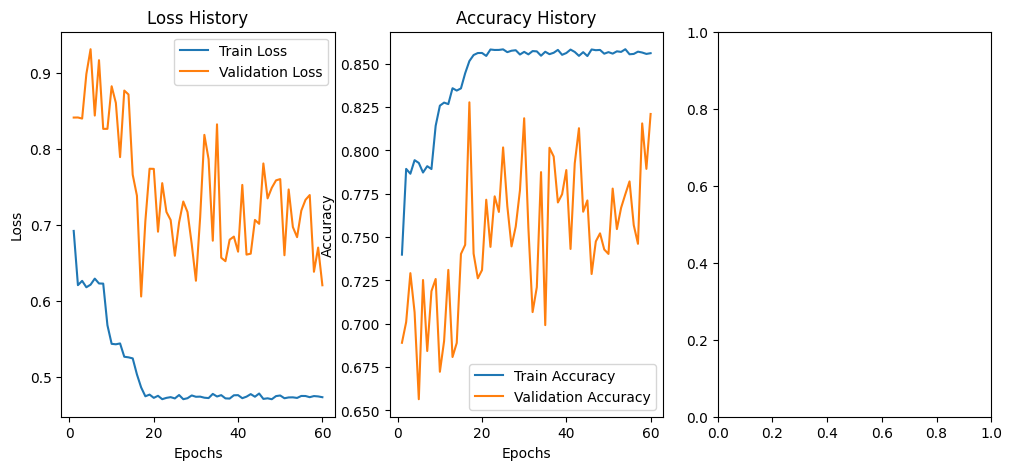

In [15]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 60
Epoch [60/63] training...


Evaluating on validation set...
Epoch [60/63], Loss: 0.4661, Acc: 0.8603, Val_Loss: 0.6523, Val_Acc: 0.7975, Val_Jaccard: 0.3580
Checkpoint saved at epoch 60
Best model saved as 'best_model.pth'
Epoch [61/63] training...


Evaluating on validation set...
Epoch [61/63], Loss: 0.4642, Acc: 0.8577, Val_Loss: 0.6367, Val_Acc: 0.8141, Val_Jaccard: 0.3695
Checkpoint saved at epoch 61
Best model saved as 'best_model.pth'
Epoch [62/63] training...


Evaluating on validation set...
Epoch [62/63], Loss: 0.4633, Acc: 0.8591, Val_Loss: 0.6526, Val_Acc: 0.7998, Val_Jaccard: 0.3549
Checkpoint saved at epoch 62
Best model saved as 'best_model.pth'
Epoch [63/63] training...


Evaluating on validation set...
Epoch [63/63], Loss: 0.4689, Acc: 0.8580, Val_Loss: 0.6551, Val_Acc: 0.7818, Val_Jaccard: 0.3508
Checkpoint saved at epoch 63
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

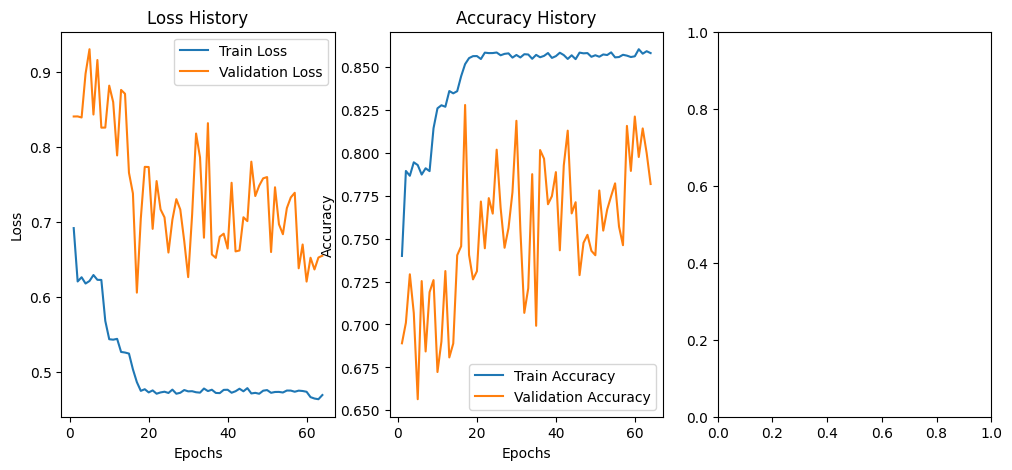

In [16]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 63
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 63
Epoch [63/65] training...


Evaluating on validation set...
Epoch [63/65], Loss: 0.4611, Acc: 0.8609, Val_Loss: 0.6544, Val_Acc: 0.7931, Val_Jaccard: 0.3487
Checkpoint saved at epoch 63
Best model saved as 'best_model.pth'
Epoch [64/65] training...


Evaluating on validation set...
Epoch [64/65], Loss: 0.4595, Acc: 0.8621, Val_Loss: 0.6606, Val_Acc: 0.7853, Val_Jaccard: 0.3449
Checkpoint saved at epoch 64
Best model saved as 'best_model.pth'
Epoch [65/65] training...


Evaluating on validation set...
Epoch [65/65], Loss: 0.4569, Acc: 0.8607, Val_Loss: 0.6900, Val_Acc: 0.7877, Val_Jaccard: 0.3167
Checkpoint saved at epoch 65
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

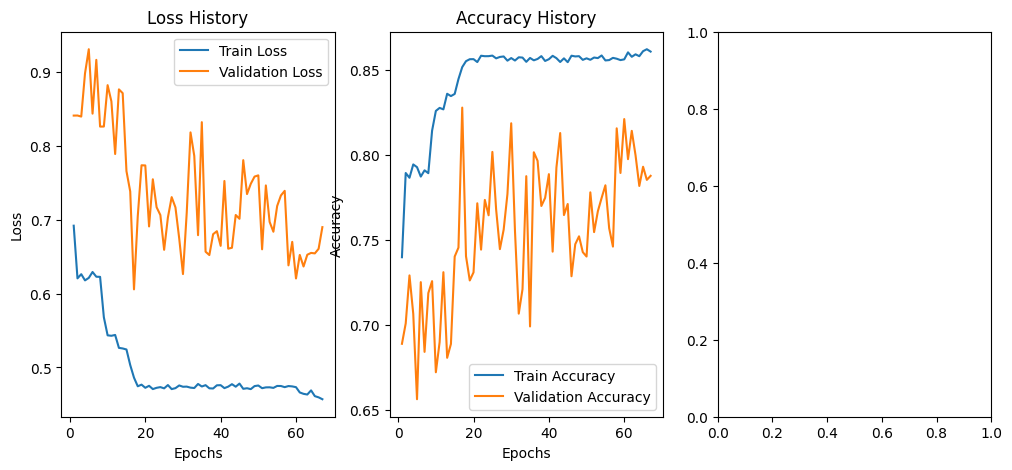

In [17]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 65
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 65
Epoch [65/110] training...


Evaluating on validation set...
Epoch [65/110], Loss: 0.4545, Acc: 0.8632, Val_Loss: 0.7280, Val_Acc: 0.7599, Val_Jaccard: 0.2768
Checkpoint saved at epoch 65
Best model saved as 'best_model.pth'
Epoch [66/110] training...


Evaluating on validation set...
Epoch [66/110], Loss: 0.4558, Acc: 0.8622, Val_Loss: 0.6706, Val_Acc: 0.7835, Val_Jaccard: 0.3348
Checkpoint saved at epoch 66
Best model saved as 'best_model.pth'
Epoch [67/110] training...


Evaluating on validation set...
Epoch [67/110], Loss: 0.4544, Acc: 0.8651, Val_Loss: 0.6291, Val_Acc: 0.8090, Val_Jaccard: 0.3723
Checkpoint saved at epoch 67
Best model saved as 'best_model.pth'
Epoch [68/110] training...


Evaluating on validation set...
Epoch [68/110], Loss: 0.4530, Acc: 0.8653, Val_Loss: 0.7240, Val_Acc: 0.7621, Val_Jaccard: 0.2799
Checkpoint saved at epoch 68
Best model saved as 'best_model.pth'
Epoch [69/110] training...


Evaluating on validation set...
Epoch [69/110], Loss: 0.4538, Acc: 0.8651, Val_Loss: 0.7905, Val_Acc: 0.7122, Val_Jaccard: 0.2149
Checkpoint saved at epoch 69
Best model saved as 'best_model.pth'
Epoch [70/110] training...


Evaluating on validation set...
Epoch [70/110], Loss: 0.4531, Acc: 0.8638, Val_Loss: 0.7240, Val_Acc: 0.7770, Val_Jaccard: 0.2829
Checkpoint saved at epoch 70
Best model saved as 'best_model.pth'
Epoch [71/110] training...


Evaluating on validation set...
Epoch [71/110], Loss: 0.4577, Acc: 0.8638, Val_Loss: 0.6424, Val_Acc: 0.7986, Val_Jaccard: 0.3650
Checkpoint saved at epoch 71
Best model saved as 'best_model.pth'
Epoch [72/110] training...


Evaluating on validation set...
Epoch [72/110], Loss: 0.4540, Acc: 0.8637, Val_Loss: 0.6709, Val_Acc: 0.7895, Val_Jaccard: 0.3312
Checkpoint saved at epoch 72
Best model saved as 'best_model.pth'
Epoch [73/110] training...


Evaluating on validation set...
Epoch [73/110], Loss: 0.4578, Acc: 0.8601, Val_Loss: 0.7211, Val_Acc: 0.7625, Val_Jaccard: 0.2834
Checkpoint saved at epoch 73
Best model saved as 'best_model.pth'
Epoch [74/110] training...


Evaluating on validation set...
Epoch [74/110], Loss: 0.4526, Acc: 0.8655, Val_Loss: 0.7722, Val_Acc: 0.7270, Val_Jaccard: 0.2336
Checkpoint saved at epoch 74
Best model saved as 'best_model.pth'
Epoch [75/110] training...


Evaluating on validation set...
Epoch [75/110], Loss: 0.4546, Acc: 0.8639, Val_Loss: 0.7089, Val_Acc: 0.7704, Val_Jaccard: 0.2971
Checkpoint saved at epoch 75
Best model saved as 'best_model.pth'
Epoch [76/110] training...


Evaluating on validation set...
Epoch [76/110], Loss: 0.4538, Acc: 0.8632, Val_Loss: 0.6428, Val_Acc: 0.7995, Val_Jaccard: 0.3602
Checkpoint saved at epoch 76
Best model saved as 'best_model.pth'
Epoch [77/110] training...


Evaluating on validation set...
Epoch [77/110], Loss: 0.4552, Acc: 0.8640, Val_Loss: 0.6396, Val_Acc: 0.8097, Val_Jaccard: 0.3646
Checkpoint saved at epoch 77
Best model saved as 'best_model.pth'
Epoch [78/110] training...


Evaluating on validation set...
Epoch [78/110], Loss: 0.4577, Acc: 0.8620, Val_Loss: 0.6251, Val_Acc: 0.8201, Val_Jaccard: 0.3778
Checkpoint saved at epoch 78
Best model saved as 'best_model.pth'
Epoch [79/110] training...


Evaluating on validation set...
Epoch [79/110], Loss: 0.4529, Acc: 0.8640, Val_Loss: 0.7618, Val_Acc: 0.7415, Val_Jaccard: 0.2409
Checkpoint saved at epoch 79
Best model saved as 'best_model.pth'
Epoch [80/110] training...


Evaluating on validation set...
Epoch [80/110], Loss: 0.4546, Acc: 0.8637, Val_Loss: 0.7089, Val_Acc: 0.7738, Val_Jaccard: 0.3003
Checkpoint saved at epoch 80
Best model saved as 'best_model.pth'
Epoch [81/110] training...


Evaluating on validation set...
Epoch [81/110], Loss: 0.4526, Acc: 0.8644, Val_Loss: 0.6564, Val_Acc: 0.7982, Val_Jaccard: 0.3492
Checkpoint saved at epoch 81
Best model saved as 'best_model.pth'
Epoch [82/110] training...


Evaluating on validation set...
Epoch [82/110], Loss: 0.4550, Acc: 0.8646, Val_Loss: 0.7854, Val_Acc: 0.7253, Val_Jaccard: 0.2188
Checkpoint saved at epoch 82
Best model saved as 'best_model.pth'
Epoch [83/110] training...


Evaluating on validation set...
Epoch [83/110], Loss: 0.4579, Acc: 0.8625, Val_Loss: 0.6635, Val_Acc: 0.7884, Val_Jaccard: 0.3400
Checkpoint saved at epoch 83
Best model saved as 'best_model.pth'
Epoch [84/110] training...


Evaluating on validation set...
Epoch [84/110], Loss: 0.4532, Acc: 0.8645, Val_Loss: 0.6483, Val_Acc: 0.7988, Val_Jaccard: 0.3575
Checkpoint saved at epoch 84
Best model saved as 'best_model.pth'
Epoch [85/110] training...


Evaluating on validation set...
Epoch [85/110], Loss: 0.4535, Acc: 0.8646, Val_Loss: 0.6956, Val_Acc: 0.7742, Val_Jaccard: 0.3089
Checkpoint saved at epoch 85
Best model saved as 'best_model.pth'
Epoch [86/110] training...


Evaluating on validation set...
Epoch [86/110], Loss: 0.4552, Acc: 0.8642, Val_Loss: 0.7432, Val_Acc: 0.7499, Val_Jaccard: 0.2612
Checkpoint saved at epoch 86
Best model saved as 'best_model.pth'
Epoch [87/110] training...


Evaluating on validation set...
Epoch [87/110], Loss: 0.4528, Acc: 0.8641, Val_Loss: 0.7029, Val_Acc: 0.7816, Val_Jaccard: 0.3035
Checkpoint saved at epoch 87
Best model saved as 'best_model.pth'
Epoch [88/110] training...


Evaluating on validation set...
Epoch [88/110], Loss: 0.4531, Acc: 0.8652, Val_Loss: 0.7944, Val_Acc: 0.7356, Val_Jaccard: 0.2115
Checkpoint saved at epoch 88
Best model saved as 'best_model.pth'
Epoch [89/110] training...


Evaluating on validation set...
Epoch [89/110], Loss: 0.4558, Acc: 0.8639, Val_Loss: 0.7158, Val_Acc: 0.7645, Val_Jaccard: 0.2884
Checkpoint saved at epoch 89
Best model saved as 'best_model.pth'
Epoch [90/110] training...


Evaluating on validation set...
Epoch [90/110], Loss: 0.4525, Acc: 0.8651, Val_Loss: 0.6901, Val_Acc: 0.7733, Val_Jaccard: 0.3153
Checkpoint saved at epoch 90
Best model saved as 'best_model.pth'
Epoch [91/110] training...


Evaluating on validation set...
Epoch [91/110], Loss: 0.4536, Acc: 0.8659, Val_Loss: 0.7133, Val_Acc: 0.7798, Val_Jaccard: 0.2897
Checkpoint saved at epoch 91
Best model saved as 'best_model.pth'
Epoch [92/110] training...


Evaluating on validation set...
Epoch [92/110], Loss: 0.4531, Acc: 0.8634, Val_Loss: 0.6839, Val_Acc: 0.7868, Val_Jaccard: 0.3224
Checkpoint saved at epoch 92
Best model saved as 'best_model.pth'
Epoch [93/110] training...


Evaluating on validation set...
Epoch [93/110], Loss: 0.4540, Acc: 0.8662, Val_Loss: 0.6941, Val_Acc: 0.7771, Val_Jaccard: 0.3095
Checkpoint saved at epoch 93
Best model saved as 'best_model.pth'
Epoch [94/110] training...


Evaluating on validation set...
Epoch [94/110], Loss: 0.4549, Acc: 0.8622, Val_Loss: 0.7522, Val_Acc: 0.7543, Val_Jaccard: 0.2527
Checkpoint saved at epoch 94
Best model saved as 'best_model.pth'
Epoch [95/110] training...


Evaluating on validation set...
Epoch [95/110], Loss: 0.4541, Acc: 0.8640, Val_Loss: 0.6342, Val_Acc: 0.8103, Val_Jaccard: 0.3695
Checkpoint saved at epoch 95
Best model saved as 'best_model.pth'
Epoch [96/110] training...


Evaluating on validation set...
Epoch [96/110], Loss: 0.4529, Acc: 0.8628, Val_Loss: 0.6758, Val_Acc: 0.7887, Val_Jaccard: 0.3287
Checkpoint saved at epoch 96
Best model saved as 'best_model.pth'
Epoch [97/110] training...


Evaluating on validation set...
Epoch [97/110], Loss: 0.4555, Acc: 0.8637, Val_Loss: 0.7511, Val_Acc: 0.7597, Val_Jaccard: 0.2553
Checkpoint saved at epoch 97
Best model saved as 'best_model.pth'
Epoch [98/110] training...


Evaluating on validation set...
Epoch [98/110], Loss: 0.4536, Acc: 0.8640, Val_Loss: 0.7185, Val_Acc: 0.7831, Val_Jaccard: 0.2899
Checkpoint saved at epoch 98
Best model saved as 'best_model.pth'
Epoch [99/110] training...


Evaluating on validation set...
Epoch [99/110], Loss: 0.4559, Acc: 0.8624, Val_Loss: 0.6590, Val_Acc: 0.7847, Val_Jaccard: 0.3430
Checkpoint saved at epoch 99
Best model saved as 'best_model.pth'
Epoch [100/110] training...


Evaluating on validation set...
Epoch [100/110], Loss: 0.4608, Acc: 0.8622, Val_Loss: 0.6288, Val_Acc: 0.8093, Val_Jaccard: 0.3760
Checkpoint saved at epoch 100
Best model saved as 'best_model.pth'
Epoch [101/110] training...


Evaluating on validation set...
Epoch [101/110], Loss: 0.4536, Acc: 0.8638, Val_Loss: 0.6915, Val_Acc: 0.7776, Val_Jaccard: 0.3155
Checkpoint saved at epoch 101
Best model saved as 'best_model.pth'
Epoch [102/110] training...


Evaluating on validation set...
Epoch [102/110], Loss: 0.4561, Acc: 0.8630, Val_Loss: 0.7138, Val_Acc: 0.7657, Val_Jaccard: 0.2895
Checkpoint saved at epoch 102
Best model saved as 'best_model.pth'
Epoch [103/110] training...


Evaluating on validation set...
Epoch [103/110], Loss: 0.4559, Acc: 0.8627, Val_Loss: 0.6897, Val_Acc: 0.7898, Val_Jaccard: 0.3176
Checkpoint saved at epoch 103
Best model saved as 'best_model.pth'
Epoch [104/110] training...


Evaluating on validation set...
Epoch [104/110], Loss: 0.4510, Acc: 0.8658, Val_Loss: 0.6808, Val_Acc: 0.7829, Val_Jaccard: 0.3247
Checkpoint saved at epoch 104
Best model saved as 'best_model.pth'
Epoch [105/110] training...


Evaluating on validation set...
Epoch [105/110], Loss: 0.4501, Acc: 0.8654, Val_Loss: 0.7973, Val_Acc: 0.7142, Val_Jaccard: 0.2080
Checkpoint saved at epoch 105
Best model saved as 'best_model.pth'
Epoch [106/110] training...


Evaluating on validation set...
Epoch [106/110], Loss: 0.4555, Acc: 0.8626, Val_Loss: 0.6508, Val_Acc: 0.8030, Val_Jaccard: 0.3568
Checkpoint saved at epoch 106
Best model saved as 'best_model.pth'
Epoch [107/110] training...


Evaluating on validation set...
Epoch [107/110], Loss: 0.4536, Acc: 0.8633, Val_Loss: 0.6679, Val_Acc: 0.7940, Val_Jaccard: 0.3390
Checkpoint saved at epoch 107
Best model saved as 'best_model.pth'
Epoch [108/110] training...


Evaluating on validation set...
Epoch [108/110], Loss: 0.4529, Acc: 0.8633, Val_Loss: 0.7147, Val_Acc: 0.7646, Val_Jaccard: 0.2893
Checkpoint saved at epoch 108
Best model saved as 'best_model.pth'
Epoch [109/110] training...


Evaluating on validation set...
Epoch [109/110], Loss: 0.4531, Acc: 0.8639, Val_Loss: 0.6981, Val_Acc: 0.7697, Val_Jaccard: 0.3050
Checkpoint saved at epoch 109
Best model saved as 'best_model.pth'
Epoch [110/110] training...


Evaluating on validation set...
Epoch [110/110], Loss: 0.4544, Acc: 0.8637, Val_Loss: 0.7341, Val_Acc: 0.7579, Val_Jaccard: 0.2697
Checkpoint saved at epoch 110
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

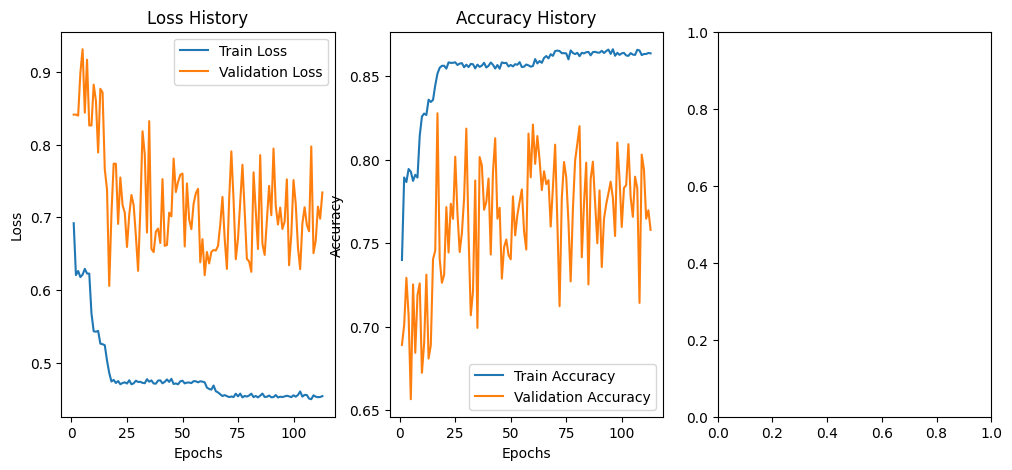

In [18]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 110
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 110
Epoch [110/170] training...


Evaluating on validation set...
Epoch [110/170], Loss: 0.4525, Acc: 0.8650, Val_Loss: 0.6648, Val_Acc: 0.7950, Val_Jaccard: 0.3386
Checkpoint saved at epoch 110
Best model saved as 'best_model.pth'
Epoch [111/170] training...


Evaluating on validation set...
Epoch [111/170], Loss: 0.4478, Acc: 0.8666, Val_Loss: 0.7081, Val_Acc: 0.7785, Val_Jaccard: 0.2961
Checkpoint saved at epoch 111
Best model saved as 'best_model.pth'
Epoch [112/170] training...


Evaluating on validation set...
Epoch [112/170], Loss: 0.4493, Acc: 0.8648, Val_Loss: 0.6475, Val_Acc: 0.8005, Val_Jaccard: 0.3580
Checkpoint saved at epoch 112
Best model saved as 'best_model.pth'
Epoch [113/170] training...


Evaluating on validation set...
Epoch [113/170], Loss: 0.4491, Acc: 0.8662, Val_Loss: 0.7950, Val_Acc: 0.7297, Val_Jaccard: 0.2130
Checkpoint saved at epoch 113
Best model saved as 'best_model.pth'
Epoch [114/170] training...


Evaluating on validation set...
Epoch [114/170], Loss: 0.4495, Acc: 0.8662, Val_Loss: 0.6489, Val_Acc: 0.7976, Val_Jaccard: 0.3557
Checkpoint saved at epoch 114
Best model saved as 'best_model.pth'
Epoch [115/170] training...


Evaluating on validation set...
Epoch [115/170], Loss: 0.4506, Acc: 0.8658, Val_Loss: 0.7619, Val_Acc: 0.7426, Val_Jaccard: 0.2403
Checkpoint saved at epoch 115
Best model saved as 'best_model.pth'
Epoch [116/170] training...


Evaluating on validation set...
Epoch [116/170], Loss: 0.4477, Acc: 0.8666, Val_Loss: 0.7367, Val_Acc: 0.7540, Val_Jaccard: 0.2683
Checkpoint saved at epoch 116
Best model saved as 'best_model.pth'
Epoch [117/170] training...


Evaluating on validation set...
Epoch [117/170], Loss: 0.4481, Acc: 0.8665, Val_Loss: 0.7422, Val_Acc: 0.7578, Val_Jaccard: 0.2668
Checkpoint saved at epoch 117
Best model saved as 'best_model.pth'
Epoch [118/170] training...


Evaluating on validation set...
Epoch [118/170], Loss: 0.4481, Acc: 0.8659, Val_Loss: 0.7093, Val_Acc: 0.7705, Val_Jaccard: 0.2942
Checkpoint saved at epoch 118
Best model saved as 'best_model.pth'
Epoch [119/170] training...


Evaluating on validation set...
Epoch [119/170], Loss: 0.4483, Acc: 0.8656, Val_Loss: 0.6342, Val_Acc: 0.8119, Val_Jaccard: 0.3683
Checkpoint saved at epoch 119
Best model saved as 'best_model.pth'
Epoch [120/170] training...


Evaluating on validation set...
Epoch [120/170], Loss: 0.4484, Acc: 0.8663, Val_Loss: 0.8302, Val_Acc: 0.7093, Val_Jaccard: 0.1763
Checkpoint saved at epoch 120
Best model saved as 'best_model.pth'
Epoch [121/170] training...


Evaluating on validation set...
Epoch [121/170], Loss: 0.4488, Acc: 0.8665, Val_Loss: 0.6494, Val_Acc: 0.8017, Val_Jaccard: 0.3550
Checkpoint saved at epoch 121
Best model saved as 'best_model.pth'
Epoch [122/170] training...


Evaluating on validation set...
Epoch [122/170], Loss: 0.4513, Acc: 0.8640, Val_Loss: 0.7633, Val_Acc: 0.7492, Val_Jaccard: 0.2432
Checkpoint saved at epoch 122
Best model saved as 'best_model.pth'
Epoch [123/170] training...


Evaluating on validation set...
Epoch [123/170], Loss: 0.4498, Acc: 0.8651, Val_Loss: 0.7812, Val_Acc: 0.7405, Val_Jaccard: 0.2229
Checkpoint saved at epoch 123
Best model saved as 'best_model.pth'
Epoch [124/170] training...


Evaluating on validation set...
Epoch [124/170], Loss: 0.4525, Acc: 0.8641, Val_Loss: 0.7573, Val_Acc: 0.7537, Val_Jaccard: 0.2492
Checkpoint saved at epoch 124
Best model saved as 'best_model.pth'
Epoch [125/170] training...


Evaluating on validation set...
Epoch [125/170], Loss: 0.4459, Acc: 0.8674, Val_Loss: 0.7028, Val_Acc: 0.7706, Val_Jaccard: 0.3021
Checkpoint saved at epoch 125
Best model saved as 'best_model.pth'
Epoch [126/170] training...


Evaluating on validation set...
Epoch [126/170], Loss: 0.4502, Acc: 0.8647, Val_Loss: 0.6466, Val_Acc: 0.8071, Val_Jaccard: 0.3585
Checkpoint saved at epoch 126
Best model saved as 'best_model.pth'
Epoch [127/170] training...


Evaluating on validation set...
Epoch [127/170], Loss: 0.4518, Acc: 0.8665, Val_Loss: 0.6430, Val_Acc: 0.8084, Val_Jaccard: 0.3615
Checkpoint saved at epoch 127
Best model saved as 'best_model.pth'
Epoch [128/170] training...


Evaluating on validation set...
Epoch [128/170], Loss: 0.4513, Acc: 0.8641, Val_Loss: 0.8979, Val_Acc: 0.6885, Val_Jaccard: 0.1164
Checkpoint saved at epoch 128
Best model saved as 'best_model.pth'
Epoch [129/170] training...


Evaluating on validation set...
Epoch [129/170], Loss: 0.4502, Acc: 0.8657, Val_Loss: 0.6243, Val_Acc: 0.8153, Val_Jaccard: 0.3825
Checkpoint saved at epoch 129
Best model saved as 'best_model.pth'
Epoch [130/170] training...


Evaluating on validation set...
Epoch [130/170], Loss: 0.4489, Acc: 0.8665, Val_Loss: 0.7056, Val_Acc: 0.7882, Val_Jaccard: 0.2969
Checkpoint saved at epoch 130
Best model saved as 'best_model.pth'
Epoch [131/170] training...


Evaluating on validation set...
Epoch [131/170], Loss: 0.4497, Acc: 0.8665, Val_Loss: 0.7234, Val_Acc: 0.7626, Val_Jaccard: 0.2796
Checkpoint saved at epoch 131
Best model saved as 'best_model.pth'
Epoch [132/170] training...


Evaluating on validation set...
Epoch [132/170], Loss: 0.4485, Acc: 0.8657, Val_Loss: 0.6945, Val_Acc: 0.7759, Val_Jaccard: 0.3078
Checkpoint saved at epoch 132
Best model saved as 'best_model.pth'
Epoch [133/170] training...


Evaluating on validation set...
Epoch [133/170], Loss: 0.4463, Acc: 0.8653, Val_Loss: 0.6498, Val_Acc: 0.8005, Val_Jaccard: 0.3559
Checkpoint saved at epoch 133
Best model saved as 'best_model.pth'
Epoch [134/170] training...


Evaluating on validation set...
Epoch [134/170], Loss: 0.4489, Acc: 0.8672, Val_Loss: 0.6921, Val_Acc: 0.7768, Val_Jaccard: 0.3101
Checkpoint saved at epoch 134
Best model saved as 'best_model.pth'
Epoch [135/170] training...


Evaluating on validation set...
Epoch [135/170], Loss: 0.4490, Acc: 0.8649, Val_Loss: 0.7246, Val_Acc: 0.7725, Val_Jaccard: 0.2798
Checkpoint saved at epoch 135
Best model saved as 'best_model.pth'
Epoch [136/170] training...


Evaluating on validation set...
Epoch [136/170], Loss: 0.4505, Acc: 0.8655, Val_Loss: 0.7009, Val_Acc: 0.7728, Val_Jaccard: 0.3054
Checkpoint saved at epoch 136
Best model saved as 'best_model.pth'
Epoch [137/170] training...


Evaluating on validation set...
Epoch [137/170], Loss: 0.4462, Acc: 0.8692, Val_Loss: 0.6800, Val_Acc: 0.7771, Val_Jaccard: 0.3242
Checkpoint saved at epoch 137
Best model saved as 'best_model.pth'
Epoch [138/170] training...


Evaluating on validation set...
Epoch [138/170], Loss: 0.4506, Acc: 0.8651, Val_Loss: 0.7448, Val_Acc: 0.7528, Val_Jaccard: 0.2621
Checkpoint saved at epoch 138
Best model saved as 'best_model.pth'
Epoch [139/170] training...


Evaluating on validation set...
Epoch [139/170], Loss: 0.4462, Acc: 0.8675, Val_Loss: 0.6700, Val_Acc: 0.7925, Val_Jaccard: 0.3340
Checkpoint saved at epoch 139
Best model saved as 'best_model.pth'
Epoch [140/170] training...


Evaluating on validation set...
Epoch [140/170], Loss: 0.4502, Acc: 0.8656, Val_Loss: 0.6112, Val_Acc: 0.8188, Val_Jaccard: 0.3933
Checkpoint saved at epoch 140
Best model saved as 'best_model.pth'
Epoch [141/170] training...


Evaluating on validation set...
Epoch [141/170], Loss: 0.4496, Acc: 0.8656, Val_Loss: 0.6685, Val_Acc: 0.7935, Val_Jaccard: 0.3346
Checkpoint saved at epoch 141
Best model saved as 'best_model.pth'
Epoch [142/170] training...


Evaluating on validation set...
Epoch [142/170], Loss: 0.4480, Acc: 0.8661, Val_Loss: 0.7012, Val_Acc: 0.7848, Val_Jaccard: 0.3052
Checkpoint saved at epoch 142
Best model saved as 'best_model.pth'
Epoch [143/170] training...


Evaluating on validation set...
Epoch [143/170], Loss: 0.4500, Acc: 0.8646, Val_Loss: 0.6499, Val_Acc: 0.8009, Val_Jaccard: 0.3564
Checkpoint saved at epoch 143
Best model saved as 'best_model.pth'
Epoch [144/170] training...


Evaluating on validation set...
Epoch [144/170], Loss: 0.4490, Acc: 0.8642, Val_Loss: 0.6579, Val_Acc: 0.8044, Val_Jaccard: 0.3494
Checkpoint saved at epoch 144
Best model saved as 'best_model.pth'
Epoch [145/170] training...


Evaluating on validation set...
Epoch [145/170], Loss: 0.4501, Acc: 0.8649, Val_Loss: 0.7378, Val_Acc: 0.7496, Val_Jaccard: 0.2647
Checkpoint saved at epoch 145
Best model saved as 'best_model.pth'
Epoch [146/170] training...


Evaluating on validation set...
Epoch [146/170], Loss: 0.4497, Acc: 0.8653, Val_Loss: 0.7192, Val_Acc: 0.7639, Val_Jaccard: 0.2838
Checkpoint saved at epoch 146
Best model saved as 'best_model.pth'
Epoch [147/170] training...


Evaluating on validation set...
Epoch [147/170], Loss: 0.4512, Acc: 0.8649, Val_Loss: 0.6798, Val_Acc: 0.7926, Val_Jaccard: 0.3247
Checkpoint saved at epoch 147
Best model saved as 'best_model.pth'
Epoch [148/170] training...


Evaluating on validation set...
Epoch [148/170], Loss: 0.4503, Acc: 0.8650, Val_Loss: 0.6612, Val_Acc: 0.7932, Val_Jaccard: 0.3423
Checkpoint saved at epoch 148
Best model saved as 'best_model.pth'
Epoch [149/170] training...


Evaluating on validation set...
Epoch [149/170], Loss: 0.4487, Acc: 0.8660, Val_Loss: 0.6479, Val_Acc: 0.8043, Val_Jaccard: 0.3556
Checkpoint saved at epoch 149
Best model saved as 'best_model.pth'
Epoch [150/170] training...


Evaluating on validation set...
Epoch [150/170], Loss: 0.4491, Acc: 0.8658, Val_Loss: 0.6087, Val_Acc: 0.8213, Val_Jaccard: 0.3955
Checkpoint saved at epoch 150
Best model saved as 'best_model.pth'
Epoch [151/170] training...


Evaluating on validation set...
Epoch [151/170], Loss: 0.4501, Acc: 0.8647, Val_Loss: 0.6678, Val_Acc: 0.7936, Val_Jaccard: 0.3321
Checkpoint saved at epoch 151
Best model saved as 'best_model.pth'
Epoch [152/170] training...


Evaluating on validation set...
Epoch [152/170], Loss: 0.4483, Acc: 0.8665, Val_Loss: 0.6917, Val_Acc: 0.7804, Val_Jaccard: 0.3131
Checkpoint saved at epoch 152
Best model saved as 'best_model.pth'
Epoch [153/170] training...


Evaluating on validation set...
Epoch [153/170], Loss: 0.4485, Acc: 0.8648, Val_Loss: 0.6913, Val_Acc: 0.7794, Val_Jaccard: 0.3158
Checkpoint saved at epoch 153
Best model saved as 'best_model.pth'
Epoch [154/170] training...


Evaluating on validation set...
Epoch [154/170], Loss: 0.4479, Acc: 0.8657, Val_Loss: 0.6764, Val_Acc: 0.7812, Val_Jaccard: 0.3257
Checkpoint saved at epoch 154
Best model saved as 'best_model.pth'
Epoch [155/170] training...


Evaluating on validation set...
Epoch [155/170], Loss: 0.4477, Acc: 0.8655, Val_Loss: 0.6747, Val_Acc: 0.7935, Val_Jaccard: 0.3314
Checkpoint saved at epoch 155
Best model saved as 'best_model.pth'
Epoch [156/170] training...


Evaluating on validation set...
Epoch [156/170], Loss: 0.4487, Acc: 0.8650, Val_Loss: 0.6409, Val_Acc: 0.8058, Val_Jaccard: 0.3618
Checkpoint saved at epoch 156
Best model saved as 'best_model.pth'
Epoch [157/170] training...


Evaluating on validation set...
Epoch [157/170], Loss: 0.4495, Acc: 0.8641, Val_Loss: 0.6969, Val_Acc: 0.7746, Val_Jaccard: 0.3087
Checkpoint saved at epoch 157
Best model saved as 'best_model.pth'
Epoch [158/170] training...


Evaluating on validation set...
Epoch [158/170], Loss: 0.4474, Acc: 0.8666, Val_Loss: 0.6100, Val_Acc: 0.8255, Val_Jaccard: 0.3925
Checkpoint saved at epoch 158
Best model saved as 'best_model.pth'
Epoch [159/170] training...


Evaluating on validation set...
Epoch [159/170], Loss: 0.4465, Acc: 0.8677, Val_Loss: 0.7097, Val_Acc: 0.7693, Val_Jaccard: 0.2938
Checkpoint saved at epoch 159
Best model saved as 'best_model.pth'
Epoch [160/170] training...


Evaluating on validation set...
Epoch [160/170], Loss: 0.4492, Acc: 0.8645, Val_Loss: 0.7013, Val_Acc: 0.7797, Val_Jaccard: 0.3105
Checkpoint saved at epoch 160
Best model saved as 'best_model.pth'
Epoch [161/170] training...


Evaluating on validation set...
Epoch [161/170], Loss: 0.4474, Acc: 0.8660, Val_Loss: 0.6912, Val_Acc: 0.7830, Val_Jaccard: 0.3135
Checkpoint saved at epoch 161
Best model saved as 'best_model.pth'
Epoch [162/170] training...


Evaluating on validation set...
Epoch [162/170], Loss: 0.4488, Acc: 0.8656, Val_Loss: 0.6415, Val_Acc: 0.8038, Val_Jaccard: 0.3636
Checkpoint saved at epoch 162
Best model saved as 'best_model.pth'
Epoch [163/170] training...


Evaluating on validation set...
Epoch [163/170], Loss: 0.4490, Acc: 0.8647, Val_Loss: 0.8397, Val_Acc: 0.6998, Val_Jaccard: 0.1628
Checkpoint saved at epoch 163
Best model saved as 'best_model.pth'
Epoch [164/170] training...


Evaluating on validation set...
Epoch [164/170], Loss: 0.4469, Acc: 0.8648, Val_Loss: 0.6682, Val_Acc: 0.7893, Val_Jaccard: 0.3347
Checkpoint saved at epoch 164
Best model saved as 'best_model.pth'
Epoch [165/170] training...


Evaluating on validation set...
Epoch [165/170], Loss: 0.4483, Acc: 0.8656, Val_Loss: 0.7367, Val_Acc: 0.7628, Val_Jaccard: 0.2696
Checkpoint saved at epoch 165
Best model saved as 'best_model.pth'
Epoch [166/170] training...


Evaluating on validation set...
Epoch [166/170], Loss: 0.4472, Acc: 0.8654, Val_Loss: 0.6565, Val_Acc: 0.7851, Val_Jaccard: 0.3482
Checkpoint saved at epoch 166
Best model saved as 'best_model.pth'
Epoch [167/170] training...


Evaluating on validation set...
Epoch [167/170], Loss: 0.4458, Acc: 0.8671, Val_Loss: 0.6959, Val_Acc: 0.7740, Val_Jaccard: 0.3096
Checkpoint saved at epoch 167
Best model saved as 'best_model.pth'
Epoch [168/170] training...


Evaluating on validation set...
Epoch [168/170], Loss: 0.4490, Acc: 0.8647, Val_Loss: 0.6784, Val_Acc: 0.7805, Val_Jaccard: 0.3262
Checkpoint saved at epoch 168
Best model saved as 'best_model.pth'
Epoch [169/170] training...


Evaluating on validation set...
Epoch [169/170], Loss: 0.4481, Acc: 0.8649, Val_Loss: 0.6400, Val_Acc: 0.8036, Val_Jaccard: 0.3646
Checkpoint saved at epoch 169
Best model saved as 'best_model.pth'
Epoch [170/170] training...


Evaluating on validation set...
Epoch [170/170], Loss: 0.4521, Acc: 0.8641, Val_Loss: 0.6731, Val_Acc: 0.7888, Val_Jaccard: 0.3310
Checkpoint saved at epoch 170
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

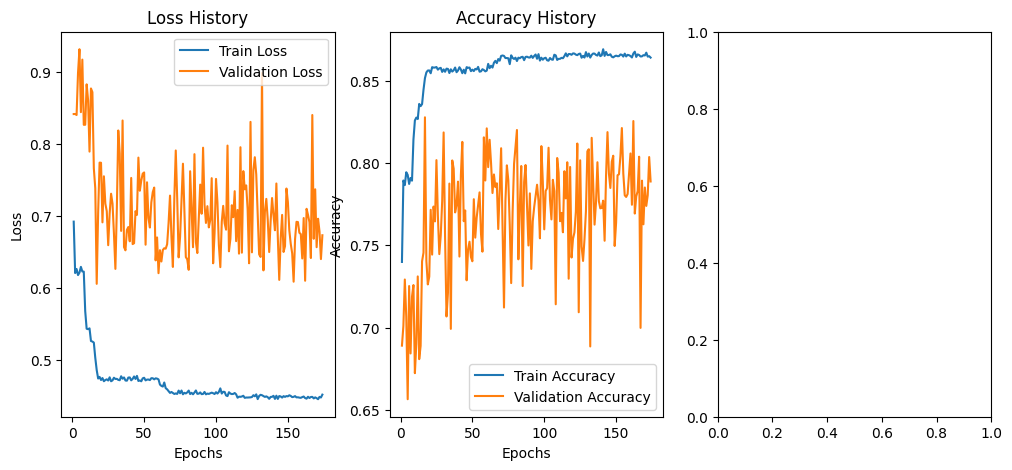

In [19]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 170
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 170
Epoch [170/180] training...


Evaluating on validation set...
Epoch [170/180], Loss: 0.4448, Acc: 0.8673, Val_Loss: 0.7497, Val_Acc: 0.7588, Val_Jaccard: 0.2542
Checkpoint saved at epoch 170
Best model saved as 'best_model.pth'
Epoch [171/180] training...


Evaluating on validation set...
Epoch [171/180], Loss: 0.4441, Acc: 0.8663, Val_Loss: 0.6937, Val_Acc: 0.7773, Val_Jaccard: 0.3091
Checkpoint saved at epoch 171
Best model saved as 'best_model.pth'
Epoch [172/180] training...


Evaluating on validation set...
Epoch [172/180], Loss: 0.4468, Acc: 0.8665, Val_Loss: 0.7100, Val_Acc: 0.7756, Val_Jaccard: 0.2928
Checkpoint saved at epoch 172
Best model saved as 'best_model.pth'
Epoch [173/180] training...


Evaluating on validation set...
Epoch [173/180], Loss: 0.4453, Acc: 0.8669, Val_Loss: 0.6154, Val_Acc: 0.8216, Val_Jaccard: 0.3884
Checkpoint saved at epoch 173
Best model saved as 'best_model.pth'
Epoch [174/180] training...


Evaluating on validation set...
Epoch [174/180], Loss: 0.4459, Acc: 0.8657, Val_Loss: 0.7391, Val_Acc: 0.7584, Val_Jaccard: 0.2655
Checkpoint saved at epoch 174
Best model saved as 'best_model.pth'
Epoch [175/180] training...


Evaluating on validation set...
Epoch [175/180], Loss: 0.4448, Acc: 0.8684, Val_Loss: 0.8235, Val_Acc: 0.7363, Val_Jaccard: 0.1802
Checkpoint saved at epoch 175
Best model saved as 'best_model.pth'
Epoch [176/180] training...


Evaluating on validation set...
Epoch [176/180], Loss: 0.4471, Acc: 0.8664, Val_Loss: 0.6951, Val_Acc: 0.7847, Val_Jaccard: 0.3091
Checkpoint saved at epoch 176
Best model saved as 'best_model.pth'
Epoch [177/180] training...


Evaluating on validation set...
Epoch [177/180], Loss: 0.4448, Acc: 0.8679, Val_Loss: 0.6528, Val_Acc: 0.8112, Val_Jaccard: 0.3509
Checkpoint saved at epoch 177
Best model saved as 'best_model.pth'
Epoch [178/180] training...


Evaluating on validation set...
Epoch [178/180], Loss: 0.4456, Acc: 0.8686, Val_Loss: 0.7060, Val_Acc: 0.7600, Val_Jaccard: 0.2976
Checkpoint saved at epoch 178
Best model saved as 'best_model.pth'
Epoch [179/180] training...


Evaluating on validation set...
Epoch [179/180], Loss: 0.4428, Acc: 0.8691, Val_Loss: 0.6573, Val_Acc: 0.7920, Val_Jaccard: 0.3451
Checkpoint saved at epoch 179
Best model saved as 'best_model.pth'
Epoch [180/180] training...


Evaluating on validation set...
Epoch [180/180], Loss: 0.4438, Acc: 0.8673, Val_Loss: 0.6646, Val_Acc: 0.7915, Val_Jaccard: 0.3387
Checkpoint saved at epoch 180
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

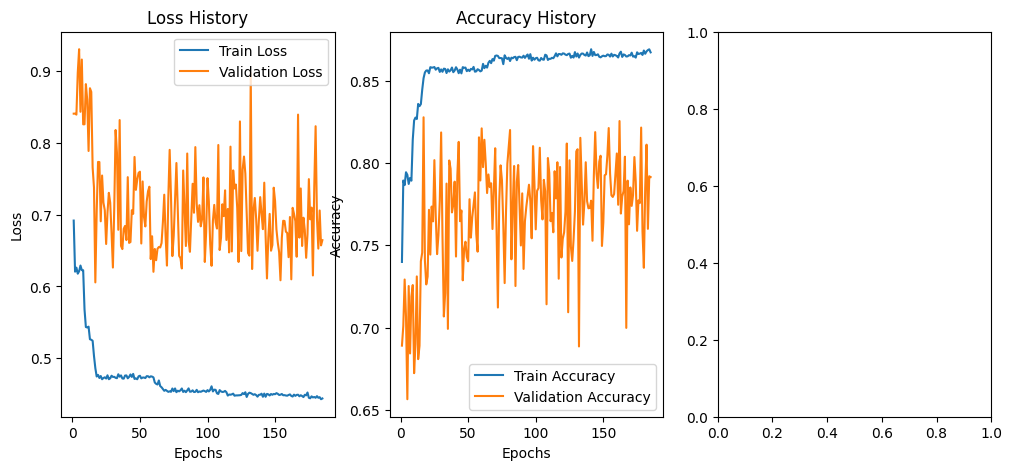

In [20]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 180
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 180
Epoch [180/190] training...



Evaluating on validation set...
Epoch [180/190], Loss: 0.4424, Acc: 0.8687, Val_Loss: 0.7275, Val_Acc: 0.7638, Val_Jaccard: 0.2796
New best model with val_jaccard: 0.2796
Checkpoint saved at epoch 180
Best model saved as 'best_model.pth'
Epoch [181/190] training...



Evaluating on validation set...
Epoch [181/190], Loss: 0.4375, Acc: 0.8714, Val_Loss: 0.6789, Val_Acc: 0.7930, Val_Jaccard: 0.3238
New best model with val_jaccard: 0.3238
Checkpoint saved at epoch 181
Best model saved as 'best_model.pth'
Epoch [182/190] training...



Evaluating on validation set...
Epoch [182/190], Loss: 0.4364, Acc: 0.8713, Val_Loss: 0.6450, Val_Acc: 0.8130, Val_Jaccard: 0.3600
New best model with val_jaccard: 0.3600
Checkpoint saved at epoch 182
Best model saved as 'best_model.pth'
Epoch [183/190] training...



Evaluating on validation set...
Epoch [183/190], Loss: 0.4303, Acc: 0.8734, Val_Loss: 0.6563, Val_Acc: 0.8039, Val_Jaccard: 0.3488
New best model with val_jaccard: 0.3488
Checkpoint saved at epoch 183
Best model saved as 'best_model.pth'
Epoch [184/190] training...



Evaluating on validation set...
Epoch [184/190], Loss: 0.4280, Acc: 0.8755, Val_Loss: 0.6232, Val_Acc: 0.8257, Val_Jaccard: 0.3813
New best model with val_jaccard: 0.3813
Checkpoint saved at epoch 184
Best model saved as 'best_model.pth'
Epoch [185/190] training...



Evaluating on validation set...
Epoch [185/190], Loss: 0.3761, Acc: 0.8964, Val_Loss: 0.6467, Val_Acc: 0.8173, Val_Jaccard: 0.3615
New best model with val_jaccard: 0.3615
Checkpoint saved at epoch 185
Best model saved as 'best_model.pth'
Epoch [186/190] training...



Evaluating on validation set...
Epoch [186/190], Loss: 0.3430, Acc: 0.9090, Val_Loss: 0.6705, Val_Acc: 0.8247, Val_Jaccard: 0.3459
New best model with val_jaccard: 0.3459
Checkpoint saved at epoch 186
Best model saved as 'best_model.pth'
Epoch [187/190] training...



Evaluating on validation set...
Epoch [187/190], Loss: 0.3316, Acc: 0.9112, Val_Loss: 0.7151, Val_Acc: 0.7955, Val_Jaccard: 0.2907
New best model with val_jaccard: 0.2907
Checkpoint saved at epoch 187
Best model saved as 'best_model.pth'
Epoch [188/190] training...



Evaluating on validation set...
Epoch [188/190], Loss: 0.3232, Acc: 0.9135, Val_Loss: 0.6728, Val_Acc: 0.8117, Val_Jaccard: 0.3313
New best model with val_jaccard: 0.3313
Checkpoint saved at epoch 188
Best model saved as 'best_model.pth'
Epoch [189/190] training...



Evaluating on validation set...
Epoch [189/190], Loss: 0.3158, Acc: 0.9155, Val_Loss: 0.6494, Val_Acc: 0.8227, Val_Jaccard: 0.3581
New best model with val_jaccard: 0.3581
Checkpoint saved at epoch 189
Best model saved as 'best_model.pth'
Epoch [190/190] training...



Evaluating on validation set...
Epoch [190/190], Loss: 0.3131, Acc: 0.9167, Val_Loss: 0.6260, Val_Acc: 0.8353, Val_Jaccard: 0.3808
New best model with val_jaccard: 0.3808
Checkpoint saved at epoch 190
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

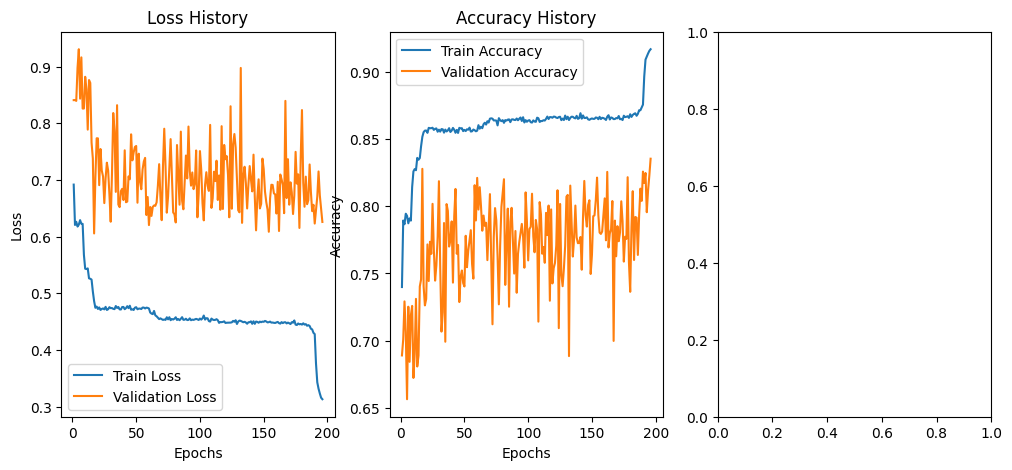

In [23]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 190
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 190
Epoch [190/220] training...



Evaluating on validation set...
Epoch [190/220], Loss: 0.3119, Acc: 0.9169, Val_Loss: 0.6640, Val_Acc: 0.8186, Val_Jaccard: 0.3429
New best model with val_accuracy: 0.8186
Checkpoint saved at epoch 190
Best model saved as 'best_model.pth'
Epoch [191/220] training...



Evaluating on validation set...
Epoch [191/220], Loss: 0.3072, Acc: 0.9177, Val_Loss: 0.6194, Val_Acc: 0.8285, Val_Jaccard: 0.3864
New best model with val_accuracy: 0.8285
Checkpoint saved at epoch 191
Best model saved as 'best_model.pth'
Epoch [192/220] training...



Evaluating on validation set...
Epoch [192/220], Loss: 0.3032, Acc: 0.9191, Val_Loss: 0.6115, Val_Acc: 0.8375, Val_Jaccard: 0.3918
New best model with val_accuracy: 0.8375
Checkpoint saved at epoch 192
Best model saved as 'best_model.pth'
Epoch [193/220] training...



Evaluating on validation set...
Epoch [193/220], Loss: 0.3000, Acc: 0.9199, Val_Loss: 0.5749, Val_Acc: 0.8441, Val_Jaccard: 0.4293
New best model with val_accuracy: 0.8441
Checkpoint saved at epoch 193
Best model saved as 'best_model.pth'
Epoch [194/220] training...



Evaluating on validation set...
Epoch [194/220], Loss: 0.2972, Acc: 0.9206, Val_Loss: 0.6521, Val_Acc: 0.8222, Val_Jaccard: 0.3544
Checkpoint saved at epoch 194
Best model saved as 'best_model.pth'
Epoch [195/220] training...



Evaluating on validation set...
Epoch [195/220], Loss: 0.2956, Acc: 0.9211, Val_Loss: 0.6073, Val_Acc: 0.8308, Val_Jaccard: 0.3980
Checkpoint saved at epoch 195
Best model saved as 'best_model.pth'
Epoch [196/220] training...



Evaluating on validation set...
Epoch [196/220], Loss: 0.2954, Acc: 0.9214, Val_Loss: 0.6794, Val_Acc: 0.8033, Val_Jaccard: 0.3263
Checkpoint saved at epoch 196
Best model saved as 'best_model.pth'
Epoch [197/220] training...



Evaluating on validation set...
Epoch [197/220], Loss: 0.2963, Acc: 0.9215, Val_Loss: 0.5765, Val_Acc: 0.8452, Val_Jaccard: 0.4280
New best model with val_accuracy: 0.8452
Checkpoint saved at epoch 197
Best model saved as 'best_model.pth'
Epoch [198/220] training...



Evaluating on validation set...
Epoch [198/220], Loss: 0.2961, Acc: 0.9200, Val_Loss: 0.6776, Val_Acc: 0.8026, Val_Jaccard: 0.3277
Checkpoint saved at epoch 198
Best model saved as 'best_model.pth'
Epoch [199/220] training...



Evaluating on validation set...
Epoch [199/220], Loss: 0.2919, Acc: 0.9215, Val_Loss: 0.6101, Val_Acc: 0.8327, Val_Jaccard: 0.3943
Checkpoint saved at epoch 199
Best model saved as 'best_model.pth'
Epoch [200/220] training...



Evaluating on validation set...
Epoch [200/220], Loss: 0.2949, Acc: 0.9217, Val_Loss: 0.6678, Val_Acc: 0.8195, Val_Jaccard: 0.3403
Checkpoint saved at epoch 200
Best model saved as 'best_model.pth'
Epoch [201/220] training...



Evaluating on validation set...
Epoch [201/220], Loss: 0.2893, Acc: 0.9234, Val_Loss: 0.6432, Val_Acc: 0.8190, Val_Jaccard: 0.3613
Checkpoint saved at epoch 201
Best model saved as 'best_model.pth'
Epoch [202/220] training...



Evaluating on validation set...
Epoch [202/220], Loss: 0.2924, Acc: 0.9226, Val_Loss: 0.6079, Val_Acc: 0.8350, Val_Jaccard: 0.3971
Checkpoint saved at epoch 202
Best model saved as 'best_model.pth'
Epoch [203/220] training...



Evaluating on validation set...
Epoch [203/220], Loss: 0.2907, Acc: 0.9224, Val_Loss: 0.6462, Val_Acc: 0.8193, Val_Jaccard: 0.3634
Checkpoint saved at epoch 203
Best model saved as 'best_model.pth'
Epoch [204/220] training...



Evaluating on validation set...
Epoch [204/220], Loss: 0.2905, Acc: 0.9229, Val_Loss: 0.6769, Val_Acc: 0.8174, Val_Jaccard: 0.3338
Checkpoint saved at epoch 204
Best model saved as 'best_model.pth'
Epoch [205/220] training...



Evaluating on validation set...
Epoch [205/220], Loss: 0.2902, Acc: 0.9226, Val_Loss: 0.6198, Val_Acc: 0.8231, Val_Jaccard: 0.3868
Checkpoint saved at epoch 205
Best model saved as 'best_model.pth'
Epoch [206/220] training...



Evaluating on validation set...
Epoch [206/220], Loss: 0.2899, Acc: 0.9230, Val_Loss: 0.6707, Val_Acc: 0.8067, Val_Jaccard: 0.3346
Checkpoint saved at epoch 206
Best model saved as 'best_model.pth'
Epoch [207/220] training...



Evaluating on validation set...
Epoch [207/220], Loss: 0.2896, Acc: 0.9232, Val_Loss: 0.6151, Val_Acc: 0.8302, Val_Jaccard: 0.3881
Checkpoint saved at epoch 207
Best model saved as 'best_model.pth'
Epoch [208/220] training...



Evaluating on validation set...
Epoch [208/220], Loss: 0.2921, Acc: 0.9219, Val_Loss: 0.5902, Val_Acc: 0.8467, Val_Jaccard: 0.4152
New best model with val_accuracy: 0.8467
Checkpoint saved at epoch 208
Best model saved as 'best_model.pth'
Epoch [209/220] training...



Evaluating on validation set...
Epoch [209/220], Loss: 0.2877, Acc: 0.9237, Val_Loss: 0.6255, Val_Acc: 0.8293, Val_Jaccard: 0.3812
Checkpoint saved at epoch 209
Best model saved as 'best_model.pth'
Epoch [210/220] training...



Evaluating on validation set...
Epoch [210/220], Loss: 0.2910, Acc: 0.9228, Val_Loss: 0.6459, Val_Acc: 0.8205, Val_Jaccard: 0.3600
Checkpoint saved at epoch 210
Best model saved as 'best_model.pth'
Epoch [211/220] training...



Evaluating on validation set...
Epoch [211/220], Loss: 0.2938, Acc: 0.9218, Val_Loss: 0.5907, Val_Acc: 0.8415, Val_Jaccard: 0.4126
Checkpoint saved at epoch 211
Best model saved as 'best_model.pth'
Epoch [212/220] training...



Evaluating on validation set...
Epoch [212/220], Loss: 0.2870, Acc: 0.9238, Val_Loss: 0.5995, Val_Acc: 0.8367, Val_Jaccard: 0.4066
Checkpoint saved at epoch 212
Best model saved as 'best_model.pth'
Epoch [213/220] training...



Evaluating on validation set...
Epoch [213/220], Loss: 0.2906, Acc: 0.9228, Val_Loss: 0.6415, Val_Acc: 0.8202, Val_Jaccard: 0.3629
Checkpoint saved at epoch 213
Best model saved as 'best_model.pth'
Epoch [214/220] training...



Evaluating on validation set...
Epoch [214/220], Loss: 0.2875, Acc: 0.9241, Val_Loss: 0.6627, Val_Acc: 0.8181, Val_Jaccard: 0.3437
Checkpoint saved at epoch 214
Best model saved as 'best_model.pth'
Epoch [215/220] training...



Evaluating on validation set...
Epoch [215/220], Loss: 0.2901, Acc: 0.9231, Val_Loss: 0.6649, Val_Acc: 0.8187, Val_Jaccard: 0.3407
Checkpoint saved at epoch 215
Best model saved as 'best_model.pth'
Epoch [216/220] training...



Evaluating on validation set...
Epoch [216/220], Loss: 0.2863, Acc: 0.9234, Val_Loss: 0.6534, Val_Acc: 0.8227, Val_Jaccard: 0.3523
Checkpoint saved at epoch 216
Best model saved as 'best_model.pth'
Epoch [217/220] training...



Evaluating on validation set...
Epoch [217/220], Loss: 0.2899, Acc: 0.9228, Val_Loss: 0.6864, Val_Acc: 0.8146, Val_Jaccard: 0.3267
Checkpoint saved at epoch 217
Best model saved as 'best_model.pth'
Epoch [218/220] training...



Evaluating on validation set...
Epoch [218/220], Loss: 0.2916, Acc: 0.9224, Val_Loss: 0.6604, Val_Acc: 0.8064, Val_Jaccard: 0.3460
Checkpoint saved at epoch 218
Best model saved as 'best_model.pth'
Epoch [219/220] training...



Evaluating on validation set...
Epoch [219/220], Loss: 0.2926, Acc: 0.9224, Val_Loss: 0.6229, Val_Acc: 0.8325, Val_Jaccard: 0.3825
Checkpoint saved at epoch 219
Best model saved as 'best_model.pth'
Epoch [220/220] training...



Evaluating on validation set...
Epoch [220/220], Loss: 0.2896, Acc: 0.9236, Val_Loss: 0.5879, Val_Acc: 0.8464, Val_Jaccard: 0.4160
Checkpoint saved at epoch 220
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

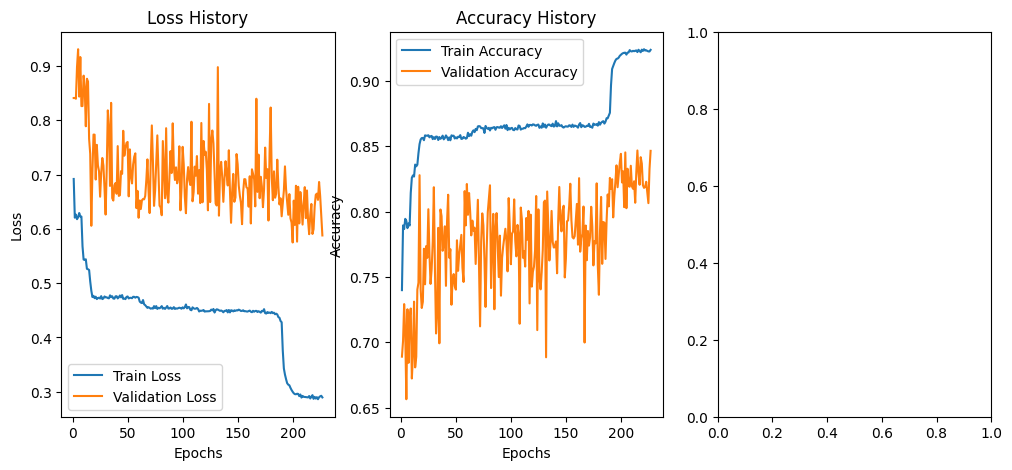

In [25]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 220
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 220
Epoch [220/240] training...



Evaluating on validation set...
Epoch [220/240], Loss: 0.2861, Acc: 0.9244, Val_Loss: 0.6187, Val_Acc: 0.8307, Val_Jaccard: 0.3868
Checkpoint saved at epoch 220
Best model saved as 'best_model.pth'
Epoch [221/240] training...



Evaluating on validation set...
Epoch [221/240], Loss: 0.2849, Acc: 0.9249, Val_Loss: 0.6554, Val_Acc: 0.8346, Val_Jaccard: 0.3589
Checkpoint saved at epoch 221
Best model saved as 'best_model.pth'
Epoch [222/240] training...



Evaluating on validation set...
Epoch [222/240], Loss: 0.2854, Acc: 0.9242, Val_Loss: 0.6653, Val_Acc: 0.8107, Val_Jaccard: 0.3431
Checkpoint saved at epoch 222
Best model saved as 'best_model.pth'
Epoch [223/240] training...



Evaluating on validation set...
Epoch [223/240], Loss: 0.2869, Acc: 0.9243, Val_Loss: 0.6187, Val_Acc: 0.8338, Val_Jaccard: 0.3912
Checkpoint saved at epoch 223
Best model saved as 'best_model.pth'
Epoch [224/240] training...



Evaluating on validation set...
Epoch [224/240], Loss: 0.2858, Acc: 0.9244, Val_Loss: 0.6859, Val_Acc: 0.8178, Val_Jaccard: 0.3273
Checkpoint saved at epoch 224
Best model saved as 'best_model.pth'
Epoch [225/240] training...



Evaluating on validation set...
Epoch [225/240], Loss: 0.2835, Acc: 0.9247, Val_Loss: 0.6846, Val_Acc: 0.8077, Val_Jaccard: 0.3250
Checkpoint saved at epoch 225
Best model saved as 'best_model.pth'
Epoch [226/240] training...



Evaluating on validation set...
Epoch [226/240], Loss: 0.2832, Acc: 0.9254, Val_Loss: 0.6541, Val_Acc: 0.8229, Val_Jaccard: 0.3517
Checkpoint saved at epoch 226
Best model saved as 'best_model.pth'
Epoch [227/240] training...



Evaluating on validation set...
Epoch [227/240], Loss: 0.2867, Acc: 0.9237, Val_Loss: 0.6451, Val_Acc: 0.8197, Val_Jaccard: 0.3675
Checkpoint saved at epoch 227
Best model saved as 'best_model.pth'
Epoch [228/240] training...



Evaluating on validation set...
Epoch [228/240], Loss: 0.2873, Acc: 0.9241, Val_Loss: 0.6633, Val_Acc: 0.8139, Val_Jaccard: 0.3459
Checkpoint saved at epoch 228
Best model saved as 'best_model.pth'
Epoch [229/240] training...



Evaluating on validation set...
Epoch [229/240], Loss: 0.2835, Acc: 0.9246, Val_Loss: 0.6287, Val_Acc: 0.8279, Val_Jaccard: 0.3793
Checkpoint saved at epoch 229
Best model saved as 'best_model.pth'
Epoch [230/240] training...



Evaluating on validation set...
Epoch [230/240], Loss: 0.2861, Acc: 0.9245, Val_Loss: 0.6682, Val_Acc: 0.8187, Val_Jaccard: 0.3368
Checkpoint saved at epoch 230
Best model saved as 'best_model.pth'
Epoch [231/240] training...



Evaluating on validation set...
Epoch [231/240], Loss: 0.2847, Acc: 0.9247, Val_Loss: 0.6789, Val_Acc: 0.8092, Val_Jaccard: 0.3321
Checkpoint saved at epoch 231
Best model saved as 'best_model.pth'
Epoch [232/240] training...



Evaluating on validation set...
Epoch [232/240], Loss: 0.2855, Acc: 0.9244, Val_Loss: 0.6127, Val_Acc: 0.8328, Val_Jaccard: 0.3918
Checkpoint saved at epoch 232
Best model saved as 'best_model.pth'
Epoch [233/240] training...



Evaluating on validation set...
Epoch [233/240], Loss: 0.2855, Acc: 0.9247, Val_Loss: 0.6638, Val_Acc: 0.8125, Val_Jaccard: 0.3384
Checkpoint saved at epoch 233
Best model saved as 'best_model.pth'
Epoch [234/240] training...



Evaluating on validation set...
Epoch [234/240], Loss: 0.2804, Acc: 0.9248, Val_Loss: 0.6184, Val_Acc: 0.8342, Val_Jaccard: 0.3878
Checkpoint saved at epoch 234
Best model saved as 'best_model.pth'
Epoch [235/240] training...



Evaluating on validation set...
Epoch [235/240], Loss: 0.2864, Acc: 0.9235, Val_Loss: 0.6538, Val_Acc: 0.8222, Val_Jaccard: 0.3535
Checkpoint saved at epoch 235
Best model saved as 'best_model.pth'
Epoch [236/240] training...



Evaluating on validation set...
Epoch [236/240], Loss: 0.2871, Acc: 0.9244, Val_Loss: 0.6239, Val_Acc: 0.8322, Val_Jaccard: 0.3826
Checkpoint saved at epoch 236
Best model saved as 'best_model.pth'
Epoch [237/240] training...



Evaluating on validation set...
Epoch [237/240], Loss: 0.2848, Acc: 0.9250, Val_Loss: 0.6586, Val_Acc: 0.8233, Val_Jaccard: 0.3480
Checkpoint saved at epoch 237
Best model saved as 'best_model.pth'
Epoch [238/240] training...



Evaluating on validation set...
Epoch [238/240], Loss: 0.2834, Acc: 0.9240, Val_Loss: 0.6523, Val_Acc: 0.8238, Val_Jaccard: 0.3573
Checkpoint saved at epoch 238
Best model saved as 'best_model.pth'
Epoch [239/240] training...



Evaluating on validation set...
Epoch [239/240], Loss: 0.2847, Acc: 0.9246, Val_Loss: 0.6312, Val_Acc: 0.8300, Val_Jaccard: 0.3768
Checkpoint saved at epoch 239
Best model saved as 'best_model.pth'
Epoch [240/240] training...



Evaluating on validation set...
Epoch [240/240], Loss: 0.2856, Acc: 0.9248, Val_Loss: 0.6989, Val_Acc: 0.8067, Val_Jaccard: 0.3099
Checkpoint saved at epoch 240
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

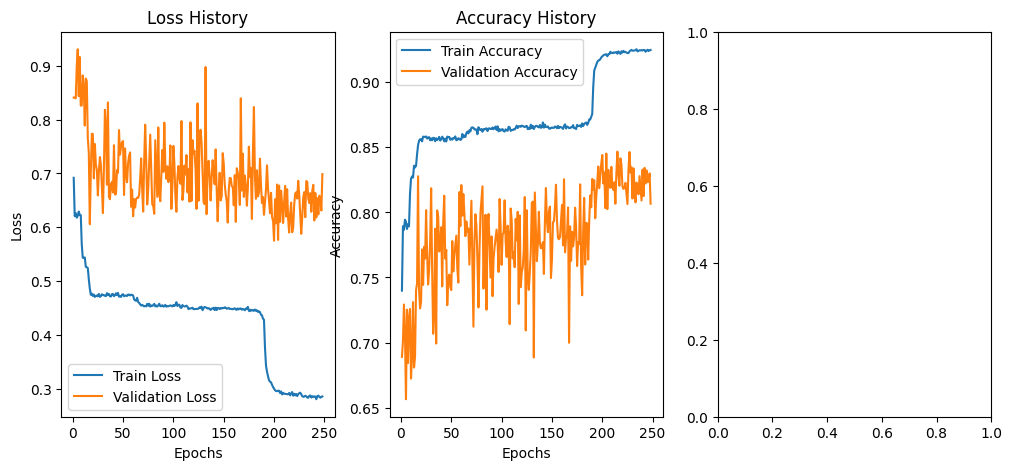

In [26]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 240
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 240
Epoch [240/250] training...



Evaluating on validation set...
Epoch [240/250], Loss: 0.2867, Acc: 0.9236, Val_Loss: 0.6219, Val_Acc: 0.8356, Val_Jaccard: 0.3851
Checkpoint saved at epoch 240
Best model saved as 'best_model.pth'
Epoch [241/250] training...



Evaluating on validation set...
Epoch [241/250], Loss: 0.2847, Acc: 0.9244, Val_Loss: 0.7110, Val_Acc: 0.8117, Val_Jaccard: 0.3087
Checkpoint saved at epoch 241
Best model saved as 'best_model.pth'
Epoch [242/250] training...



Evaluating on validation set...
Epoch [242/250], Loss: 0.2822, Acc: 0.9259, Val_Loss: 0.5918, Val_Acc: 0.8457, Val_Jaccard: 0.4146
Checkpoint saved at epoch 242
Best model saved as 'best_model.pth'
Epoch [243/250] training...



Evaluating on validation set...
Epoch [243/250], Loss: 0.2806, Acc: 0.9263, Val_Loss: 0.6065, Val_Acc: 0.8347, Val_Jaccard: 0.3987
Checkpoint saved at epoch 243
Best model saved as 'best_model.pth'
Epoch [244/250] training...



Evaluating on validation set...
Epoch [244/250], Loss: 0.2857, Acc: 0.9242, Val_Loss: 0.6028, Val_Acc: 0.8393, Val_Jaccard: 0.3996
Checkpoint saved at epoch 244
Best model saved as 'best_model.pth'
Epoch [245/250] training...



Evaluating on validation set...
Epoch [245/250], Loss: 0.2805, Acc: 0.9260, Val_Loss: 0.6435, Val_Acc: 0.8215, Val_Jaccard: 0.3624
Checkpoint saved at epoch 245
Best model saved as 'best_model.pth'
Epoch [246/250] training...



Evaluating on validation set...
Epoch [246/250], Loss: 0.2839, Acc: 0.9245, Val_Loss: 0.6539, Val_Acc: 0.8210, Val_Jaccard: 0.3558
Checkpoint saved at epoch 246
Best model saved as 'best_model.pth'
Epoch [247/250] training...



Evaluating on validation set...
Epoch [247/250], Loss: 0.2842, Acc: 0.9256, Val_Loss: 0.6144, Val_Acc: 0.8341, Val_Jaccard: 0.3902
Checkpoint saved at epoch 247
Best model saved as 'best_model.pth'
Epoch [248/250] training...



Evaluating on validation set...
Epoch [248/250], Loss: 0.2845, Acc: 0.9248, Val_Loss: 0.6470, Val_Acc: 0.8219, Val_Jaccard: 0.3571
Checkpoint saved at epoch 248
Best model saved as 'best_model.pth'
Epoch [249/250] training...



Evaluating on validation set...
Epoch [249/250], Loss: 0.2829, Acc: 0.9245, Val_Loss: 0.6502, Val_Acc: 0.8045, Val_Jaccard: 0.3531
Checkpoint saved at epoch 249
Best model saved as 'best_model.pth'
Epoch [250/250] training...



Evaluating on validation set...
Epoch [250/250], Loss: 0.2829, Acc: 0.9260, Val_Loss: 0.6931, Val_Acc: 0.7958, Val_Jaccard: 0.3172
Checkpoint saved at epoch 250
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

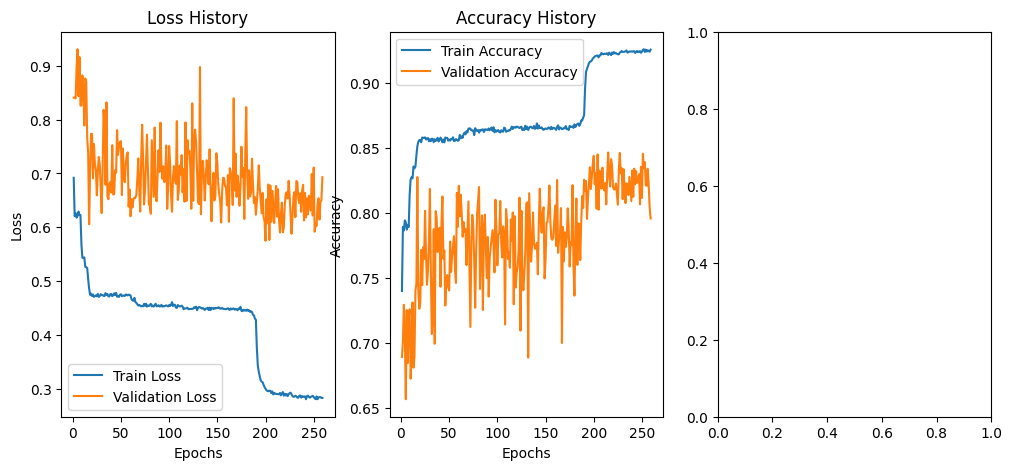

In [27]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 250
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.3)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 250
Epoch [250/300] training...



Evaluating on validation set...
Epoch [250/300], Loss: 0.2818, Acc: 0.9254, Val_Loss: 0.6471, Val_Acc: 0.8220, Val_Jaccard: 0.3583
Checkpoint saved at epoch 250
Best model saved as 'best_model.pth'
Epoch [251/300] training...



Evaluating on validation set...
Epoch [251/300], Loss: 0.2774, Acc: 0.9261, Val_Loss: 0.7268, Val_Acc: 0.8182, Val_Jaccard: 0.2967
Checkpoint saved at epoch 251
Best model saved as 'best_model.pth'
Epoch [252/300] training...



Evaluating on validation set...
Epoch [252/300], Loss: 0.2829, Acc: 0.9255, Val_Loss: 0.6483, Val_Acc: 0.8178, Val_Jaccard: 0.3583
Checkpoint saved at epoch 252
Best model saved as 'best_model.pth'
Epoch [253/300] training...



Evaluating on validation set...
Epoch [253/300], Loss: 0.2797, Acc: 0.9261, Val_Loss: 0.6662, Val_Acc: 0.8252, Val_Jaccard: 0.3417
Checkpoint saved at epoch 253
Best model saved as 'best_model.pth'
Epoch [254/300] training...



Evaluating on validation set...
Epoch [254/300], Loss: 0.2849, Acc: 0.9241, Val_Loss: 0.6028, Val_Acc: 0.8399, Val_Jaccard: 0.4044
Checkpoint saved at epoch 254
Best model saved as 'best_model.pth'
Epoch [255/300] training...



Evaluating on validation set...
Epoch [255/300], Loss: 0.2809, Acc: 0.9253, Val_Loss: 0.7644, Val_Acc: 0.7922, Val_Jaccard: 0.2439
Checkpoint saved at epoch 255
Best model saved as 'best_model.pth'
Epoch [256/300] training...



Evaluating on validation set...
Epoch [256/300], Loss: 0.2796, Acc: 0.9261, Val_Loss: 0.7681, Val_Acc: 0.7834, Val_Jaccard: 0.2537
Checkpoint saved at epoch 256
Best model saved as 'best_model.pth'
Epoch [257/300] training...



Evaluating on validation set...
Epoch [257/300], Loss: 0.2791, Acc: 0.9263, Val_Loss: 0.6229, Val_Acc: 0.8320, Val_Jaccard: 0.3853
Checkpoint saved at epoch 257
Best model saved as 'best_model.pth'
Epoch [258/300] training...



Evaluating on validation set...
Epoch [258/300], Loss: 0.2861, Acc: 0.9233, Val_Loss: 0.6073, Val_Acc: 0.8396, Val_Jaccard: 0.3992
Checkpoint saved at epoch 258
Best model saved as 'best_model.pth'
Epoch [259/300] training...



Evaluating on validation set...
Epoch [259/300], Loss: 0.2775, Acc: 0.9269, Val_Loss: 0.6182, Val_Acc: 0.8376, Val_Jaccard: 0.3879
Checkpoint saved at epoch 259
Best model saved as 'best_model.pth'
Epoch [260/300] training...



Evaluating on validation set...
Epoch [260/300], Loss: 0.2829, Acc: 0.9254, Val_Loss: 0.6999, Val_Acc: 0.8006, Val_Jaccard: 0.3076
Checkpoint saved at epoch 260
Best model saved as 'best_model.pth'
Epoch [261/300] training...



Evaluating on validation set...
Epoch [261/300], Loss: 0.2835, Acc: 0.9247, Val_Loss: 0.6677, Val_Acc: 0.8155, Val_Jaccard: 0.3439
Checkpoint saved at epoch 261
Best model saved as 'best_model.pth'
Epoch [262/300] training...



Evaluating on validation set...
Epoch [262/300], Loss: 0.2833, Acc: 0.9244, Val_Loss: 0.6471, Val_Acc: 0.8224, Val_Jaccard: 0.3599
Checkpoint saved at epoch 262
Best model saved as 'best_model.pth'
Epoch [263/300] training...



Evaluating on validation set...
Epoch [263/300], Loss: 0.2793, Acc: 0.9257, Val_Loss: 0.6963, Val_Acc: 0.8072, Val_Jaccard: 0.3072
Checkpoint saved at epoch 263
Best model saved as 'best_model.pth'
Epoch [264/300] training...



Evaluating on validation set...
Epoch [264/300], Loss: 0.2800, Acc: 0.9261, Val_Loss: 0.5992, Val_Acc: 0.8394, Val_Jaccard: 0.4083
Checkpoint saved at epoch 264
Best model saved as 'best_model.pth'
Epoch [265/300] training...



Evaluating on validation set...
Epoch [265/300], Loss: 0.2788, Acc: 0.9255, Val_Loss: 0.6219, Val_Acc: 0.8260, Val_Jaccard: 0.3873
Checkpoint saved at epoch 265
Best model saved as 'best_model.pth'
Epoch [266/300] training...



Evaluating on validation set...
Epoch [266/300], Loss: 0.2790, Acc: 0.9259, Val_Loss: 0.6744, Val_Acc: 0.8062, Val_Jaccard: 0.3337
Checkpoint saved at epoch 266
Best model saved as 'best_model.pth'
Epoch [267/300] training...



Evaluating on validation set...
Epoch [267/300], Loss: 0.2814, Acc: 0.9256, Val_Loss: 0.5756, Val_Acc: 0.8519, Val_Jaccard: 0.4291
New best model with val_accuracy: 0.8519
Checkpoint saved at epoch 267
Best model saved as 'best_model.pth'
Epoch [268/300] training...



Evaluating on validation set...
Epoch [268/300], Loss: 0.2862, Acc: 0.9245, Val_Loss: 0.6182, Val_Acc: 0.8320, Val_Jaccard: 0.3850
Checkpoint saved at epoch 268
Best model saved as 'best_model.pth'
Epoch [269/300] training...



Evaluating on validation set...
Epoch [269/300], Loss: 0.2794, Acc: 0.9264, Val_Loss: 0.6449, Val_Acc: 0.8243, Val_Jaccard: 0.3614
Checkpoint saved at epoch 269
Best model saved as 'best_model.pth'
Epoch [270/300] training...



Evaluating on validation set...
Epoch [270/300], Loss: 0.2785, Acc: 0.9264, Val_Loss: 0.6213, Val_Acc: 0.8396, Val_Jaccard: 0.3867
Checkpoint saved at epoch 270
Best model saved as 'best_model.pth'
Epoch [271/300] training...



Evaluating on validation set...
Epoch [271/300], Loss: 0.2774, Acc: 0.9272, Val_Loss: 0.6392, Val_Acc: 0.8258, Val_Jaccard: 0.3660
Checkpoint saved at epoch 271
Best model saved as 'best_model.pth'
Epoch [272/300] training...



Evaluating on validation set...
Epoch [272/300], Loss: 0.2790, Acc: 0.9261, Val_Loss: 0.6307, Val_Acc: 0.8280, Val_Jaccard: 0.3789
Checkpoint saved at epoch 272
Best model saved as 'best_model.pth'
Epoch [273/300] training...



Evaluating on validation set...
Epoch [273/300], Loss: 0.2751, Acc: 0.9277, Val_Loss: 0.5789, Val_Acc: 0.8512, Val_Jaccard: 0.4275
Checkpoint saved at epoch 273
Best model saved as 'best_model.pth'
Epoch [274/300] training...



Evaluating on validation set...
Epoch [274/300], Loss: 0.2768, Acc: 0.9268, Val_Loss: 0.7050, Val_Acc: 0.8134, Val_Jaccard: 0.3059
Checkpoint saved at epoch 274
Best model saved as 'best_model.pth'
Epoch [275/300] training...



Evaluating on validation set...
Epoch [275/300], Loss: 0.2785, Acc: 0.9264, Val_Loss: 0.6777, Val_Acc: 0.8193, Val_Jaccard: 0.3296
Checkpoint saved at epoch 275
Best model saved as 'best_model.pth'
Epoch [276/300] training...



Evaluating on validation set...
Epoch [276/300], Loss: 0.2768, Acc: 0.9273, Val_Loss: 0.6638, Val_Acc: 0.8201, Val_Jaccard: 0.3496
Checkpoint saved at epoch 276
Best model saved as 'best_model.pth'
Epoch [277/300] training...



Evaluating on validation set...
Epoch [277/300], Loss: 0.2796, Acc: 0.9260, Val_Loss: 0.6979, Val_Acc: 0.8124, Val_Jaccard: 0.3105
Checkpoint saved at epoch 277
Best model saved as 'best_model.pth'
Epoch [278/300] training...



Evaluating on validation set...
Epoch [278/300], Loss: 0.2732, Acc: 0.9275, Val_Loss: 0.5929, Val_Acc: 0.8378, Val_Jaccard: 0.4150
Checkpoint saved at epoch 278
Best model saved as 'best_model.pth'
Epoch [279/300] training...



Evaluating on validation set...
Epoch [279/300], Loss: 0.2781, Acc: 0.9273, Val_Loss: 0.7478, Val_Acc: 0.7981, Val_Jaccard: 0.2637
Checkpoint saved at epoch 279
Best model saved as 'best_model.pth'
Epoch [280/300] training...



Evaluating on validation set...
Epoch [280/300], Loss: 0.2791, Acc: 0.9263, Val_Loss: 0.6244, Val_Acc: 0.8366, Val_Jaccard: 0.3825
Checkpoint saved at epoch 280
Best model saved as 'best_model.pth'
Epoch [281/300] training...



Evaluating on validation set...
Epoch [281/300], Loss: 0.2772, Acc: 0.9264, Val_Loss: 0.6303, Val_Acc: 0.8292, Val_Jaccard: 0.3779
Checkpoint saved at epoch 281
Best model saved as 'best_model.pth'
Epoch [282/300] training...



Evaluating on validation set...
Epoch [282/300], Loss: 0.2773, Acc: 0.9259, Val_Loss: 0.5743, Val_Acc: 0.8495, Val_Jaccard: 0.4313
Checkpoint saved at epoch 282
Best model saved as 'best_model.pth'
Epoch [283/300] training...



Evaluating on validation set...
Epoch [283/300], Loss: 0.2778, Acc: 0.9271, Val_Loss: 0.6455, Val_Acc: 0.8212, Val_Jaccard: 0.3650
Checkpoint saved at epoch 283
Best model saved as 'best_model.pth'
Epoch [284/300] training...



Evaluating on validation set...
Epoch [284/300], Loss: 0.2767, Acc: 0.9275, Val_Loss: 0.6276, Val_Acc: 0.8366, Val_Jaccard: 0.3834
Checkpoint saved at epoch 284
Best model saved as 'best_model.pth'
Epoch [285/300] training...



Evaluating on validation set...
Epoch [285/300], Loss: 0.2761, Acc: 0.9266, Val_Loss: 0.6181, Val_Acc: 0.8377, Val_Jaccard: 0.3874
Checkpoint saved at epoch 285
Best model saved as 'best_model.pth'
Epoch [286/300] training...



Evaluating on validation set...
Epoch [286/300], Loss: 0.2783, Acc: 0.9260, Val_Loss: 0.6061, Val_Acc: 0.8404, Val_Jaccard: 0.4026
Checkpoint saved at epoch 286
Best model saved as 'best_model.pth'
Epoch [287/300] training...



Evaluating on validation set...
Epoch [287/300], Loss: 0.2780, Acc: 0.9264, Val_Loss: 0.5864, Val_Acc: 0.8439, Val_Jaccard: 0.4183
Checkpoint saved at epoch 287
Best model saved as 'best_model.pth'
Epoch [288/300] training...



Evaluating on validation set...
Epoch [288/300], Loss: 0.2778, Acc: 0.9267, Val_Loss: 0.7211, Val_Acc: 0.7947, Val_Jaccard: 0.2894
Checkpoint saved at epoch 288
Best model saved as 'best_model.pth'
Epoch [289/300] training...



Evaluating on validation set...
Epoch [289/300], Loss: 0.2812, Acc: 0.9258, Val_Loss: 0.6965, Val_Acc: 0.7927, Val_Jaccard: 0.3112
Checkpoint saved at epoch 289
Best model saved as 'best_model.pth'
Epoch [290/300] training...



Evaluating on validation set...
Epoch [290/300], Loss: 0.2795, Acc: 0.9259, Val_Loss: 0.6053, Val_Acc: 0.8368, Val_Jaccard: 0.4016
Checkpoint saved at epoch 290
Best model saved as 'best_model.pth'
Epoch [291/300] training...



Evaluating on validation set...
Epoch [291/300], Loss: 0.2791, Acc: 0.9262, Val_Loss: 0.6705, Val_Acc: 0.8176, Val_Jaccard: 0.3392
Checkpoint saved at epoch 291
Best model saved as 'best_model.pth'
Epoch [292/300] training...



Evaluating on validation set...
Epoch [292/300], Loss: 0.2784, Acc: 0.9269, Val_Loss: 0.6343, Val_Acc: 0.8322, Val_Jaccard: 0.3723
Checkpoint saved at epoch 292
Best model saved as 'best_model.pth'
Epoch [293/300] training...



Evaluating on validation set...
Epoch [293/300], Loss: 0.2845, Acc: 0.9243, Val_Loss: 0.7059, Val_Acc: 0.8080, Val_Jaccard: 0.3030
Checkpoint saved at epoch 293
Best model saved as 'best_model.pth'
Epoch [294/300] training...



Evaluating on validation set...
Epoch [294/300], Loss: 0.2805, Acc: 0.9255, Val_Loss: 0.6665, Val_Acc: 0.8141, Val_Jaccard: 0.3408
Checkpoint saved at epoch 294
Best model saved as 'best_model.pth'
Epoch [295/300] training...



Evaluating on validation set...
Epoch [295/300], Loss: 0.2769, Acc: 0.9271, Val_Loss: 0.6313, Val_Acc: 0.8298, Val_Jaccard: 0.3712
Checkpoint saved at epoch 295
Best model saved as 'best_model.pth'
Epoch [296/300] training...



Evaluating on validation set...
Epoch [296/300], Loss: 0.2788, Acc: 0.9265, Val_Loss: 0.6652, Val_Acc: 0.8178, Val_Jaccard: 0.3377
Checkpoint saved at epoch 296
Best model saved as 'best_model.pth'
Epoch [297/300] training...



Evaluating on validation set...
Epoch [297/300], Loss: 0.2748, Acc: 0.9281, Val_Loss: 0.5970, Val_Acc: 0.8411, Val_Jaccard: 0.4114
Checkpoint saved at epoch 297
Best model saved as 'best_model.pth'
Epoch [298/300] training...



Evaluating on validation set...
Epoch [298/300], Loss: 0.2763, Acc: 0.9267, Val_Loss: 0.6635, Val_Acc: 0.8221, Val_Jaccard: 0.3430
Checkpoint saved at epoch 298
Best model saved as 'best_model.pth'
Epoch [299/300] training...



Evaluating on validation set...
Epoch [299/300], Loss: 0.2775, Acc: 0.9267, Val_Loss: 0.6877, Val_Acc: 0.8171, Val_Jaccard: 0.3235
Checkpoint saved at epoch 299
Best model saved as 'best_model.pth'
Epoch [300/300] training...



Evaluating on validation set...
Epoch [300/300], Loss: 0.2781, Acc: 0.9266, Val_Loss: 0.6988, Val_Acc: 0.8139, Val_Jaccard: 0.3135
Checkpoint saved at epoch 300
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

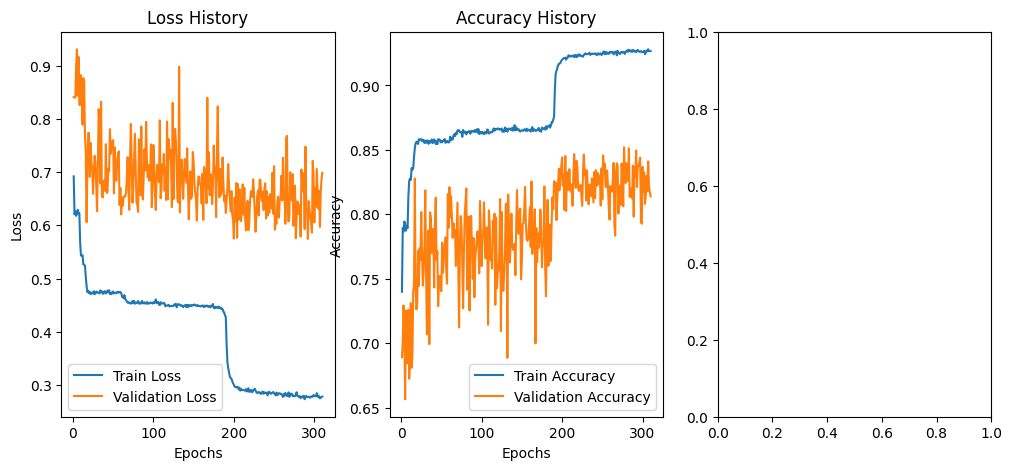

In [28]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.3)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 300
Epoch [300/350] training...



Evaluating on validation set...
Epoch [300/350], Loss: 0.2759, Acc: 0.9271, Val_Loss: 0.6931, Val_Acc: 0.8179, Val_Jaccard: 0.3178
Checkpoint saved at epoch 300
Best model saved as 'best_model.pth'
Epoch [301/350] training...



Evaluating on validation set...
Epoch [301/350], Loss: 0.2770, Acc: 0.9268, Val_Loss: 0.6624, Val_Acc: 0.8193, Val_Jaccard: 0.3470
Checkpoint saved at epoch 301
Best model saved as 'best_model.pth'
Epoch [302/350] training...



Evaluating on validation set...
Epoch [302/350], Loss: 0.2799, Acc: 0.9261, Val_Loss: 0.6122, Val_Acc: 0.8285, Val_Jaccard: 0.3949
Checkpoint saved at epoch 302
Best model saved as 'best_model.pth'
Epoch [303/350] training...



Evaluating on validation set...
Epoch [303/350], Loss: 0.2745, Acc: 0.9269, Val_Loss: 0.6421, Val_Acc: 0.8106, Val_Jaccard: 0.3649
Checkpoint saved at epoch 303
Best model saved as 'best_model.pth'
Epoch [304/350] training...



Evaluating on validation set...
Epoch [304/350], Loss: 0.2794, Acc: 0.9268, Val_Loss: 0.6073, Val_Acc: 0.8353, Val_Jaccard: 0.3950
Checkpoint saved at epoch 304
Best model saved as 'best_model.pth'
Epoch [305/350] training...



Evaluating on validation set...
Epoch [305/350], Loss: 0.2754, Acc: 0.9263, Val_Loss: 0.6269, Val_Acc: 0.8269, Val_Jaccard: 0.3789
Checkpoint saved at epoch 305
Best model saved as 'best_model.pth'
Epoch [306/350] training...



Evaluating on validation set...
Epoch [306/350], Loss: 0.2743, Acc: 0.9269, Val_Loss: 0.6252, Val_Acc: 0.8374, Val_Jaccard: 0.3812
Checkpoint saved at epoch 306
Best model saved as 'best_model.pth'
Epoch [307/350] training...



Evaluating on validation set...
Epoch [307/350], Loss: 0.2750, Acc: 0.9274, Val_Loss: 0.7108, Val_Acc: 0.8061, Val_Jaccard: 0.3056
Checkpoint saved at epoch 307
Best model saved as 'best_model.pth'
Epoch [308/350] training...



Evaluating on validation set...
Epoch [308/350], Loss: 0.2782, Acc: 0.9261, Val_Loss: 0.6402, Val_Acc: 0.8325, Val_Jaccard: 0.3672
Checkpoint saved at epoch 308
Best model saved as 'best_model.pth'
Epoch [309/350] training...



Evaluating on validation set...
Epoch [309/350], Loss: 0.2764, Acc: 0.9267, Val_Loss: 0.6371, Val_Acc: 0.8208, Val_Jaccard: 0.3673
Checkpoint saved at epoch 309
Best model saved as 'best_model.pth'
Epoch [310/350] training...



Evaluating on validation set...
Epoch [310/350], Loss: 0.2769, Acc: 0.9271, Val_Loss: 0.6998, Val_Acc: 0.8058, Val_Jaccard: 0.3115
Checkpoint saved at epoch 310
Best model saved as 'best_model.pth'
Epoch [311/350] training...



Evaluating on validation set...
Epoch [311/350], Loss: 0.2769, Acc: 0.9270, Val_Loss: 0.6471, Val_Acc: 0.8294, Val_Jaccard: 0.3634
Checkpoint saved at epoch 311
Best model saved as 'best_model.pth'
Epoch [312/350] training...



Evaluating on validation set...
Epoch [312/350], Loss: 0.2792, Acc: 0.9260, Val_Loss: 0.6078, Val_Acc: 0.8353, Val_Jaccard: 0.3988
Checkpoint saved at epoch 312
Best model saved as 'best_model.pth'
Epoch [313/350] training...



Evaluating on validation set...
Epoch [313/350], Loss: 0.2766, Acc: 0.9264, Val_Loss: 0.6135, Val_Acc: 0.8374, Val_Jaccard: 0.3942
Checkpoint saved at epoch 313
Best model saved as 'best_model.pth'
Epoch [314/350] training...



Evaluating on validation set...
Epoch [314/350], Loss: 0.2761, Acc: 0.9271, Val_Loss: 0.5796, Val_Acc: 0.8463, Val_Jaccard: 0.4301
Checkpoint saved at epoch 314
Best model saved as 'best_model.pth'
Epoch [315/350] training...



Evaluating on validation set...
Epoch [315/350], Loss: 0.2751, Acc: 0.9279, Val_Loss: 0.6708, Val_Acc: 0.8313, Val_Jaccard: 0.3360
Checkpoint saved at epoch 315
Best model saved as 'best_model.pth'
Epoch [316/350] training...



Evaluating on validation set...
Epoch [316/350], Loss: 0.2773, Acc: 0.9265, Val_Loss: 0.6455, Val_Acc: 0.8256, Val_Jaccard: 0.3641
Checkpoint saved at epoch 316
Best model saved as 'best_model.pth'
Epoch [317/350] training...



Evaluating on validation set...
Epoch [317/350], Loss: 0.2772, Acc: 0.9265, Val_Loss: 0.6058, Val_Acc: 0.8396, Val_Jaccard: 0.4020
Checkpoint saved at epoch 317
Best model saved as 'best_model.pth'
Epoch [318/350] training...



Evaluating on validation set...
Epoch [318/350], Loss: 0.2758, Acc: 0.9275, Val_Loss: 0.6300, Val_Acc: 0.8287, Val_Jaccard: 0.3750
Checkpoint saved at epoch 318
Best model saved as 'best_model.pth'
Epoch [319/350] training...



Evaluating on validation set...
Epoch [319/350], Loss: 0.2782, Acc: 0.9261, Val_Loss: 0.6411, Val_Acc: 0.8281, Val_Jaccard: 0.3673
Checkpoint saved at epoch 319
Best model saved as 'best_model.pth'
Epoch [320/350] training...



Evaluating on validation set...
Epoch [320/350], Loss: 0.2806, Acc: 0.9262, Val_Loss: 0.6686, Val_Acc: 0.8240, Val_Jaccard: 0.3428
Checkpoint saved at epoch 320
Best model saved as 'best_model.pth'
Epoch [321/350] training...



Evaluating on validation set...
Epoch [321/350], Loss: 0.2786, Acc: 0.9261, Val_Loss: 0.6812, Val_Acc: 0.8163, Val_Jaccard: 0.3259
Checkpoint saved at epoch 321
Best model saved as 'best_model.pth'
Epoch [322/350] training...



Evaluating on validation set...
Epoch [322/350], Loss: 0.2753, Acc: 0.9272, Val_Loss: 0.6624, Val_Acc: 0.8214, Val_Jaccard: 0.3469
Checkpoint saved at epoch 322
Best model saved as 'best_model.pth'
Epoch [323/350] training...



Evaluating on validation set...
Epoch [323/350], Loss: 0.2763, Acc: 0.9270, Val_Loss: 0.5989, Val_Acc: 0.8417, Val_Jaccard: 0.4060
Checkpoint saved at epoch 323
Best model saved as 'best_model.pth'
Epoch [324/350] training...



Evaluating on validation set...
Epoch [324/350], Loss: 0.2737, Acc: 0.9275, Val_Loss: 0.7134, Val_Acc: 0.8079, Val_Jaccard: 0.2969
Checkpoint saved at epoch 324
Best model saved as 'best_model.pth'
Epoch [325/350] training...



Evaluating on validation set...
Epoch [325/350], Loss: 0.2766, Acc: 0.9262, Val_Loss: 0.6382, Val_Acc: 0.8301, Val_Jaccard: 0.3701
Checkpoint saved at epoch 325
Best model saved as 'best_model.pth'
Epoch [326/350] training...



Evaluating on validation set...
Epoch [326/350], Loss: 0.2767, Acc: 0.9264, Val_Loss: 0.6555, Val_Acc: 0.8247, Val_Jaccard: 0.3554
Checkpoint saved at epoch 326
Best model saved as 'best_model.pth'
Epoch [327/350] training...



Evaluating on validation set...
Epoch [327/350], Loss: 0.2745, Acc: 0.9273, Val_Loss: 0.6347, Val_Acc: 0.8279, Val_Jaccard: 0.3738
Checkpoint saved at epoch 327
Best model saved as 'best_model.pth'
Epoch [328/350] training...



Evaluating on validation set...
Epoch [328/350], Loss: 0.2761, Acc: 0.9259, Val_Loss: 0.6810, Val_Acc: 0.8120, Val_Jaccard: 0.3246
Checkpoint saved at epoch 328
Best model saved as 'best_model.pth'
Epoch [329/350] training...



Evaluating on validation set...
Epoch [329/350], Loss: 0.2749, Acc: 0.9271, Val_Loss: 0.6538, Val_Acc: 0.8236, Val_Jaccard: 0.3537
Checkpoint saved at epoch 329
Best model saved as 'best_model.pth'
Epoch [330/350] training...



Evaluating on validation set...
Epoch [330/350], Loss: 0.2756, Acc: 0.9282, Val_Loss: 0.6157, Val_Acc: 0.8360, Val_Jaccard: 0.3921
Checkpoint saved at epoch 330
Best model saved as 'best_model.pth'
Epoch [331/350] training...



Evaluating on validation set...
Epoch [331/350], Loss: 0.2728, Acc: 0.9273, Val_Loss: 0.6398, Val_Acc: 0.8194, Val_Jaccard: 0.3661
Checkpoint saved at epoch 331
Best model saved as 'best_model.pth'
Epoch [332/350] training...



Evaluating on validation set...
Epoch [332/350], Loss: 0.2746, Acc: 0.9271, Val_Loss: 0.6201, Val_Acc: 0.8341, Val_Jaccard: 0.3857
Checkpoint saved at epoch 332
Best model saved as 'best_model.pth'
Epoch [333/350] training...



Evaluating on validation set...
Epoch [333/350], Loss: 0.2737, Acc: 0.9270, Val_Loss: 0.6925, Val_Acc: 0.8255, Val_Jaccard: 0.3235
Checkpoint saved at epoch 333
Best model saved as 'best_model.pth'
Epoch [334/350] training...



Evaluating on validation set...
Epoch [334/350], Loss: 0.2767, Acc: 0.9266, Val_Loss: 0.7064, Val_Acc: 0.8035, Val_Jaccard: 0.2988
Checkpoint saved at epoch 334
Best model saved as 'best_model.pth'
Epoch [335/350] training...



Evaluating on validation set...
Epoch [335/350], Loss: 0.2761, Acc: 0.9263, Val_Loss: 0.6220, Val_Acc: 0.8320, Val_Jaccard: 0.3857
Checkpoint saved at epoch 335
Best model saved as 'best_model.pth'
Epoch [336/350] training...



Evaluating on validation set...
Epoch [336/350], Loss: 0.2744, Acc: 0.9276, Val_Loss: 0.6644, Val_Acc: 0.8237, Val_Jaccard: 0.3419
Checkpoint saved at epoch 336
Best model saved as 'best_model.pth'
Epoch [337/350] training...



Evaluating on validation set...
Epoch [337/350], Loss: 0.2758, Acc: 0.9263, Val_Loss: 0.6467, Val_Acc: 0.8311, Val_Jaccard: 0.3630
Checkpoint saved at epoch 337
Best model saved as 'best_model.pth'
Epoch [338/350] training...



Evaluating on validation set...
Epoch [338/350], Loss: 0.2778, Acc: 0.9258, Val_Loss: 0.6157, Val_Acc: 0.8348, Val_Jaccard: 0.3886
Checkpoint saved at epoch 338
Best model saved as 'best_model.pth'
Epoch [339/350] training...



Evaluating on validation set...
Epoch [339/350], Loss: 0.2737, Acc: 0.9274, Val_Loss: 0.6405, Val_Acc: 0.8249, Val_Jaccard: 0.3709
Checkpoint saved at epoch 339
Best model saved as 'best_model.pth'
Epoch [340/350] training...



Evaluating on validation set...
Epoch [340/350], Loss: 0.2757, Acc: 0.9270, Val_Loss: 0.7188, Val_Acc: 0.7997, Val_Jaccard: 0.2899
Checkpoint saved at epoch 340
Best model saved as 'best_model.pth'
Epoch [341/350] training...



Evaluating on validation set...
Epoch [341/350], Loss: 0.2722, Acc: 0.9274, Val_Loss: 0.6716, Val_Acc: 0.8141, Val_Jaccard: 0.3396
Checkpoint saved at epoch 341
Best model saved as 'best_model.pth'
Epoch [342/350] training...



Evaluating on validation set...
Epoch [342/350], Loss: 0.2741, Acc: 0.9276, Val_Loss: 0.6344, Val_Acc: 0.8305, Val_Jaccard: 0.3746
Checkpoint saved at epoch 342
Best model saved as 'best_model.pth'
Epoch [343/350] training...



Evaluating on validation set...
Epoch [343/350], Loss: 0.2790, Acc: 0.9265, Val_Loss: 0.5966, Val_Acc: 0.8393, Val_Jaccard: 0.4056
Checkpoint saved at epoch 343
Best model saved as 'best_model.pth'
Epoch [344/350] training...



Evaluating on validation set...
Epoch [344/350], Loss: 0.2798, Acc: 0.9257, Val_Loss: 0.6653, Val_Acc: 0.8036, Val_Jaccard: 0.3412
Checkpoint saved at epoch 344
Best model saved as 'best_model.pth'
Epoch [345/350] training...



Evaluating on validation set...
Epoch [345/350], Loss: 0.2788, Acc: 0.9268, Val_Loss: 0.5940, Val_Acc: 0.8419, Val_Jaccard: 0.4106
Checkpoint saved at epoch 345
Best model saved as 'best_model.pth'
Epoch [346/350] training...



Evaluating on validation set...
Epoch [346/350], Loss: 0.2776, Acc: 0.9261, Val_Loss: 0.6505, Val_Acc: 0.8213, Val_Jaccard: 0.3625
Checkpoint saved at epoch 346
Best model saved as 'best_model.pth'
Epoch [347/350] training...



Evaluating on validation set...
Epoch [347/350], Loss: 0.2766, Acc: 0.9264, Val_Loss: 0.6311, Val_Acc: 0.8298, Val_Jaccard: 0.3742
Checkpoint saved at epoch 347
Best model saved as 'best_model.pth'
Epoch [348/350] training...



Evaluating on validation set...
Epoch [348/350], Loss: 0.2745, Acc: 0.9270, Val_Loss: 0.6142, Val_Acc: 0.8365, Val_Jaccard: 0.3912
Checkpoint saved at epoch 348
Best model saved as 'best_model.pth'
Epoch [349/350] training...



Evaluating on validation set...
Epoch [349/350], Loss: 0.2772, Acc: 0.9264, Val_Loss: 0.6365, Val_Acc: 0.8255, Val_Jaccard: 0.3684
Checkpoint saved at epoch 349
Best model saved as 'best_model.pth'
Epoch [350/350] training...



Evaluating on validation set...
Epoch [350/350], Loss: 0.2720, Acc: 0.9282, Val_Loss: 0.6346, Val_Acc: 0.8283, Val_Jaccard: 0.3728
Checkpoint saved at epoch 350
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

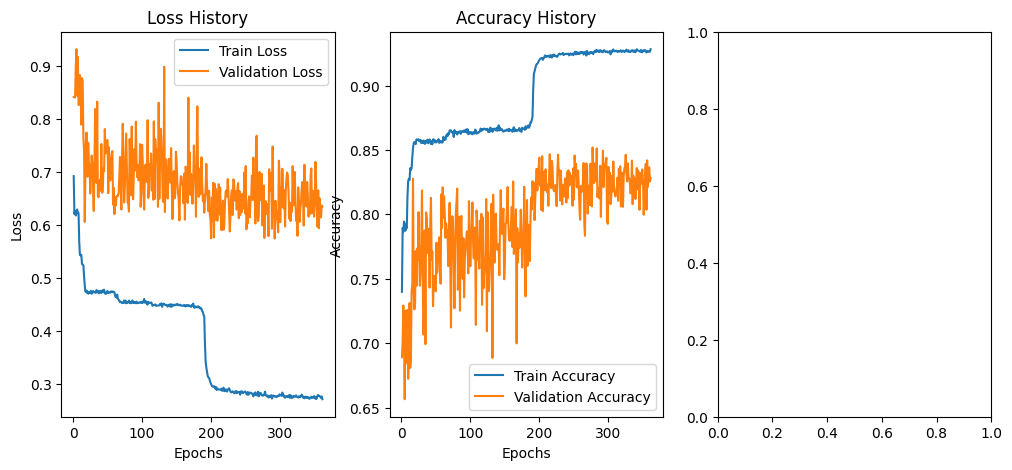

In [29]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 350
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 350
Epoch [350/370] training...



Evaluating on validation set...
Epoch [350/370], Loss: 0.2744, Acc: 0.9275, Val_Loss: 0.5857, Val_Acc: 0.8436, Val_Jaccard: 0.4197
Checkpoint saved at epoch 350
Best model saved as 'best_model.pth'
Epoch [351/370] training...



Evaluating on validation set...
Epoch [351/370], Loss: 0.2766, Acc: 0.9271, Val_Loss: 0.6217, Val_Acc: 0.8321, Val_Jaccard: 0.3874
Checkpoint saved at epoch 351
Best model saved as 'best_model.pth'
Epoch [352/370] training...



Evaluating on validation set...
Epoch [352/370], Loss: 0.2765, Acc: 0.9271, Val_Loss: 0.7018, Val_Acc: 0.8076, Val_Jaccard: 0.3096
Checkpoint saved at epoch 352
Best model saved as 'best_model.pth'
Epoch [353/370] training...



Evaluating on validation set...
Epoch [353/370], Loss: 0.2742, Acc: 0.9271, Val_Loss: 0.5935, Val_Acc: 0.8368, Val_Jaccard: 0.4122
Checkpoint saved at epoch 353
Best model saved as 'best_model.pth'
Epoch [354/370] training...



Evaluating on validation set...
Epoch [354/370], Loss: 0.2732, Acc: 0.9277, Val_Loss: 0.6935, Val_Acc: 0.8111, Val_Jaccard: 0.3131
Checkpoint saved at epoch 354
Best model saved as 'best_model.pth'
Epoch [355/370] training...



Evaluating on validation set...
Epoch [355/370], Loss: 0.2771, Acc: 0.9263, Val_Loss: 0.6100, Val_Acc: 0.8333, Val_Jaccard: 0.3935
Checkpoint saved at epoch 355
Best model saved as 'best_model.pth'
Epoch [356/370] training...



Evaluating on validation set...
Epoch [356/370], Loss: 0.2757, Acc: 0.9270, Val_Loss: 0.7017, Val_Acc: 0.8092, Val_Jaccard: 0.3076
Checkpoint saved at epoch 356
Best model saved as 'best_model.pth'
Epoch [357/370] training...



Evaluating on validation set...
Epoch [357/370], Loss: 0.2701, Acc: 0.9286, Val_Loss: 0.6285, Val_Acc: 0.8260, Val_Jaccard: 0.3782
Checkpoint saved at epoch 357
Best model saved as 'best_model.pth'
Epoch [358/370] training...



Evaluating on validation set...
Epoch [358/370], Loss: 0.2771, Acc: 0.9259, Val_Loss: 0.6034, Val_Acc: 0.8385, Val_Jaccard: 0.4016
Checkpoint saved at epoch 358
Best model saved as 'best_model.pth'
Epoch [359/370] training...



Evaluating on validation set...
Epoch [359/370], Loss: 0.2739, Acc: 0.9278, Val_Loss: 0.6335, Val_Acc: 0.8336, Val_Jaccard: 0.3742
Checkpoint saved at epoch 359
Best model saved as 'best_model.pth'
Epoch [360/370] training...



Evaluating on validation set...
Epoch [360/370], Loss: 0.2766, Acc: 0.9269, Val_Loss: 0.6326, Val_Acc: 0.8280, Val_Jaccard: 0.3718
Checkpoint saved at epoch 360
Best model saved as 'best_model.pth'
Epoch [361/370] training...



Evaluating on validation set...
Epoch [361/370], Loss: 0.2766, Acc: 0.9272, Val_Loss: 0.6598, Val_Acc: 0.8227, Val_Jaccard: 0.3567
Checkpoint saved at epoch 361
Best model saved as 'best_model.pth'
Epoch [362/370] training...



Evaluating on validation set...
Epoch [362/370], Loss: 0.2717, Acc: 0.9278, Val_Loss: 0.6741, Val_Acc: 0.8061, Val_Jaccard: 0.3344
Checkpoint saved at epoch 362
Best model saved as 'best_model.pth'
Epoch [363/370] training...



Evaluating on validation set...
Epoch [363/370], Loss: 0.2758, Acc: 0.9263, Val_Loss: 0.6470, Val_Acc: 0.8264, Val_Jaccard: 0.3771
Checkpoint saved at epoch 363
Best model saved as 'best_model.pth'
Epoch [364/370] training...



Evaluating on validation set...
Epoch [364/370], Loss: 0.2744, Acc: 0.9280, Val_Loss: 0.7501, Val_Acc: 0.7917, Val_Jaccard: 0.2606
Checkpoint saved at epoch 364
Best model saved as 'best_model.pth'
Epoch [365/370] training...



Evaluating on validation set...
Epoch [365/370], Loss: 0.2753, Acc: 0.9278, Val_Loss: 0.6542, Val_Acc: 0.8217, Val_Jaccard: 0.3536
Checkpoint saved at epoch 365
Best model saved as 'best_model.pth'
Epoch [366/370] training...



Evaluating on validation set...
Epoch [366/370], Loss: 0.2720, Acc: 0.9286, Val_Loss: 0.5864, Val_Acc: 0.8488, Val_Jaccard: 0.4159
Checkpoint saved at epoch 366
Best model saved as 'best_model.pth'
Epoch [367/370] training...



Evaluating on validation set...
Epoch [367/370], Loss: 0.2765, Acc: 0.9273, Val_Loss: 0.6699, Val_Acc: 0.8237, Val_Jaccard: 0.3407
Checkpoint saved at epoch 367
Best model saved as 'best_model.pth'
Epoch [368/370] training...



Evaluating on validation set...
Epoch [368/370], Loss: 0.2743, Acc: 0.9271, Val_Loss: 0.6379, Val_Acc: 0.8256, Val_Jaccard: 0.3678
Checkpoint saved at epoch 368
Best model saved as 'best_model.pth'
Epoch [369/370] training...



Evaluating on validation set...
Epoch [369/370], Loss: 0.2722, Acc: 0.9282, Val_Loss: 0.6760, Val_Acc: 0.8101, Val_Jaccard: 0.3308
Checkpoint saved at epoch 369
Best model saved as 'best_model.pth'
Epoch [370/370] training...



Evaluating on validation set...
Epoch [370/370], Loss: 0.2721, Acc: 0.9291, Val_Loss: 0.7127, Val_Acc: 0.8179, Val_Jaccard: 0.2986
Checkpoint saved at epoch 370
Best model saved as 'best_model.pth'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

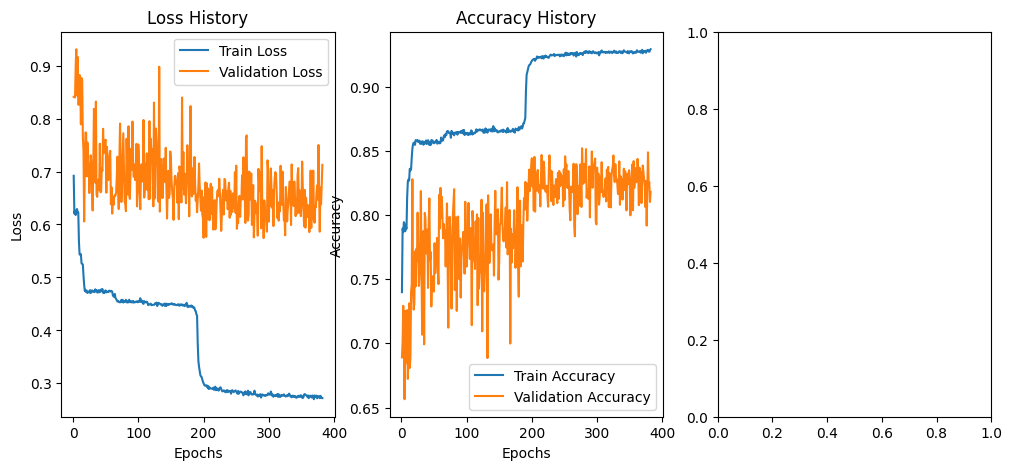

In [30]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 370
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.5)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

In [ ]:
### 기존 코드에서 CWT 변환만 추가 ###

# 학습 실행
num_epochs = 380
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.9)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

/tmp/ipykernel_43808/3302825958.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 370
Epoch [370/380] training...



Evaluating on validation set...
Epoch [370/380], Loss: 0.2698, Acc: 0.9286, Val_Loss: 0.6262, Val_Acc: 0.8241, Val_Jaccard: 0.3767
Checkpoint saved at epoch 370
Best model saved as 'best_model.pth'
Epoch [371/380] training...



Evaluating on validation set...
Epoch [371/380], Loss: 0.2717, Acc: 0.9288, Val_Loss: 0.6623, Val_Acc: 0.8137, Val_Jaccard: 0.3449
Checkpoint saved at epoch 371
Best model saved as 'best_model.pth'
Epoch [372/380] training...



Evaluating on validation set...
Epoch [372/380], Loss: 0.2707, Acc: 0.9287, Val_Loss: 0.7071, Val_Acc: 0.8089, Val_Jaccard: 0.3053
Checkpoint saved at epoch 372
Best model saved as 'best_model.pth'
Epoch [373/380] training...



Evaluating on validation set...
Epoch [373/380], Loss: 0.2723, Acc: 0.9286, Val_Loss: 0.6449, Val_Acc: 0.8312, Val_Jaccard: 0.3651
Checkpoint saved at epoch 373
Best model saved as 'best_model.pth'
Epoch [374/380] training...



Evaluating on validation set...
Epoch [374/380], Loss: 0.2690, Acc: 0.9294, Val_Loss: 0.6902, Val_Acc: 0.8138, Val_Jaccard: 0.3173
Checkpoint saved at epoch 374
Best model saved as 'best_model.pth'
Epoch [375/380] training...



Evaluating on validation set...
Epoch [375/380], Loss: 0.2708, Acc: 0.9288, Val_Loss: 0.6535, Val_Acc: 0.8303, Val_Jaccard: 0.3557
Checkpoint saved at epoch 375
Best model saved as 'best_model.pth'
Epoch [376/380] training...



Evaluating on validation set...
Epoch [376/380], Loss: 0.2680, Acc: 0.9292, Val_Loss: 0.6634, Val_Acc: 0.8122, Val_Jaccard: 0.3424
Checkpoint saved at epoch 376
Best model saved as 'best_model.pth'
Epoch [377/380] training...



Evaluating on validation set...
Epoch [377/380], Loss: 0.2692, Acc: 0.9286, Val_Loss: 0.6579, Val_Acc: 0.8237, Val_Jaccard: 0.3521
Checkpoint saved at epoch 377
Best model saved as 'best_model.pth'
Epoch [378/380] training...



Evaluating on validation set...
Epoch [378/380], Loss: 0.2696, Acc: 0.9290, Val_Loss: 0.6904, Val_Acc: 0.8059, Val_Jaccard: 0.3182
Checkpoint saved at epoch 378
Best model saved as 'best_model.pth'
Epoch [379/380] training...


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 562/564 [08:32<00:01,  1.10it/s]

Counter({4: 224, 3: 216, 0: 201, 411: 122, 6: 102, 11: 88, 311: 72, 111: 65, 106: 32, 306: 28, 13: 23, 611: 22, 10: 19, 406: 17, 910: 9, 911: 9, 610: 8, 1: 4, 1011: 1, 613: 1})
20 20


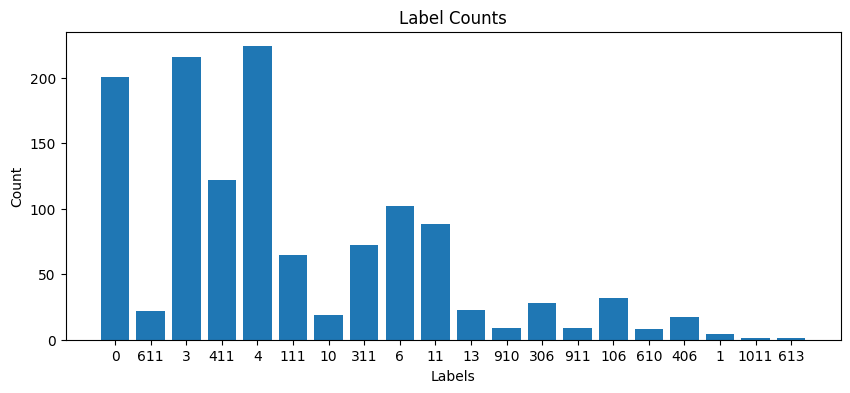

In [16]:
from collections import Counter
import matplotlib.pyplot as plt

label_counts = Counter(labels_test)
print(label_counts)

# 숫자 레이블을 문자열로 변환
labels_strings = [str(label) for label in label_counts.keys()]
counts = list(label_counts.values())

# labels_strings와 counts의 길이가 일치하는지 확인
print(len(labels_strings), len(counts))  # 길이가 같아야 합니다.

# 바 차트 생성
plt.figure(figsize=(10,4))
plt.bar(labels_strings, counts, tick_label=labels_strings)

# 레이블과 제목 추가
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Counts')

# 차트 표시
plt.show()

In [ ]:
### CWT 추가 + BCELoss로 변환 ###

# 학습 실행
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

Checkpoint loaded from epoch 7
Epoch [7/60] training...


Evaluating on validation set...
Epoch [7/60], Loss: 0.8672, Acc: 0.8383, Val_Loss: 0.6916, Val_Acc: 0.8392, Val_Jaccard: 0.4870
New best model with val_jaccard: 0.4870
Checkpoint saved at epoch 7
Epoch [8/60] training...


Evaluating on validation set...
Epoch [8/60], Loss: 0.9291, Acc: 0.8397, Val_Loss: 0.8413, Val_Acc: 0.8117, Val_Jaccard: 0.3982
Checkpoint saved at epoch 8
Epoch [9/60] training...


Evaluating on validation set...
Epoch [9/60], Loss: 0.9505, Acc: 0.8415, Val_Loss: 0.7650, Val_Acc: 0.8313, Val_Jaccard: 0.4578
Checkpoint saved at epoch 9
Epoch [10/60] training...


Evaluating on validation set...
Epoch [10/60], Loss: 0.9041, Acc: 0.8423, Val_Loss: 0.7895, Val_Acc: 0.8215, Val_Jaccard: 0.4636
Checkpoint saved at epoch 10
Epoch [11/60] training...


Evaluating on validation set...
Epoch [11/60], Loss: 0.9270, Acc: 0.8453, Val_Loss: 0.7779, Val_Acc: 0.8377, Val_Jaccard: 0.4678
Checkpoint saved at epoch 11
Epoch [12/60] training...


Evaluating on validation set...
Epoch [12/60], Loss: 0.9213, Acc: 0.8466, Val_Loss: 0.9508, Val_Acc: 0.8442, Val_Jaccard: 0.4801
Checkpoint saved at epoch 12
Epoch [13/60] training...


Evaluating on validation set...
Epoch [13/60], Loss: 0.8605, Acc: 0.8506, Val_Loss: 0.6181, Val_Acc: 0.8445, Val_Jaccard: 0.4804
Checkpoint saved at epoch 13
Epoch [14/60] training...


Evaluating on validation set...
Epoch [14/60], Loss: 0.8691, Acc: 0.8533, Val_Loss: 0.6448, Val_Acc: 0.8546, Val_Jaccard: 0.5162
New best model with val_jaccard: 0.5162
Checkpoint saved at epoch 14
Epoch [15/60] training...


Evaluating on validation set...
Epoch [15/60], Loss: 0.8638, Acc: 0.8549, Val_Loss: 0.7241, Val_Acc: 0.8276, Val_Jaccard: 0.4517
Checkpoint saved at epoch 15
Epoch [16/60] training...


Evaluating on validation set...
Epoch [16/60], Loss: 0.8397, Acc: 0.8594, Val_Loss: 0.8628, Val_Acc: 0.8356, Val_Jaccard: 0.4839
Checkpoint saved at epoch 16
Epoch [17/60] training...


Evaluating on validation set...
Epoch [17/60], Loss: 0.7722, Acc: 0.8778, Val_Loss: 1.1368, Val_Acc: 0.8950, Val_Jaccard: 0.6351
New best model with val_jaccard: 0.6351
Checkpoint saved at epoch 17
Epoch [18/60] training...


Evaluating on validation set...
Epoch [18/60], Loss: 0.7494, Acc: 0.9015, Val_Loss: 0.5132, Val_Acc: 0.9125, Val_Jaccard: 0.6982
New best model with val_jaccard: 0.6982
Checkpoint saved at epoch 18
Epoch [19/60] training...


Evaluating on validation set...
Epoch [19/60], Loss: 0.6667, Acc: 0.9156, Val_Loss: 0.6471, Val_Acc: 0.9132, Val_Jaccard: 0.6973
Checkpoint saved at epoch 19
Epoch [20/60] training...


Evaluating on validation set...
Epoch [20/60], Loss: 0.6406, Acc: 0.9248, Val_Loss: 0.5503, Val_Acc: 0.9319, Val_Jaccard: 0.7587
New best model with val_jaccard: 0.7587
Checkpoint saved at epoch 20
Epoch [21/60] training...


Evaluating on validation set...
Epoch [21/60], Loss: 0.6347, Acc: 0.9319, Val_Loss: 0.4874, Val_Acc: 0.9445, Val_Jaccard: 0.7999
New best model with val_jaccard: 0.7999
Checkpoint saved at epoch 21
Epoch [22/60] training...


Evaluating on validation set...
Epoch [22/60], Loss: 0.5953, Acc: 0.9427, Val_Loss: 0.3389, Val_Acc: 0.9366, Val_Jaccard: 0.7978
Checkpoint saved at epoch 22
Epoch [23/60] training...


Evaluating on validation set...
Epoch [23/60], Loss: 0.5272, Acc: 0.9491, Val_Loss: 0.7138, Val_Acc: 0.9506, Val_Jaccard: 0.8308
New best model with val_jaccard: 0.8308
Checkpoint saved at epoch 23
Epoch [24/60] training...


Evaluating on validation set...
Epoch [24/60], Loss: 0.4729, Acc: 0.9517, Val_Loss: 0.2616, Val_Acc: 0.9492, Val_Jaccard: 0.8302
Checkpoint saved at epoch 24
Epoch [25/60] training...


Evaluating on validation set...
Epoch [25/60], Loss: 0.4179, Acc: 0.9561, Val_Loss: 0.3373, Val_Acc: 0.9578, Val_Jaccard: 0.8533
New best model with val_jaccard: 0.8533
Checkpoint saved at epoch 25
Epoch [26/60] training...


Evaluating on validation set...
Epoch [26/60], Loss: 0.3362, Acc: 0.9584, Val_Loss: 0.5209, Val_Acc: 0.9449, Val_Jaccard: 0.8013
Checkpoint saved at epoch 26
Epoch [27/60] training...


Evaluating on validation set...
Epoch [27/60], Loss: 0.2994, Acc: 0.9603, Val_Loss: 0.5245, Val_Acc: 0.9577, Val_Jaccard: 0.8477
Checkpoint saved at epoch 27
Epoch [28/60] training...


Evaluating on validation set...
Epoch [28/60], Loss: 0.2447, Acc: 0.9632, Val_Loss: 0.2364, Val_Acc: 0.9602, Val_Jaccard: 0.8655
New best model with val_jaccard: 0.8655
Checkpoint saved at epoch 28
Epoch [29/60] training...


Evaluating on validation set...
Epoch [29/60], Loss: 0.1994, Acc: 0.9646, Val_Loss: 0.4839, Val_Acc: 0.9594, Val_Jaccard: 0.8623
Checkpoint saved at epoch 29
Epoch [30/60] training...


Evaluating on validation set...
Epoch [30/60], Loss: 0.2061, Acc: 0.9662, Val_Loss: 0.4503, Val_Acc: 0.9567, Val_Jaccard: 0.8602
Checkpoint saved at epoch 30
Epoch [31/60] training...


Evaluating on validation set...
Epoch [31/60], Loss: 0.1781, Acc: 0.9674, Val_Loss: 0.2393, Val_Acc: 0.9636, Val_Jaccard: 0.8698
New best model with val_jaccard: 0.8698
Checkpoint saved at epoch 31
Epoch [32/60] training...


Evaluating on validation set...
Epoch [32/60], Loss: 0.1832, Acc: 0.9665, Val_Loss: 0.1966, Val_Acc: 0.9627, Val_Jaccard: 0.8704
New best model with val_jaccard: 0.8704
Checkpoint saved at epoch 32
Epoch [33/60] training...


Evaluating on validation set...
Epoch [33/60], Loss: 0.1642, Acc: 0.9704, Val_Loss: 0.3224, Val_Acc: 0.9668, Val_Jaccard: 0.8810
New best model with val_jaccard: 0.8810
Checkpoint saved at epoch 33
Epoch [34/60] training...


Evaluating on validation set...
Epoch [34/60], Loss: 0.1473, Acc: 0.9717, Val_Loss: 0.1460, Val_Acc: 0.9675, Val_Jaccard: 0.8804
Checkpoint saved at epoch 34
Epoch [35/60] training...


Evaluating on validation set...
Epoch [35/60], Loss: 0.1509, Acc: 0.9717, Val_Loss: 0.1504, Val_Acc: 0.9653, Val_Jaccard: 0.8813
New best model with val_jaccard: 0.8813
Checkpoint saved at epoch 35
Epoch [36/60] training...


Evaluating on validation set...
Epoch [36/60], Loss: 0.1411, Acc: 0.9725, Val_Loss: 0.1317, Val_Acc: 0.9708, Val_Jaccard: 0.8947
New best model with val_jaccard: 0.8947
Checkpoint saved at epoch 36
Epoch [37/60] training...


Evaluating on validation set...
Epoch [37/60], Loss: 0.1380, Acc: 0.9741, Val_Loss: 0.1594, Val_Acc: 0.9695, Val_Jaccard: 0.8924
Checkpoint saved at epoch 37
Epoch [38/60] training...


Evaluating on validation set...
Epoch [38/60], Loss: 0.1357, Acc: 0.9752, Val_Loss: 0.1350, Val_Acc: 0.9733, Val_Jaccard: 0.9024
New best model with val_jaccard: 0.9024
Checkpoint saved at epoch 38
Epoch [39/60] training...


Evaluating on validation set...
Epoch [39/60], Loss: 0.1299, Acc: 0.9758, Val_Loss: 0.5447, Val_Acc: 0.9726, Val_Jaccard: 0.8977
Checkpoint saved at epoch 39
Epoch [40/60] training...


Evaluating on validation set...
Epoch [40/60], Loss: 0.1271, Acc: 0.9758, Val_Loss: 0.1235, Val_Acc: 0.9729, Val_Jaccard: 0.9008
Checkpoint saved at epoch 40
Epoch [41/60] training...


Evaluating on validation set...
Epoch [41/60], Loss: 0.1187, Acc: 0.9776, Val_Loss: 0.2131, Val_Acc: 0.9720, Val_Jaccard: 0.9068
New best model with val_jaccard: 0.9068
Checkpoint saved at epoch 41
Epoch [42/60] training...


Evaluating on validation set...
Epoch [42/60], Loss: 0.1282, Acc: 0.9775, Val_Loss: 0.1109, Val_Acc: 0.9726, Val_Jaccard: 0.9055
Checkpoint saved at epoch 42
Epoch [43/60] training...


Evaluating on validation set...
Epoch [43/60], Loss: 0.1120, Acc: 0.9790, Val_Loss: 0.1468, Val_Acc: 0.9681, Val_Jaccard: 0.8919
Checkpoint saved at epoch 43
Epoch [44/60] training...


Evaluating on validation set...
Epoch [44/60], Loss: 0.1081, Acc: 0.9795, Val_Loss: 0.1188, Val_Acc: 0.9722, Val_Jaccard: 0.9039
Checkpoint saved at epoch 44
Epoch [45/60] training...


Evaluating on validation set...
Epoch [45/60], Loss: 0.1018, Acc: 0.9805, Val_Loss: 0.1229, Val_Acc: 0.9733, Val_Jaccard: 0.9021
Checkpoint saved at epoch 45
Epoch [46/60] training...


Evaluating on validation set...
Epoch [46/60], Loss: 0.1066, Acc: 0.9806, Val_Loss: 0.1140, Val_Acc: 0.9711, Val_Jaccard: 0.9005
Checkpoint saved at epoch 46
Epoch [47/60] training...


Evaluating on validation set...
Epoch [47/60], Loss: 0.0965, Acc: 0.9813, Val_Loss: 0.1121, Val_Acc: 0.9747, Val_Jaccard: 0.9118
New best model with val_jaccard: 0.9118
Checkpoint saved at epoch 47
Epoch [48/60] training...


Evaluating on validation set...
Epoch [48/60], Loss: 0.1008, Acc: 0.9818, Val_Loss: 0.1949, Val_Acc: 0.9608, Val_Jaccard: 0.8603
Checkpoint saved at epoch 48
Epoch [49/60] training...


Evaluating on validation set...
Epoch [49/60], Loss: 0.0962, Acc: 0.9814, Val_Loss: 0.1204, Val_Acc: 0.9731, Val_Jaccard: 0.9090
Checkpoint saved at epoch 49
Epoch [50/60] training...


Evaluating on validation set...
Epoch [50/60], Loss: 0.0927, Acc: 0.9822, Val_Loss: 0.1136, Val_Acc: 0.9751, Val_Jaccard: 0.9096
Checkpoint saved at epoch 50
Epoch [51/60] training...


Evaluating on validation set...
Epoch [51/60], Loss: 0.0881, Acc: 0.9832, Val_Loss: 0.1016, Val_Acc: 0.9759, Val_Jaccard: 0.9116
Checkpoint saved at epoch 51
Epoch [52/60] training...


Evaluating on validation set...
Epoch [52/60], Loss: 0.0893, Acc: 0.9839, Val_Loss: 0.1789, Val_Acc: 0.9777, Val_Jaccard: 0.9181
New best model with val_jaccard: 0.9181
Checkpoint saved at epoch 52
Epoch [53/60] training...


Evaluating on validation set...
Epoch [53/60], Loss: 0.0871, Acc: 0.9838, Val_Loss: 0.1166, Val_Acc: 0.9740, Val_Jaccard: 0.9114
Checkpoint saved at epoch 53
Epoch [54/60] training...


Evaluating on validation set...
Epoch [54/60], Loss: 0.0787, Acc: 0.9837, Val_Loss: 0.1154, Val_Acc: 0.9755, Val_Jaccard: 0.9121
Checkpoint saved at epoch 54
Epoch [55/60] training...


Evaluating on validation set...
Epoch [55/60], Loss: 0.0904, Acc: 0.9847, Val_Loss: 0.1205, Val_Acc: 0.9765, Val_Jaccard: 0.9130
Checkpoint saved at epoch 55
Epoch [56/60] training...


Evaluating on validation set...
Epoch [56/60], Loss: 0.0729, Acc: 0.9853, Val_Loss: 0.0967, Val_Acc: 0.9770, Val_Jaccard: 0.9163
Checkpoint saved at epoch 56
Epoch [57/60] training...


Evaluating on validation set...
Epoch [57/60], Loss: 0.0746, Acc: 0.9856, Val_Loss: 0.1959, Val_Acc: 0.9767, Val_Jaccard: 0.9109
Checkpoint saved at epoch 57
Epoch [58/60] training...


Evaluating on validation set...
Epoch [58/60], Loss: 0.0836, Acc: 0.9857, Val_Loss: 0.1068, Val_Acc: 0.9749, Val_Jaccard: 0.9122
Checkpoint saved at epoch 58
Epoch [59/60] training...


Evaluating on validation set...
Epoch [59/60], Loss: 0.0776, Acc: 0.9865, Val_Loss: 0.0932, Val_Acc: 0.9784, Val_Jaccard: 0.9236
New best model with val_jaccard: 0.9236
Checkpoint saved at epoch 59
Epoch [60/60] training...


Evaluating on validation set...
Epoch [60/60], Loss: 0.0711, Acc: 0.9864, Val_Loss: 0.0957, Val_Acc: 0.9796, Val_Jaccard: 0.9245
New best model with val_jaccard: 0.9245
Checkpoint saved at epoch 60
Best model saved as 'best_model.pth'


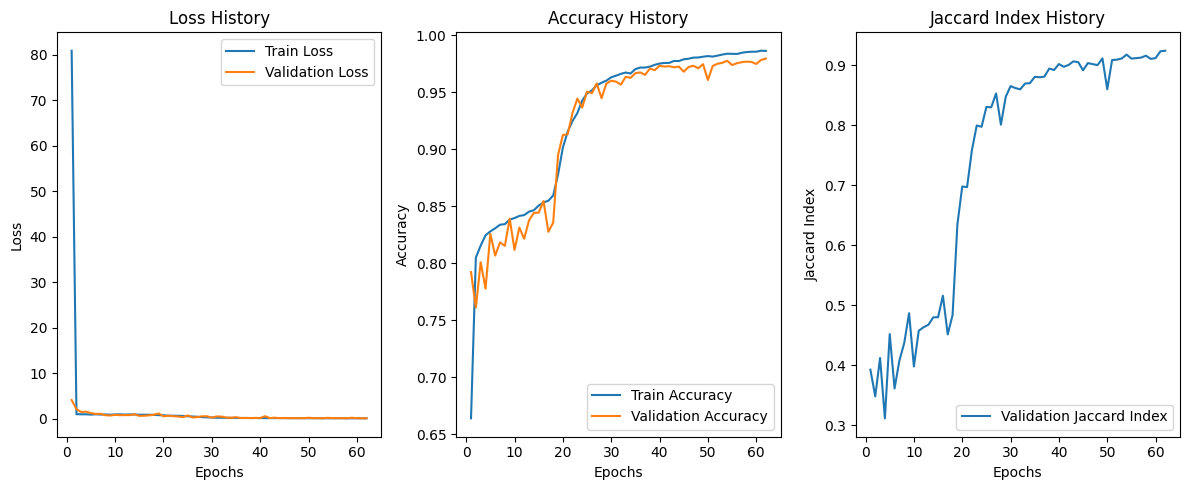

In [51]:
# 학습 실행
num_epochs = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

Checkpoint loaded from epoch 60
Epoch [60/180] training...


Evaluating on validation set...
Epoch [60/180], Loss: 0.0646, Acc: 0.9877, Val_Loss: 0.1847, Val_Acc: 0.9759, Val_Jaccard: 0.9112
Checkpoint saved at epoch 60
Best model saved as 'best_model.pth'
Epoch [61/180] training...


Evaluating on validation set...
Epoch [61/180], Loss: 0.0701, Acc: 0.9859, Val_Loss: 0.0896, Val_Acc: 0.9794, Val_Jaccard: 0.9256
New best model with val_jaccard: 0.9256
Checkpoint saved at epoch 61
Best model saved as 'best_model.pth'
Epoch [62/180] training...


Evaluating on validation set...
Epoch [62/180], Loss: 0.0673, Acc: 0.9869, Val_Loss: 0.2262, Val_Acc: 0.9750, Val_Jaccard: 0.9072
Checkpoint saved at epoch 62
Best model saved as 'best_model.pth'
Epoch [63/180] training...


Evaluating on validation set...
Epoch [63/180], Loss: 0.0699, Acc: 0.9873, Val_Loss: 0.1546, Val_Acc: 0.9795, Val_Jaccard: 0.9262
New best model with val_jaccard: 0.9262
Checkpoint saved at epoch 63
Best model saved as 'best_model.pth'
Epoch [64/180] training...


Evaluating on validation set...
Epoch [64/180], Loss: 0.0758, Acc: 0.9871, Val_Loss: 0.1743, Val_Acc: 0.9768, Val_Jaccard: 0.9139
Checkpoint saved at epoch 64
Best model saved as 'best_model.pth'
Epoch [65/180] training...


Evaluating on validation set...
Epoch [65/180], Loss: 0.0651, Acc: 0.9880, Val_Loss: 0.1282, Val_Acc: 0.9785, Val_Jaccard: 0.9214
Checkpoint saved at epoch 65
Best model saved as 'best_model.pth'
Epoch [66/180] training...


Evaluating on validation set...
Epoch [66/180], Loss: 0.0717, Acc: 0.9874, Val_Loss: 0.1158, Val_Acc: 0.9779, Val_Jaccard: 0.9185
Checkpoint saved at epoch 66
Best model saved as 'best_model.pth'
Epoch [67/180] training...


Evaluating on validation set...
Epoch [67/180], Loss: 0.0716, Acc: 0.9877, Val_Loss: 0.1537, Val_Acc: 0.9779, Val_Jaccard: 0.9195
Checkpoint saved at epoch 67
Best model saved as 'best_model.pth'
Epoch [68/180] training...


Evaluating on validation set...
Epoch [68/180], Loss: 0.0634, Acc: 0.9883, Val_Loss: 0.0972, Val_Acc: 0.9786, Val_Jaccard: 0.9207
Checkpoint saved at epoch 68
Best model saved as 'best_model.pth'
Epoch [69/180] training...


Evaluating on validation set...
Epoch [69/180], Loss: 0.0699, Acc: 0.9877, Val_Loss: 0.1172, Val_Acc: 0.9788, Val_Jaccard: 0.9218
Checkpoint saved at epoch 69
Best model saved as 'best_model.pth'
Epoch [70/180] training...


Evaluating on validation set...
Epoch [70/180], Loss: 0.0626, Acc: 0.9878, Val_Loss: 0.0856, Val_Acc: 0.9798, Val_Jaccard: 0.9272
New best model with val_jaccard: 0.9272
Checkpoint saved at epoch 70
Best model saved as 'best_model.pth'
Epoch [71/180] training...


Evaluating on validation set...
Epoch [71/180], Loss: 0.0708, Acc: 0.9878, Val_Loss: 0.1007, Val_Acc: 0.9758, Val_Jaccard: 0.9118
Checkpoint saved at epoch 71
Best model saved as 'best_model.pth'
Epoch [72/180] training...


Evaluating on validation set...
Epoch [72/180], Loss: 0.0681, Acc: 0.9873, Val_Loss: 0.0865, Val_Acc: 0.9778, Val_Jaccard: 0.9222
Checkpoint saved at epoch 72
Best model saved as 'best_model.pth'
Epoch [73/180] training...


Evaluating on validation set...
Epoch [73/180], Loss: 0.0646, Acc: 0.9886, Val_Loss: 0.7113, Val_Acc: 0.9791, Val_Jaccard: 0.9204
Checkpoint saved at epoch 73
Best model saved as 'best_model.pth'
Epoch [74/180] training...


Evaluating on validation set...
Epoch [74/180], Loss: 0.0689, Acc: 0.9877, Val_Loss: 0.1495, Val_Acc: 0.9804, Val_Jaccard: 0.9276
New best model with val_jaccard: 0.9276
Checkpoint saved at epoch 74
Best model saved as 'best_model.pth'
Epoch [75/180] training...


Evaluating on validation set...
Epoch [75/180], Loss: 0.0688, Acc: 0.9875, Val_Loss: 0.1446, Val_Acc: 0.9798, Val_Jaccard: 0.9259
Checkpoint saved at epoch 75
Best model saved as 'best_model.pth'
Epoch [76/180] training...


Evaluating on validation set...
Epoch [76/180], Loss: 0.0640, Acc: 0.9878, Val_Loss: 0.0970, Val_Acc: 0.9765, Val_Jaccard: 0.9149
Checkpoint saved at epoch 76
Best model saved as 'best_model.pth'
Epoch [77/180] training...


Evaluating on validation set...
Epoch [77/180], Loss: 0.0624, Acc: 0.9879, Val_Loss: 0.0953, Val_Acc: 0.9783, Val_Jaccard: 0.9201
Checkpoint saved at epoch 77
Best model saved as 'best_model.pth'
Epoch [78/180] training...


Evaluating on validation set...
Epoch [78/180], Loss: 0.0669, Acc: 0.9881, Val_Loss: 0.1454, Val_Acc: 0.9785, Val_Jaccard: 0.9209
Checkpoint saved at epoch 78
Best model saved as 'best_model.pth'
Epoch [79/180] training...


Evaluating on validation set...
Epoch [79/180], Loss: 0.0660, Acc: 0.9878, Val_Loss: 0.0971, Val_Acc: 0.9800, Val_Jaccard: 0.9260
Checkpoint saved at epoch 79
Best model saved as 'best_model.pth'
Epoch [80/180] training...


Evaluating on validation set...
Epoch [80/180], Loss: 0.0619, Acc: 0.9880, Val_Loss: 0.0889, Val_Acc: 0.9790, Val_Jaccard: 0.9212
Checkpoint saved at epoch 80
Best model saved as 'best_model.pth'
Epoch [81/180] training...


Evaluating on validation set...
Epoch [81/180], Loss: 0.0692, Acc: 0.9887, Val_Loss: 0.1298, Val_Acc: 0.9747, Val_Jaccard: 0.9062
Checkpoint saved at epoch 81
Best model saved as 'best_model.pth'
Epoch [82/180] training...


Evaluating on validation set...
Epoch [82/180], Loss: 0.0646, Acc: 0.9878, Val_Loss: 0.1146, Val_Acc: 0.9797, Val_Jaccard: 0.9280
New best model with val_jaccard: 0.9280
Checkpoint saved at epoch 82
Best model saved as 'best_model.pth'
Epoch [83/180] training...


Evaluating on validation set...
Epoch [83/180], Loss: 0.0636, Acc: 0.9884, Val_Loss: 0.1020, Val_Acc: 0.9787, Val_Jaccard: 0.9205
Checkpoint saved at epoch 83
Best model saved as 'best_model.pth'
Epoch [84/180] training...


Evaluating on validation set...
Epoch [84/180], Loss: 0.0611, Acc: 0.9885, Val_Loss: 0.1080, Val_Acc: 0.9804, Val_Jaccard: 0.9292
New best model with val_jaccard: 0.9292
Checkpoint saved at epoch 84
Best model saved as 'best_model.pth'
Epoch [85/180] training...


Evaluating on validation set...
Epoch [85/180], Loss: 0.0593, Acc: 0.9889, Val_Loss: 0.0940, Val_Acc: 0.9776, Val_Jaccard: 0.9198
Checkpoint saved at epoch 85
Best model saved as 'best_model.pth'
Epoch [86/180] training...


Evaluating on validation set...
Epoch [86/180], Loss: 0.0626, Acc: 0.9885, Val_Loss: 0.0855, Val_Acc: 0.9787, Val_Jaccard: 0.9233
Checkpoint saved at epoch 86
Best model saved as 'best_model.pth'
Epoch [87/180] training...


Evaluating on validation set...
Epoch [87/180], Loss: 0.0587, Acc: 0.9887, Val_Loss: 0.1097, Val_Acc: 0.9790, Val_Jaccard: 0.9235
Checkpoint saved at epoch 87
Best model saved as 'best_model.pth'
Epoch [88/180] training...


Evaluating on validation set...
Epoch [88/180], Loss: 0.0590, Acc: 0.9889, Val_Loss: 0.1104, Val_Acc: 0.9799, Val_Jaccard: 0.9263
Checkpoint saved at epoch 88
Best model saved as 'best_model.pth'
Epoch [89/180] training...


Evaluating on validation set...
Epoch [89/180], Loss: 0.0641, Acc: 0.9887, Val_Loss: 0.0942, Val_Acc: 0.9801, Val_Jaccard: 0.9270
Checkpoint saved at epoch 89
Best model saved as 'best_model.pth'
Epoch [90/180] training...


Evaluating on validation set...
Epoch [90/180], Loss: 0.0667, Acc: 0.9890, Val_Loss: 0.1512, Val_Acc: 0.9745, Val_Jaccard: 0.9121
Checkpoint saved at epoch 90
Best model saved as 'best_model.pth'
Epoch [91/180] training...


Evaluating on validation set...
Epoch [91/180], Loss: 0.0627, Acc: 0.9883, Val_Loss: 0.1015, Val_Acc: 0.9790, Val_Jaccard: 0.9234
Checkpoint saved at epoch 91
Best model saved as 'best_model.pth'
Epoch [92/180] training...


Evaluating on validation set...
Epoch [92/180], Loss: 0.0585, Acc: 0.9888, Val_Loss: 0.1705, Val_Acc: 0.9786, Val_Jaccard: 0.9217
Checkpoint saved at epoch 92
Best model saved as 'best_model.pth'
Epoch [93/180] training...


Evaluating on validation set...
Epoch [93/180], Loss: 0.0660, Acc: 0.9888, Val_Loss: 0.0908, Val_Acc: 0.9778, Val_Jaccard: 0.9192
Checkpoint saved at epoch 93
Best model saved as 'best_model.pth'
Epoch [94/180] training...


Evaluating on validation set...
Epoch [94/180], Loss: 0.0620, Acc: 0.9885, Val_Loss: 0.0915, Val_Acc: 0.9790, Val_Jaccard: 0.9232
Checkpoint saved at epoch 94
Best model saved as 'best_model.pth'
Epoch [95/180] training...


Evaluating on validation set...
Epoch [95/180], Loss: 0.0646, Acc: 0.9881, Val_Loss: 0.0825, Val_Acc: 0.9800, Val_Jaccard: 0.9277
Checkpoint saved at epoch 95
Best model saved as 'best_model.pth'
Epoch [96/180] training...


Evaluating on validation set...
Epoch [96/180], Loss: 0.0674, Acc: 0.9887, Val_Loss: 0.1477, Val_Acc: 0.9800, Val_Jaccard: 0.9255
Checkpoint saved at epoch 96
Best model saved as 'best_model.pth'
Epoch [97/180] training...


Evaluating on validation set...
Epoch [97/180], Loss: 0.0664, Acc: 0.9884, Val_Loss: 0.0918, Val_Acc: 0.9790, Val_Jaccard: 0.9218
Checkpoint saved at epoch 97
Best model saved as 'best_model.pth'
Epoch [98/180] training...


Evaluating on validation set...
Epoch [98/180], Loss: 0.0595, Acc: 0.9887, Val_Loss: 0.4836, Val_Acc: 0.9792, Val_Jaccard: 0.9244
Checkpoint saved at epoch 98
Best model saved as 'best_model.pth'
Epoch [99/180] training...


Evaluating on validation set...
Epoch [99/180], Loss: 0.0610, Acc: 0.9885, Val_Loss: 0.0849, Val_Acc: 0.9808, Val_Jaccard: 0.9271
Checkpoint saved at epoch 99
Best model saved as 'best_model.pth'
Epoch [100/180] training...


Evaluating on validation set...
Epoch [100/180], Loss: 0.0657, Acc: 0.9886, Val_Loss: 0.1099, Val_Acc: 0.9757, Val_Jaccard: 0.9109
Checkpoint saved at epoch 100
Best model saved as 'best_model.pth'
Epoch [101/180] training...


Evaluating on validation set...
Epoch [101/180], Loss: 0.0614, Acc: 0.9889, Val_Loss: 0.1108, Val_Acc: 0.9795, Val_Jaccard: 0.9255
Checkpoint saved at epoch 101
Best model saved as 'best_model.pth'
Epoch [102/180] training...


Evaluating on validation set...
Epoch [102/180], Loss: 0.0583, Acc: 0.9891, Val_Loss: 0.7676, Val_Acc: 0.9770, Val_Jaccard: 0.9150
Checkpoint saved at epoch 102
Best model saved as 'best_model.pth'
Epoch [103/180] training...


Evaluating on validation set...
Epoch [103/180], Loss: 0.0649, Acc: 0.9887, Val_Loss: 0.1618, Val_Acc: 0.9723, Val_Jaccard: 0.9011
Checkpoint saved at epoch 103
Best model saved as 'best_model.pth'
Epoch [104/180] training...


Evaluating on validation set...
Epoch [104/180], Loss: 0.0638, Acc: 0.9885, Val_Loss: 0.1114, Val_Acc: 0.9804, Val_Jaccard: 0.9271
Checkpoint saved at epoch 104
Best model saved as 'best_model.pth'
Epoch [105/180] training...


Evaluating on validation set...
Epoch [105/180], Loss: 0.0660, Acc: 0.9890, Val_Loss: 0.2159, Val_Acc: 0.9781, Val_Jaccard: 0.9189
Checkpoint saved at epoch 105
Best model saved as 'best_model.pth'
Epoch [106/180] training...


Evaluating on validation set...
Epoch [106/180], Loss: 0.0643, Acc: 0.9882, Val_Loss: 0.1003, Val_Acc: 0.9795, Val_Jaccard: 0.9250
Checkpoint saved at epoch 106
Best model saved as 'best_model.pth'
Epoch [107/180] training...


Evaluating on validation set...
Epoch [107/180], Loss: 0.0639, Acc: 0.9895, Val_Loss: 0.0887, Val_Acc: 0.9808, Val_Jaccard: 0.9277
Checkpoint saved at epoch 107
Best model saved as 'best_model.pth'
Epoch [108/180] training...


Evaluating on validation set...
Epoch [108/180], Loss: 0.0663, Acc: 0.9890, Val_Loss: 0.0868, Val_Acc: 0.9796, Val_Jaccard: 0.9246
Checkpoint saved at epoch 108
Best model saved as 'best_model.pth'
Epoch [109/180] training...


Evaluating on validation set...
Epoch [109/180], Loss: 0.0607, Acc: 0.9886, Val_Loss: 0.0838, Val_Acc: 0.9799, Val_Jaccard: 0.9258
Checkpoint saved at epoch 109
Best model saved as 'best_model.pth'
Epoch [110/180] training...


Evaluating on validation set...
Epoch [110/180], Loss: 0.0593, Acc: 0.9894, Val_Loss: 0.1398, Val_Acc: 0.9790, Val_Jaccard: 0.9231
Checkpoint saved at epoch 110
Best model saved as 'best_model.pth'
Epoch [111/180] training...


Evaluating on validation set...
Epoch [111/180], Loss: 0.0612, Acc: 0.9889, Val_Loss: 0.1021, Val_Acc: 0.9757, Val_Jaccard: 0.9127
Checkpoint saved at epoch 111
Best model saved as 'best_model.pth'
Epoch [112/180] training...


Evaluating on validation set...
Epoch [112/180], Loss: 0.0684, Acc: 0.9885, Val_Loss: 0.0896, Val_Acc: 0.9791, Val_Jaccard: 0.9225
Checkpoint saved at epoch 112
Best model saved as 'best_model.pth'
Epoch [113/180] training...


Evaluating on validation set...
Epoch [113/180], Loss: 0.0619, Acc: 0.9887, Val_Loss: 0.0832, Val_Acc: 0.9800, Val_Jaccard: 0.9261
Checkpoint saved at epoch 113
Best model saved as 'best_model.pth'
Epoch [114/180] training...


Evaluating on validation set...
Epoch [114/180], Loss: 0.0642, Acc: 0.9886, Val_Loss: 0.1415, Val_Acc: 0.9788, Val_Jaccard: 0.9197
Checkpoint saved at epoch 114
Best model saved as 'best_model.pth'
Epoch [115/180] training...


Evaluating on validation set...
Epoch [115/180], Loss: 0.0653, Acc: 0.9889, Val_Loss: 0.1003, Val_Acc: 0.9791, Val_Jaccard: 0.9243
Checkpoint saved at epoch 115
Best model saved as 'best_model.pth'
Epoch [116/180] training...


Evaluating on validation set...
Epoch [116/180], Loss: 0.0658, Acc: 0.9885, Val_Loss: 0.1305, Val_Acc: 0.9780, Val_Jaccard: 0.9176
Checkpoint saved at epoch 116
Best model saved as 'best_model.pth'
Epoch [117/180] training...


Evaluating on validation set...
Epoch [117/180], Loss: 0.0617, Acc: 0.9888, Val_Loss: 0.1206, Val_Acc: 0.9773, Val_Jaccard: 0.9197
Checkpoint saved at epoch 117
Best model saved as 'best_model.pth'
Epoch [118/180] training...


Evaluating on validation set...
Epoch [118/180], Loss: 0.0655, Acc: 0.9890, Val_Loss: 0.1038, Val_Acc: 0.9774, Val_Jaccard: 0.9156
Checkpoint saved at epoch 118
Best model saved as 'best_model.pth'
Epoch [119/180] training...


Evaluating on validation set...
Epoch [119/180], Loss: 0.0588, Acc: 0.9888, Val_Loss: 0.1068, Val_Acc: 0.9800, Val_Jaccard: 0.9262
Checkpoint saved at epoch 119
Best model saved as 'best_model.pth'
Epoch [120/180] training...


Evaluating on validation set...
Epoch [120/180], Loss: 0.0693, Acc: 0.9888, Val_Loss: 0.0993, Val_Acc: 0.9808, Val_Jaccard: 0.9287
Checkpoint saved at epoch 120
Best model saved as 'best_model.pth'
Epoch [121/180] training...


Evaluating on validation set...
Epoch [121/180], Loss: 0.0627, Acc: 0.9893, Val_Loss: 0.1056, Val_Acc: 0.9768, Val_Jaccard: 0.9175
Checkpoint saved at epoch 121
Best model saved as 'best_model.pth'
Epoch [122/180] training...


Evaluating on validation set...
Epoch [122/180], Loss: 0.0581, Acc: 0.9886, Val_Loss: 0.1073, Val_Acc: 0.9781, Val_Jaccard: 0.9185
Checkpoint saved at epoch 122
Best model saved as 'best_model.pth'
Epoch [123/180] training...


Evaluating on validation set...
Epoch [123/180], Loss: 0.0578, Acc: 0.9887, Val_Loss: 0.1045, Val_Acc: 0.9809, Val_Jaccard: 0.9266
Checkpoint saved at epoch 123
Best model saved as 'best_model.pth'
Epoch [124/180] training...


Evaluating on validation set...
Epoch [124/180], Loss: 0.0598, Acc: 0.9892, Val_Loss: 0.1563, Val_Acc: 0.9780, Val_Jaccard: 0.9203
Checkpoint saved at epoch 124
Best model saved as 'best_model.pth'
Epoch [125/180] training...


Evaluating on validation set...
Epoch [125/180], Loss: 0.0668, Acc: 0.9890, Val_Loss: 0.2761, Val_Acc: 0.9798, Val_Jaccard: 0.9250
Checkpoint saved at epoch 125
Best model saved as 'best_model.pth'
Epoch [126/180] training...


Evaluating on validation set...
Epoch [126/180], Loss: 0.0660, Acc: 0.9881, Val_Loss: 0.0875, Val_Acc: 0.9786, Val_Jaccard: 0.9230
Checkpoint saved at epoch 126
Best model saved as 'best_model.pth'
Epoch [127/180] training...


Evaluating on validation set...
Epoch [127/180], Loss: 0.0584, Acc: 0.9890, Val_Loss: 0.0914, Val_Acc: 0.9783, Val_Jaccard: 0.9201
Checkpoint saved at epoch 127
Best model saved as 'best_model.pth'
Epoch [128/180] training...


Evaluating on validation set...
Epoch [128/180], Loss: 0.0667, Acc: 0.9884, Val_Loss: 0.0925, Val_Acc: 0.9799, Val_Jaccard: 0.9267
Checkpoint saved at epoch 128
Best model saved as 'best_model.pth'
Epoch [129/180] training...


Evaluating on validation set...
Epoch [129/180], Loss: 0.0564, Acc: 0.9891, Val_Loss: 0.1463, Val_Acc: 0.9756, Val_Jaccard: 0.9149
Checkpoint saved at epoch 129
Best model saved as 'best_model.pth'
Epoch [130/180] training...


Evaluating on validation set...
Epoch [130/180], Loss: 0.0601, Acc: 0.9889, Val_Loss: 0.0935, Val_Acc: 0.9791, Val_Jaccard: 0.9254
Checkpoint saved at epoch 130
Best model saved as 'best_model.pth'
Epoch [131/180] training...


Evaluating on validation set...
Epoch [131/180], Loss: 0.0626, Acc: 0.9886, Val_Loss: 0.0920, Val_Acc: 0.9783, Val_Jaccard: 0.9205
Checkpoint saved at epoch 131
Best model saved as 'best_model.pth'
Epoch [132/180] training...


Evaluating on validation set...
Epoch [132/180], Loss: 0.0657, Acc: 0.9876, Val_Loss: 0.1095, Val_Acc: 0.9764, Val_Jaccard: 0.9130
Checkpoint saved at epoch 132
Best model saved as 'best_model.pth'
Epoch [133/180] training...


Evaluating on validation set...
Epoch [133/180], Loss: 0.0615, Acc: 0.9887, Val_Loss: 0.1059, Val_Acc: 0.9779, Val_Jaccard: 0.9169
Checkpoint saved at epoch 133
Best model saved as 'best_model.pth'
Epoch [134/180] training...


Evaluating on validation set...
Epoch [134/180], Loss: 0.0700, Acc: 0.9892, Val_Loss: 0.2786, Val_Acc: 0.9779, Val_Jaccard: 0.9202
Checkpoint saved at epoch 134
Best model saved as 'best_model.pth'
Epoch [135/180] training...


Evaluating on validation set...
Epoch [135/180], Loss: 0.0708, Acc: 0.9880, Val_Loss: 0.0917, Val_Acc: 0.9789, Val_Jaccard: 0.9237
Checkpoint saved at epoch 135
Best model saved as 'best_model.pth'
Epoch [136/180] training...


Evaluating on validation set...
Epoch [136/180], Loss: 0.0621, Acc: 0.9888, Val_Loss: 0.1117, Val_Acc: 0.9772, Val_Jaccard: 0.9200
Checkpoint saved at epoch 136
Best model saved as 'best_model.pth'
Epoch [137/180] training...


Evaluating on validation set...
Epoch [137/180], Loss: 0.0612, Acc: 0.9883, Val_Loss: 0.0973, Val_Acc: 0.9793, Val_Jaccard: 0.9203
Checkpoint saved at epoch 137
Best model saved as 'best_model.pth'
Epoch [138/180] training...


Evaluating on validation set...
Epoch [138/180], Loss: 0.0609, Acc: 0.9882, Val_Loss: 0.2253, Val_Acc: 0.9805, Val_Jaccard: 0.9273
Checkpoint saved at epoch 138
Best model saved as 'best_model.pth'
Epoch [139/180] training...


Evaluating on validation set...
Epoch [139/180], Loss: 0.0613, Acc: 0.9894, Val_Loss: 0.1183, Val_Acc: 0.9760, Val_Jaccard: 0.9114
Checkpoint saved at epoch 139
Best model saved as 'best_model.pth'
Epoch [140/180] training...


Evaluating on validation set...
Epoch [140/180], Loss: 0.0640, Acc: 0.9879, Val_Loss: 0.0935, Val_Acc: 0.9791, Val_Jaccard: 0.9230
Checkpoint saved at epoch 140
Best model saved as 'best_model.pth'
Epoch [141/180] training...


Evaluating on validation set...
Epoch [141/180], Loss: 0.0640, Acc: 0.9892, Val_Loss: 0.0949, Val_Acc: 0.9785, Val_Jaccard: 0.9224
Checkpoint saved at epoch 141
Best model saved as 'best_model.pth'
Epoch [142/180] training...


Evaluating on validation set...
Epoch [142/180], Loss: 0.0579, Acc: 0.9888, Val_Loss: 0.0896, Val_Acc: 0.9790, Val_Jaccard: 0.9229
Checkpoint saved at epoch 142
Best model saved as 'best_model.pth'
Epoch [143/180] training...


Evaluating on validation set...
Epoch [143/180], Loss: 0.0672, Acc: 0.9886, Val_Loss: 0.2580, Val_Acc: 0.9797, Val_Jaccard: 0.9243
Checkpoint saved at epoch 143
Best model saved as 'best_model.pth'
Epoch [144/180] training...


Evaluating on validation set...
Epoch [144/180], Loss: 0.0619, Acc: 0.9888, Val_Loss: 0.1106, Val_Acc: 0.9792, Val_Jaccard: 0.9211
Checkpoint saved at epoch 144
Best model saved as 'best_model.pth'
Epoch [145/180] training...


Evaluating on validation set...
Epoch [145/180], Loss: 0.0578, Acc: 0.9891, Val_Loss: 0.1144, Val_Acc: 0.9777, Val_Jaccard: 0.9206
Checkpoint saved at epoch 145
Best model saved as 'best_model.pth'
Epoch [146/180] training...


Evaluating on validation set...
Epoch [146/180], Loss: 0.0715, Acc: 0.9884, Val_Loss: 0.3267, Val_Acc: 0.9783, Val_Jaccard: 0.9212
Checkpoint saved at epoch 146
Best model saved as 'best_model.pth'
Epoch [147/180] training...


Evaluating on validation set...
Epoch [147/180], Loss: 0.0651, Acc: 0.9887, Val_Loss: 0.1599, Val_Acc: 0.9772, Val_Jaccard: 0.9197
Checkpoint saved at epoch 147
Best model saved as 'best_model.pth'
Epoch [148/180] training...


Evaluating on validation set...
Epoch [148/180], Loss: 0.0598, Acc: 0.9892, Val_Loss: 0.0892, Val_Acc: 0.9799, Val_Jaccard: 0.9243
Checkpoint saved at epoch 148
Best model saved as 'best_model.pth'
Epoch [149/180] training...


Evaluating on validation set...
Epoch [149/180], Loss: 0.0625, Acc: 0.9888, Val_Loss: 0.2706, Val_Acc: 0.9798, Val_Jaccard: 0.9277
Checkpoint saved at epoch 149
Best model saved as 'best_model.pth'
Epoch [150/180] training...


Evaluating on validation set...
Epoch [150/180], Loss: 0.0612, Acc: 0.9890, Val_Loss: 0.0903, Val_Acc: 0.9797, Val_Jaccard: 0.9250
Checkpoint saved at epoch 150
Best model saved as 'best_model.pth'
Epoch [151/180] training...


Evaluating on validation set...
Epoch [151/180], Loss: 0.0601, Acc: 0.9886, Val_Loss: 0.1223, Val_Acc: 0.9778, Val_Jaccard: 0.9185
Checkpoint saved at epoch 151
Best model saved as 'best_model.pth'
Epoch [152/180] training...


Evaluating on validation set...
Epoch [152/180], Loss: 0.0627, Acc: 0.9890, Val_Loss: 0.1187, Val_Acc: 0.9798, Val_Jaccard: 0.9239
Checkpoint saved at epoch 152
Best model saved as 'best_model.pth'
Epoch [153/180] training...


Evaluating on validation set...
Epoch [153/180], Loss: 0.0595, Acc: 0.9892, Val_Loss: 0.1647, Val_Acc: 0.9784, Val_Jaccard: 0.9179
Checkpoint saved at epoch 153
Best model saved as 'best_model.pth'
Epoch [154/180] training...


Evaluating on validation set...
Epoch [154/180], Loss: 0.0670, Acc: 0.9890, Val_Loss: 0.0956, Val_Acc: 0.9779, Val_Jaccard: 0.9215
Checkpoint saved at epoch 154
Best model saved as 'best_model.pth'
Epoch [155/180] training...


Evaluating on validation set...
Epoch [155/180], Loss: 0.0676, Acc: 0.9886, Val_Loss: 0.0960, Val_Acc: 0.9785, Val_Jaccard: 0.9179
Checkpoint saved at epoch 155
Best model saved as 'best_model.pth'
Epoch [156/180] training...


Evaluating on validation set...
Epoch [156/180], Loss: 0.0627, Acc: 0.9891, Val_Loss: 0.1399, Val_Acc: 0.9798, Val_Jaccard: 0.9243
Checkpoint saved at epoch 156
Best model saved as 'best_model.pth'
Epoch [157/180] training...


Evaluating on validation set...
Epoch [157/180], Loss: 0.0681, Acc: 0.9880, Val_Loss: 0.0905, Val_Acc: 0.9795, Val_Jaccard: 0.9249
Checkpoint saved at epoch 157
Best model saved as 'best_model.pth'
Epoch [158/180] training...


Evaluating on validation set...
Epoch [158/180], Loss: 0.0572, Acc: 0.9890, Val_Loss: 0.0958, Val_Acc: 0.9784, Val_Jaccard: 0.9187
Checkpoint saved at epoch 158
Best model saved as 'best_model.pth'
Epoch [159/180] training...


Evaluating on validation set...
Epoch [159/180], Loss: 0.0638, Acc: 0.9885, Val_Loss: 0.1046, Val_Acc: 0.9769, Val_Jaccard: 0.9140
Checkpoint saved at epoch 159
Best model saved as 'best_model.pth'
Epoch [160/180] training...


Evaluating on validation set...
Epoch [160/180], Loss: 0.0625, Acc: 0.9888, Val_Loss: 0.1152, Val_Acc: 0.9776, Val_Jaccard: 0.9173
Checkpoint saved at epoch 160
Best model saved as 'best_model.pth'
Epoch [161/180] training...


Evaluating on validation set...
Epoch [161/180], Loss: 0.0647, Acc: 0.9881, Val_Loss: 0.0923, Val_Acc: 0.9785, Val_Jaccard: 0.9221
Checkpoint saved at epoch 161
Best model saved as 'best_model.pth'
Epoch [162/180] training...


Evaluating on validation set...
Epoch [162/180], Loss: 0.0606, Acc: 0.9891, Val_Loss: 0.0950, Val_Acc: 0.9786, Val_Jaccard: 0.9212
Checkpoint saved at epoch 162
Best model saved as 'best_model.pth'
Epoch [163/180] training...


Evaluating on validation set...
Epoch [163/180], Loss: 0.0690, Acc: 0.9881, Val_Loss: 0.7625, Val_Acc: 0.9798, Val_Jaccard: 0.9256
Checkpoint saved at epoch 163
Best model saved as 'best_model.pth'
Epoch [164/180] training...


Evaluating on validation set...
Epoch [164/180], Loss: 0.0663, Acc: 0.9888, Val_Loss: 0.1753, Val_Acc: 0.9799, Val_Jaccard: 0.9276
Checkpoint saved at epoch 164
Best model saved as 'best_model.pth'
Epoch [165/180] training...


Evaluating on validation set...
Epoch [165/180], Loss: 0.0607, Acc: 0.9885, Val_Loss: 0.0989, Val_Acc: 0.9786, Val_Jaccard: 0.9233
Checkpoint saved at epoch 165
Best model saved as 'best_model.pth'
Epoch [166/180] training...


Evaluating on validation set...
Epoch [166/180], Loss: 0.0671, Acc: 0.9880, Val_Loss: 0.1573, Val_Acc: 0.9793, Val_Jaccard: 0.9240
Checkpoint saved at epoch 166
Best model saved as 'best_model.pth'
Epoch [167/180] training...


Evaluating on validation set...
Epoch [167/180], Loss: 0.0621, Acc: 0.9897, Val_Loss: 0.0989, Val_Acc: 0.9777, Val_Jaccard: 0.9166
Checkpoint saved at epoch 167
Best model saved as 'best_model.pth'
Epoch [168/180] training...


Evaluating on validation set...
Epoch [168/180], Loss: 0.0606, Acc: 0.9886, Val_Loss: 0.1114, Val_Acc: 0.9787, Val_Jaccard: 0.9243
Checkpoint saved at epoch 168
Best model saved as 'best_model.pth'
Epoch [169/180] training...


Evaluating on validation set...
Epoch [169/180], Loss: 0.0661, Acc: 0.9891, Val_Loss: 0.1169, Val_Acc: 0.9777, Val_Jaccard: 0.9176
Checkpoint saved at epoch 169
Best model saved as 'best_model.pth'
Epoch [170/180] training...


Evaluating on validation set...
Epoch [170/180], Loss: 0.0626, Acc: 0.9887, Val_Loss: 0.1240, Val_Acc: 0.9770, Val_Jaccard: 0.9175
Checkpoint saved at epoch 170
Best model saved as 'best_model.pth'
Epoch [171/180] training...


Evaluating on validation set...
Epoch [171/180], Loss: 0.0565, Acc: 0.9887, Val_Loss: 0.0866, Val_Acc: 0.9791, Val_Jaccard: 0.9238
Checkpoint saved at epoch 171
Best model saved as 'best_model.pth'
Epoch [172/180] training...


Evaluating on validation set...
Epoch [172/180], Loss: 0.0615, Acc: 0.9886, Val_Loss: 0.0908, Val_Acc: 0.9797, Val_Jaccard: 0.9259
Checkpoint saved at epoch 172
Best model saved as 'best_model.pth'
Epoch [173/180] training...


Evaluating on validation set...
Epoch [173/180], Loss: 0.0649, Acc: 0.9880, Val_Loss: 0.1017, Val_Acc: 0.9794, Val_Jaccard: 0.9213
Checkpoint saved at epoch 173
Best model saved as 'best_model.pth'
Epoch [174/180] training...


Evaluating on validation set...
Epoch [174/180], Loss: 0.0626, Acc: 0.9885, Val_Loss: 0.1087, Val_Acc: 0.9776, Val_Jaccard: 0.9200
Checkpoint saved at epoch 174
Best model saved as 'best_model.pth'
Epoch [175/180] training...


Evaluating on validation set...
Epoch [175/180], Loss: 0.0587, Acc: 0.9893, Val_Loss: 0.2127, Val_Acc: 0.9675, Val_Jaccard: 0.8835
Checkpoint saved at epoch 175
Best model saved as 'best_model.pth'
Epoch [176/180] training...


Evaluating on validation set...
Epoch [176/180], Loss: 0.0622, Acc: 0.9884, Val_Loss: 0.1183, Val_Acc: 0.9775, Val_Jaccard: 0.9172
Checkpoint saved at epoch 176
Best model saved as 'best_model.pth'
Epoch [177/180] training...


Evaluating on validation set...
Epoch [177/180], Loss: 0.0685, Acc: 0.9889, Val_Loss: 0.1101, Val_Acc: 0.9792, Val_Jaccard: 0.9248
Checkpoint saved at epoch 177
Best model saved as 'best_model.pth'
Epoch [178/180] training...


Evaluating on validation set...
Epoch [178/180], Loss: 0.0602, Acc: 0.9891, Val_Loss: 0.1238, Val_Acc: 0.9789, Val_Jaccard: 0.9230
Checkpoint saved at epoch 178
Best model saved as 'best_model.pth'
Epoch [179/180] training...


Evaluating on validation set...
Epoch [179/180], Loss: 0.0622, Acc: 0.9884, Val_Loss: 0.0845, Val_Acc: 0.9801, Val_Jaccard: 0.9272
Checkpoint saved at epoch 179
Best model saved as 'best_model.pth'
Epoch [180/180] training...


Evaluating on validation set...
Epoch [180/180], Loss: 0.0648, Acc: 0.9887, Val_Loss: 0.1050, Val_Acc: 0.9796, Val_Jaccard: 0.9259
Checkpoint saved at epoch 180
Best model saved as 'best_model.pth'


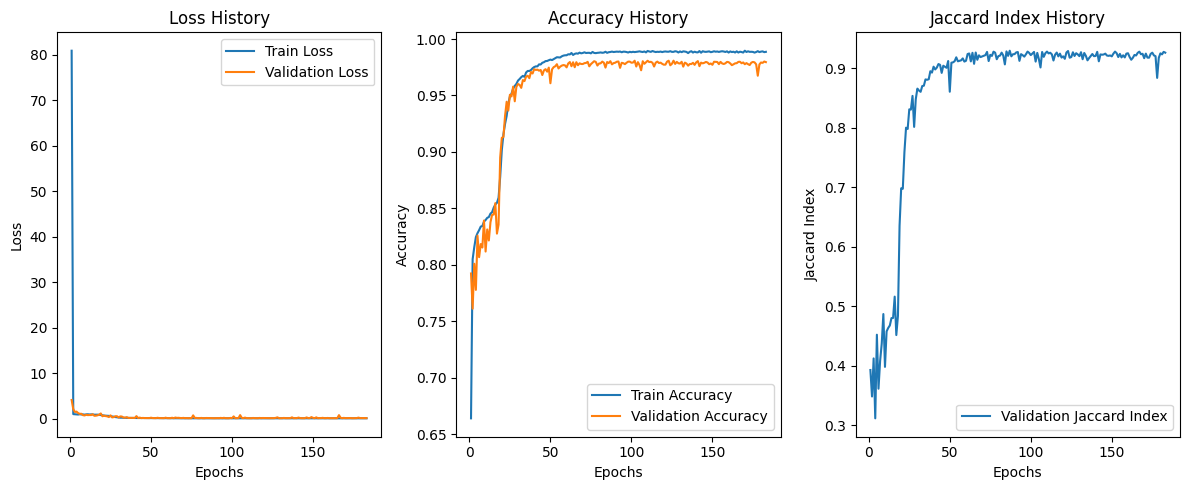

In [53]:
# 학습 실행
num_epochs = 180
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = UNetWithClassifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device)

# 학습 기록 시각화
plot_history(history)

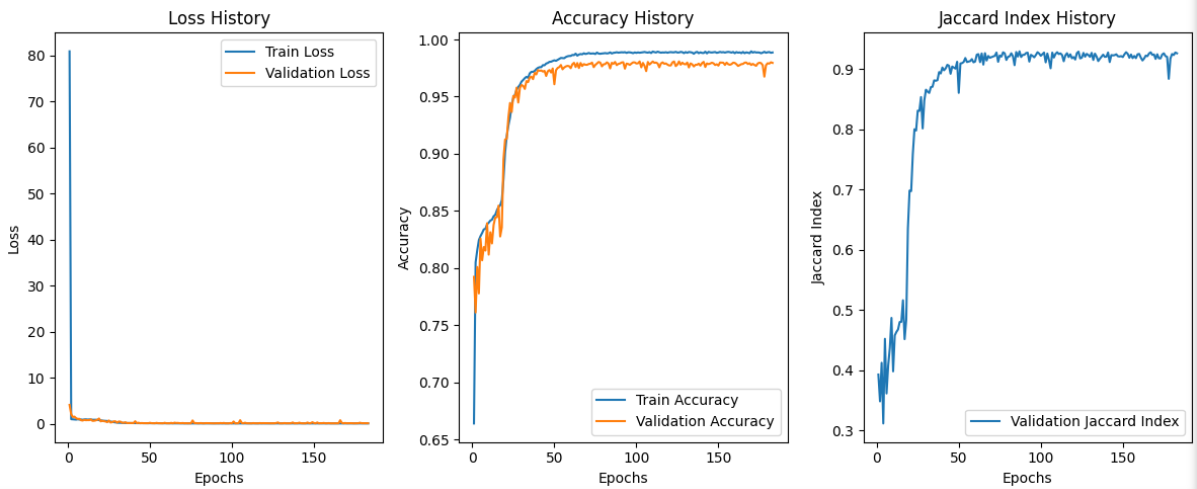